# OBJVAE

## Init

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random, os
import numpy as np
import torch
import importlib
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE.single import objVAE_single
from objVAE.single import bg_single
from objVAE.single import utils_single

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(42)

### Helper functions

In [3]:
def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()

    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        alpha = z_pres.detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[alpha]
        edge_color = plt.cm.get_cmap('spring')(z_pres[alpha].detach().cpu().numpy())

    else:
        (
            recon,
            kl_divergence,
            background_kl,
            xy,
            background,
            x_hat,
            z_pres,
            pres_loss
        ) = model(x)
        xy = xy.detach().cpu().numpy()[:]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 3)
    plt.imshow(x[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], s=10, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(2, 2, 4)
    plt.imshow(
        recon[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")

    plt.subplot(2, 2, 1)
    plt.imshow(
        background[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("background")

    plt.subplot(2, 2, 2)
    plt.imshow(
        x_hat[0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, :, :].min(),
        vmax=x[0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("forground")

    plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

## Run/Test

### Load data

0
100
200


/usr/local/lib/python3.8/dist-packages/deeptrack/scatterers.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632
/usr/local/lib/python3.8/dist-packages/deeptrack/scatterers.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632
/usr/local/lib/python3.8/dist-packages/deeptrack/scatterers.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632
/usr/local/lib/python3.8/dist-packages/deeptrack/scatterers.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632
/usr/local/lib/python3.8/dist-packages/deeptrack/scatterers.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632
/usr/local/lib/python3.8/dist-packages/deeptrack/scatterers.py:100: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if upsample is not 1:  # noqa: F632
/usr/local

KeyboardInterrupt: 

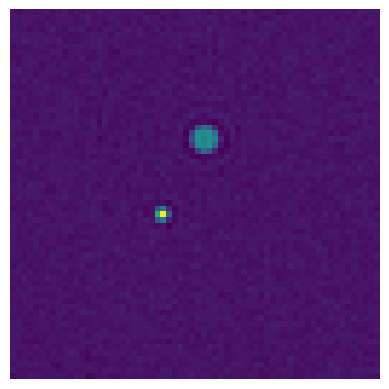

In [4]:
import deeptrack as dt
import numpy as np

def update_position(previous_value, diffusion_constant, dt=1/10):
    new_position = np.clip(previous_value + np.random.randn(2) 
                           * np.sqrt(diffusion_constant * dt) * 1e7, 0, image_size)
    return new_position

image_size = 64
sequence_length = 15

particle = dt.MieSphere(
    diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
    refractive_index=1.55,
    radius=lambda: np.random.uniform(1e-6/2, 1e-6*2),
    z=lambda: np.random.uniform(-2, 2) * dt.units.um,
    position=lambda: np.random.uniform(5, image_size - 5, 2),
)

optics = dt.Brightfield(
    NA=0.4,
    magnification=5,
    resolution=3e-6,
    wavelength=0.6e-6,
    output_region=(0, 0, image_size, image_size),
)

# %%
particle = dt.Sequential(particle, position=update_position)
particles = particle ^ (lambda: np.random.randint(2, 6)) 
image_pipeline = optics(particles) >> dt.Gaussian(sigma=0.1)

image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

image_pipeline.update().plot()

# generate a dataset of 1000 images
images = []
for i in range(100):
    if i % 10 == 0:
        print(i)
    images.append(image_pipeline.update()())

In [22]:
training_images = np.array(images)
training_images = training_images.reshape(-1, 1, 64, 64)
print(training_images.shape)
training_images = torch.tensor(training_images).float()

(3870, 1, 64, 64)


In [23]:
train, test = torch.utils.data.random_split(training_images, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

### Create model

In [40]:
import IPython.display as ipd
import pytorch_lightning as pl

# Callbacks
max_steps = 20000
beta_annealing_end = max_steps
lr_annealing_end = max_steps
kl_annealing_end = 2400
presence_annealing_end = 2500
unfreeze = 0

def beta_annealing(step):
    logs = np.logspace(-8.3, -3, beta_annealing_end) # 8.3 - 7
    if step < beta_annealing_end:
        return logs[step]
    else:
        return logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0
    if step < kl_annealing_end:
        return logs[step]
    else:
        return 1

def presence_annealing(step):
    lins = np.linspace(0.1, 0, presence_annealing_end)
    if step < presence_annealing_end:
        return lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-1, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 2:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


In [41]:
importlib.reload(objVAE_single)
importlib.reload(bg_single)

load_model = ""

#load_model = "../state_dicts/model-musc-bg.pth"
#load_model = "../state_dicts/model-microtubuler-256px-bad.pth"


num_entities = 10
latent_dim = 10
beta = 1e-4
object_radius = 8
combine_method = "sum"
topk_select_method = 'max'
decoder="linnear"
decoder_feature_size=56 #56
encoder_num_layers=3
decoder_num_layers=4

single_decoder = True

bg_params = {
    'decoder_activation': 'relu',
    'decoder_channels': 60,
    'decoder_norm': 'batch',
    'decoder_depth': 6,
    'encoder_activation': 'relu',
    'encoder_channels': 36,
    'encoder_norm': 'instance',
    'encoder_depth': 5,
    'hidden_dim': 12,
    'position_dim': 128
}

background_model = bg_single.objBG(in_channels=1,image_size=64, **bg_params)
    


model = objVAE_single.MEVAE(
    num_entities,
    background_model=background_model,
    beta=beta,
    latent_dim=latent_dim,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_num_layers=encoder_num_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


In [36]:
for param in model.model.parameters():
    param.requires_grad = True

### Train

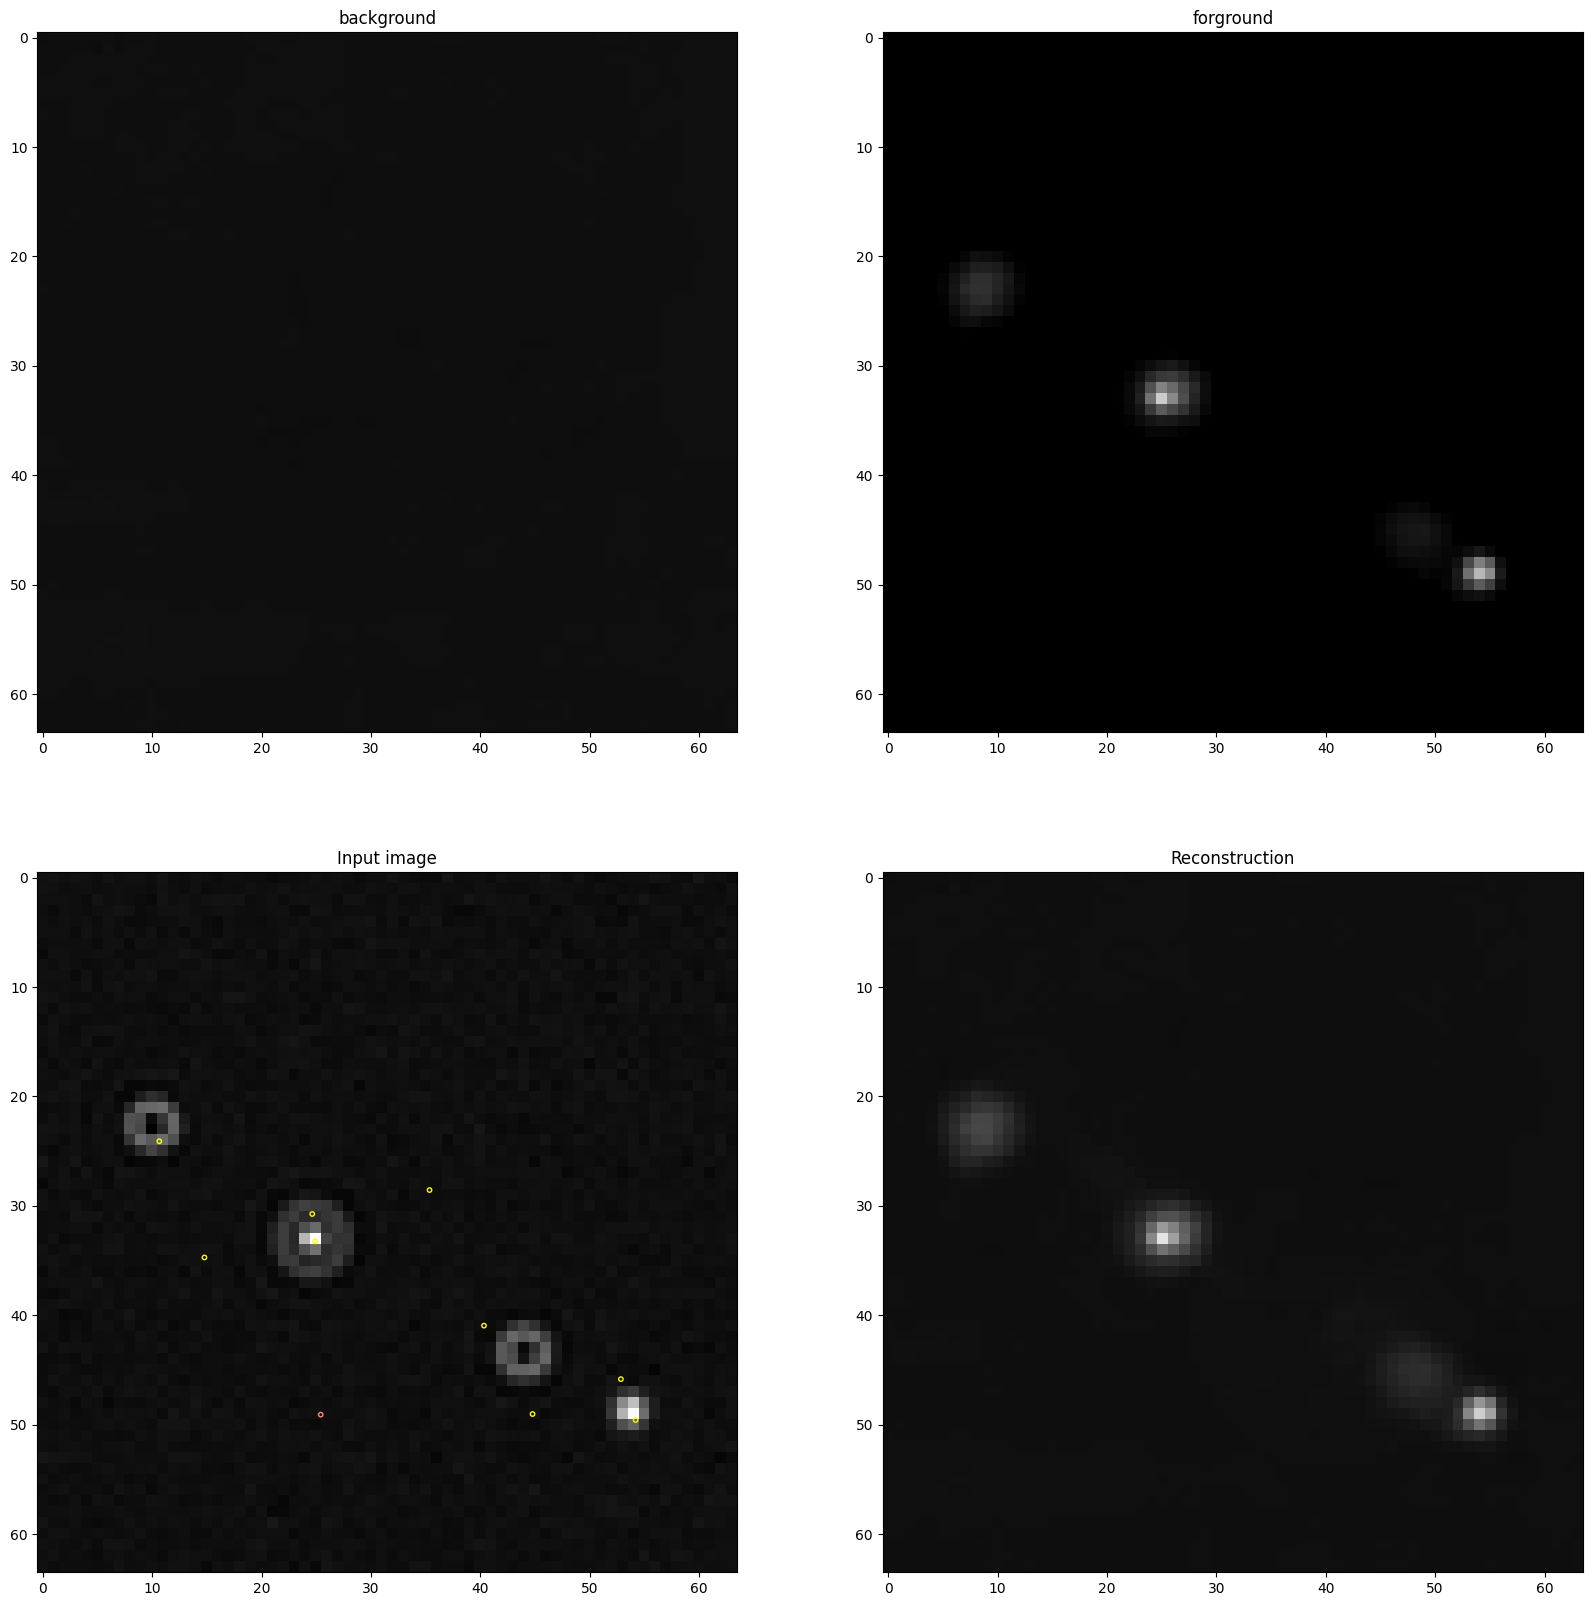

In [42]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

### Test

In [29]:
print(model.model.kl_importance)
model.model.kl_importance = 0

0


KeyboardInterrupt: 

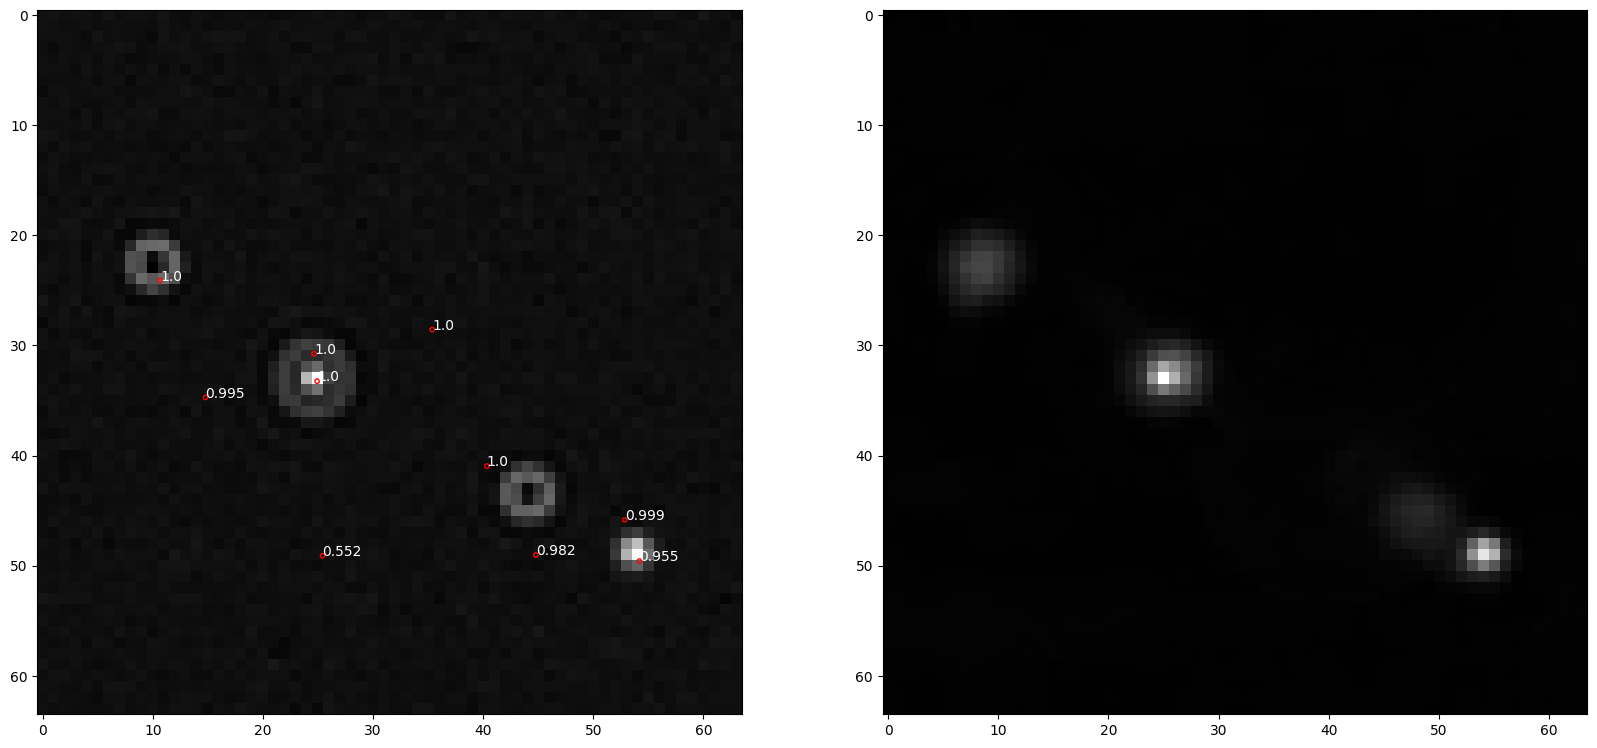

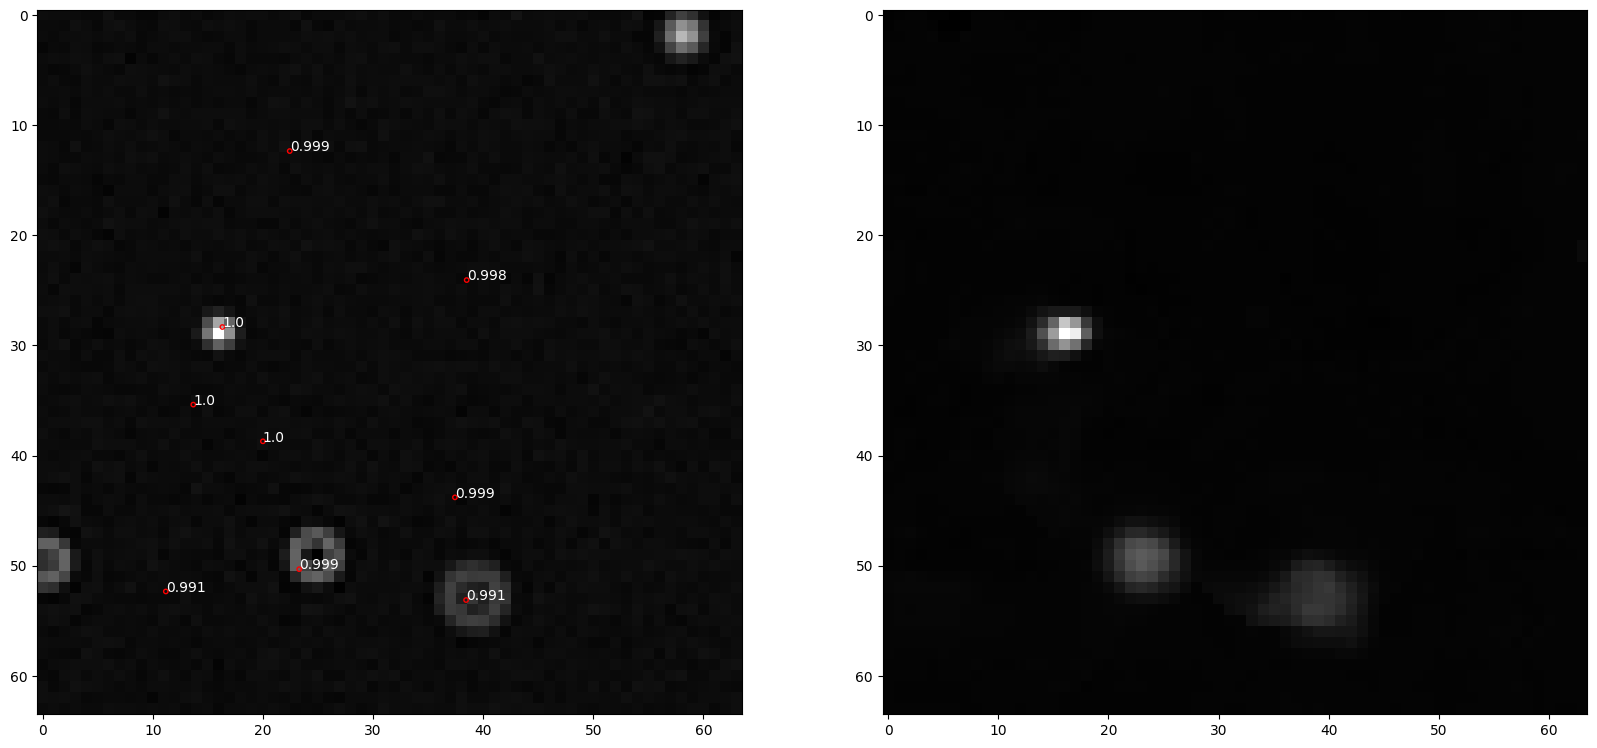

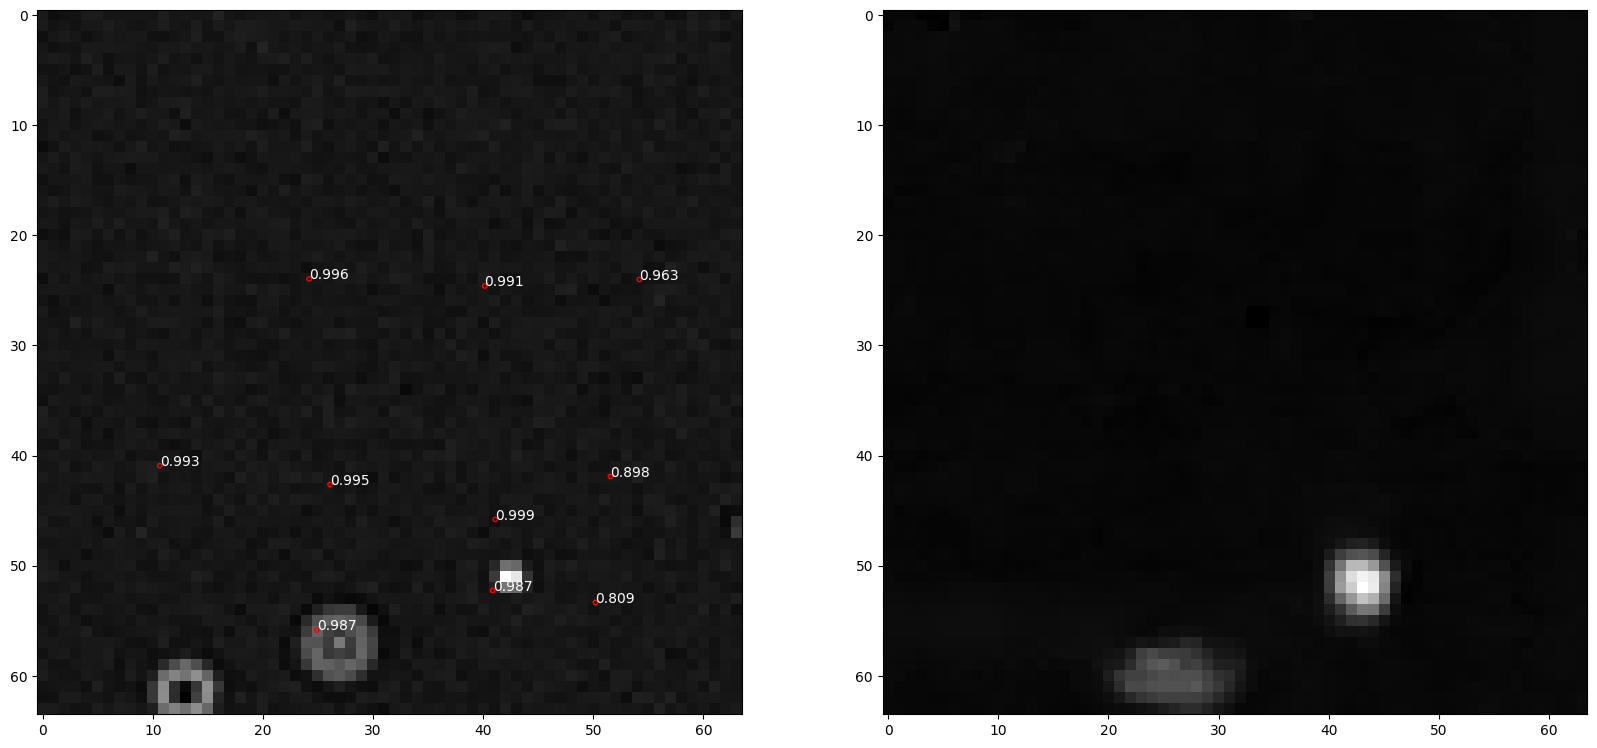

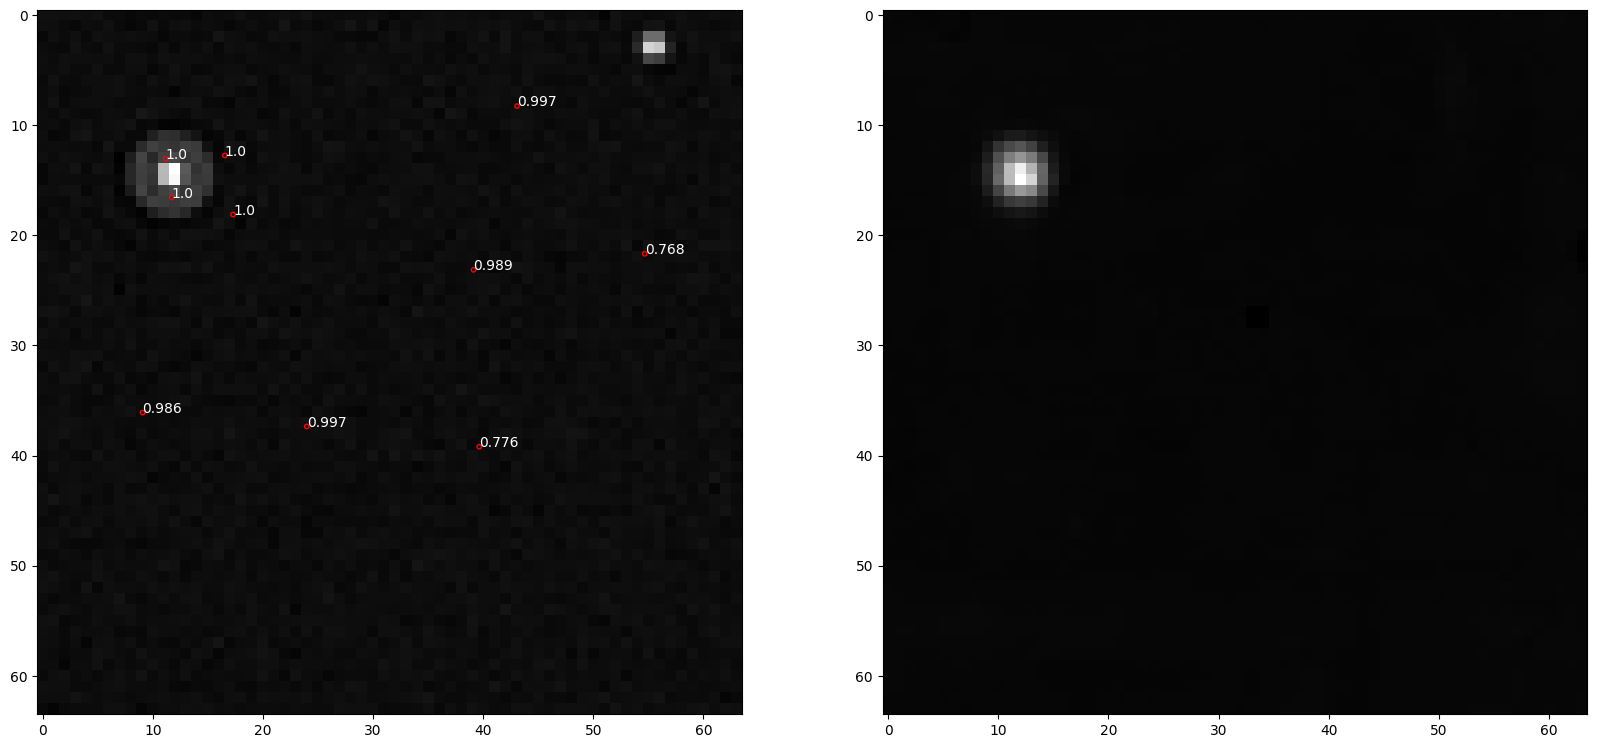

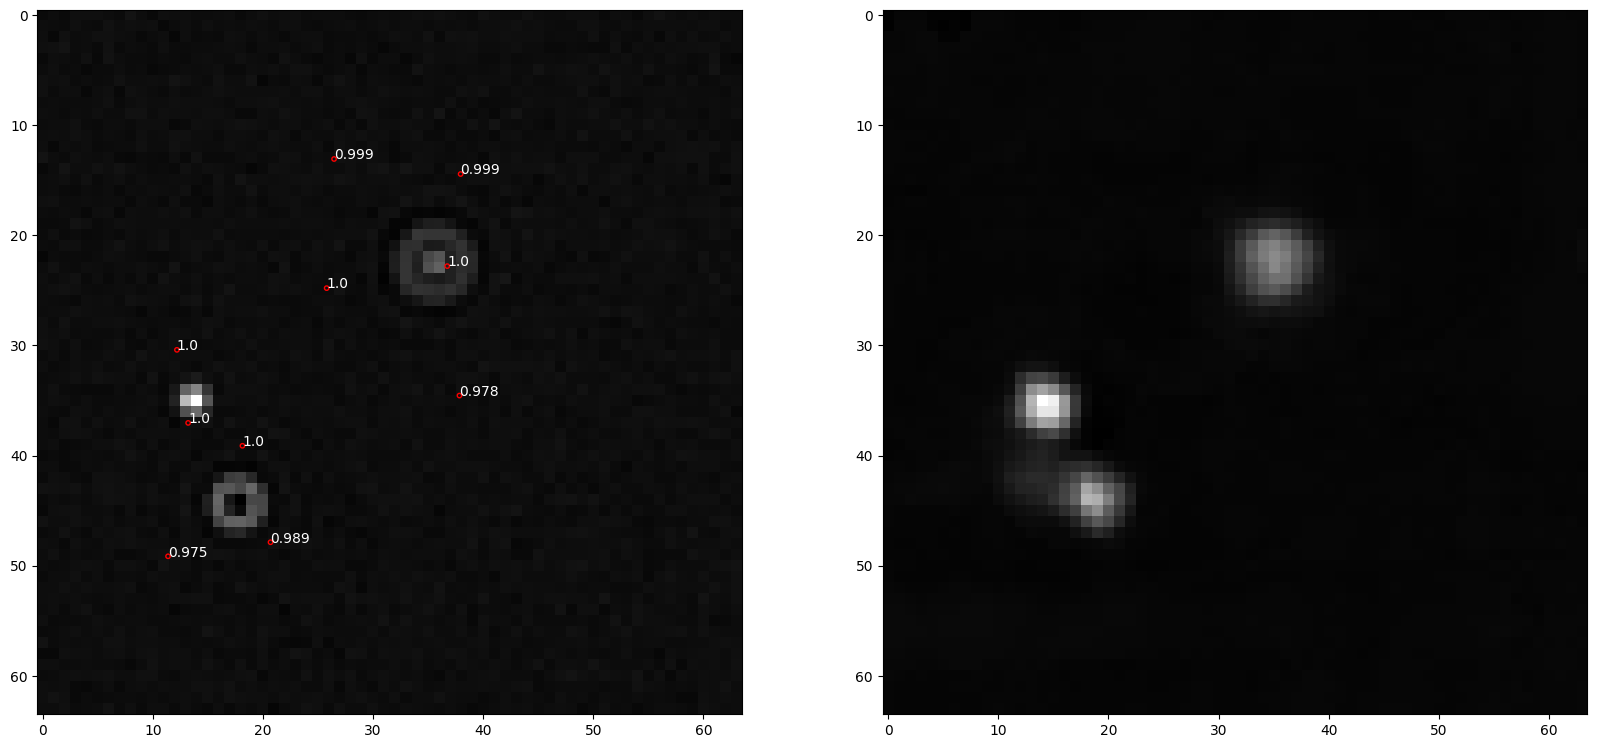

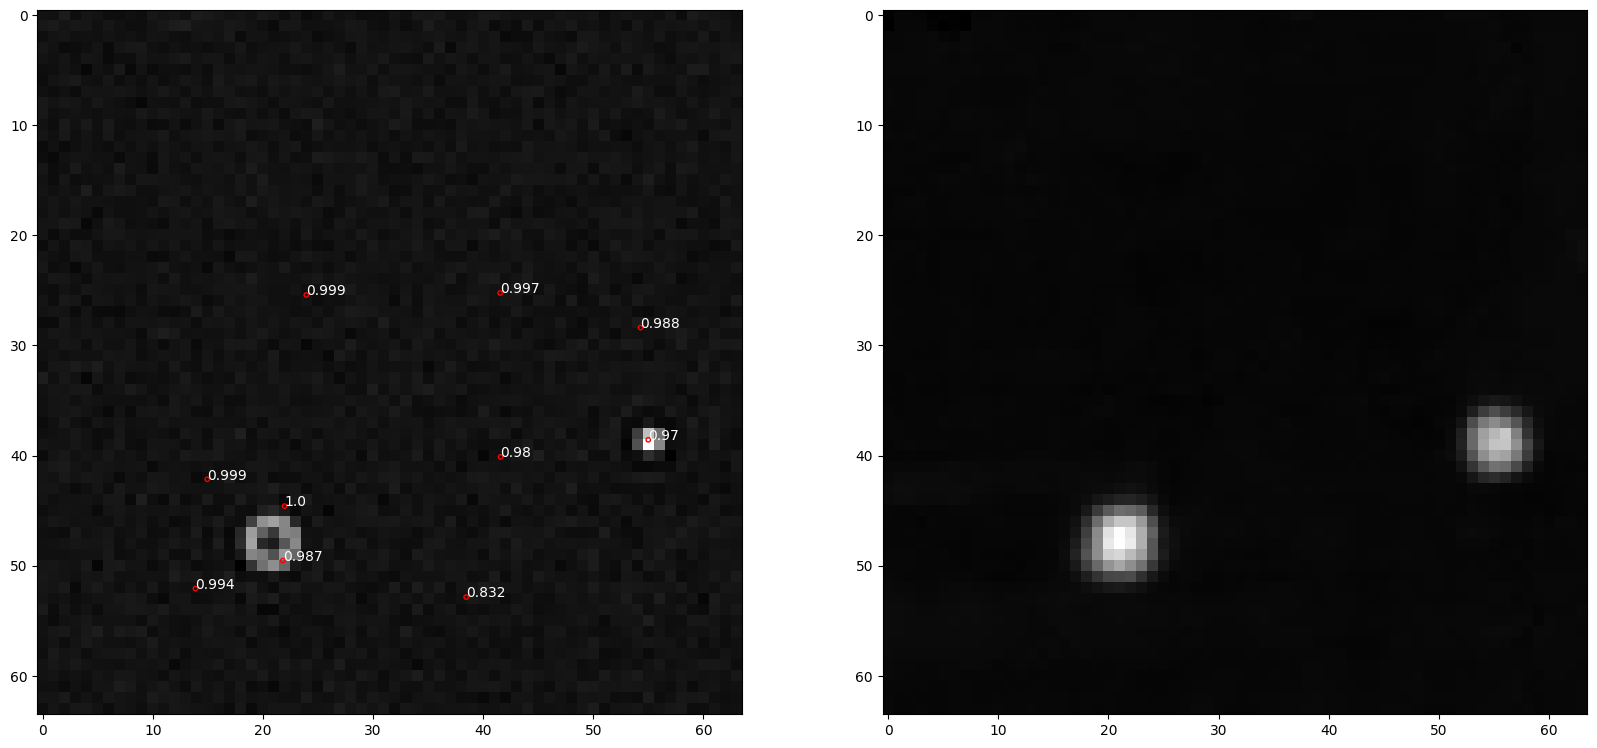

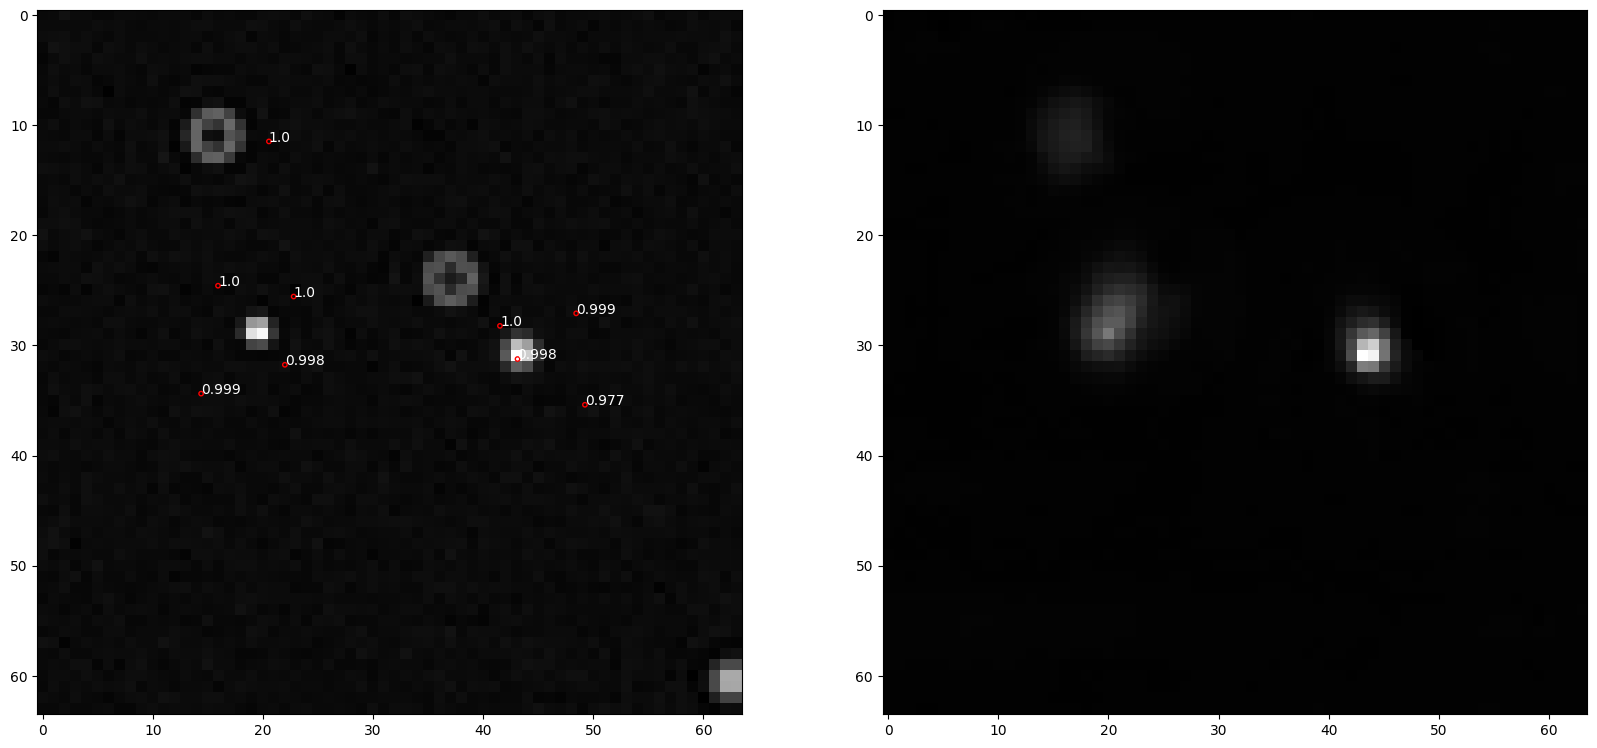

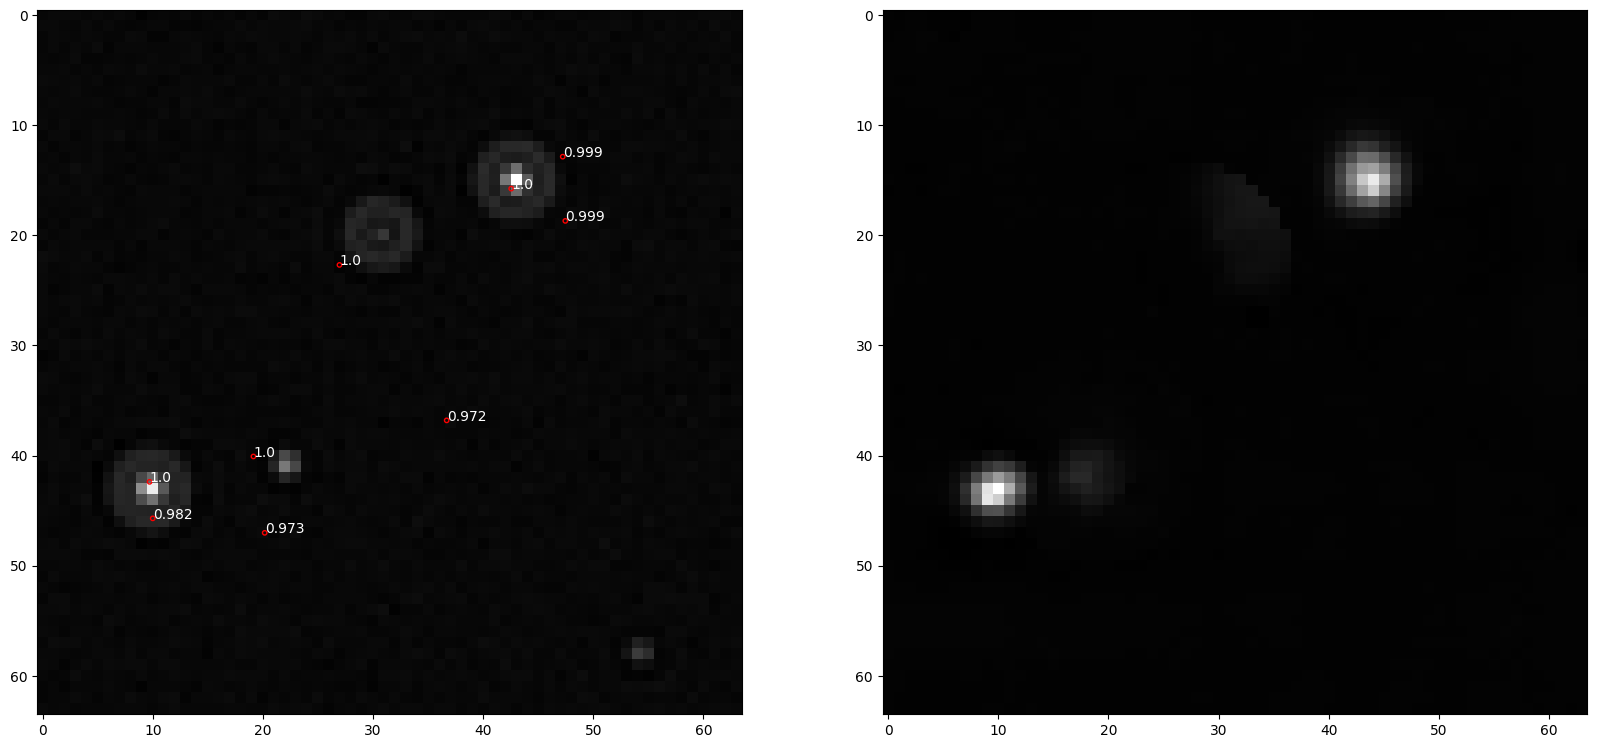

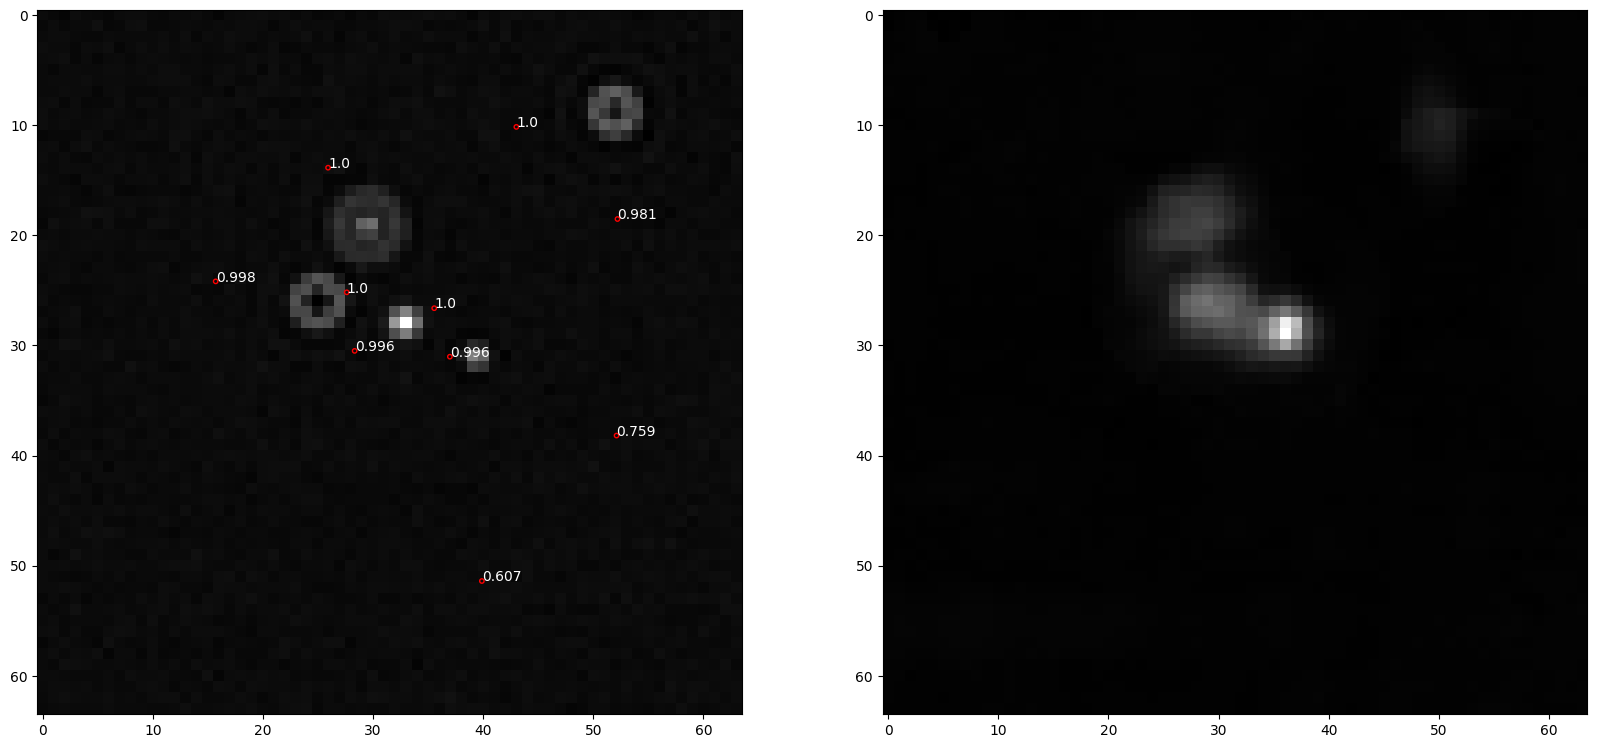

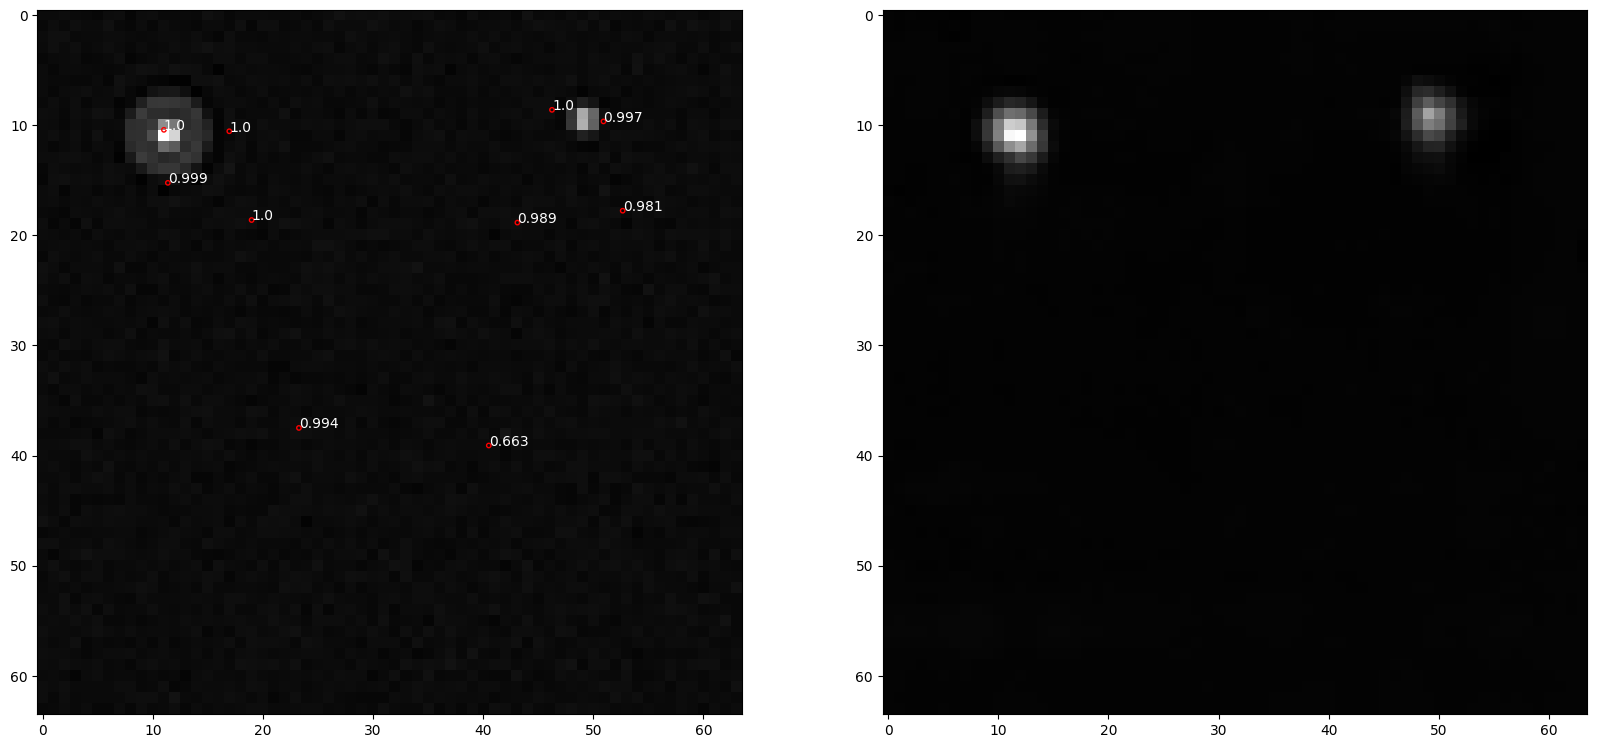

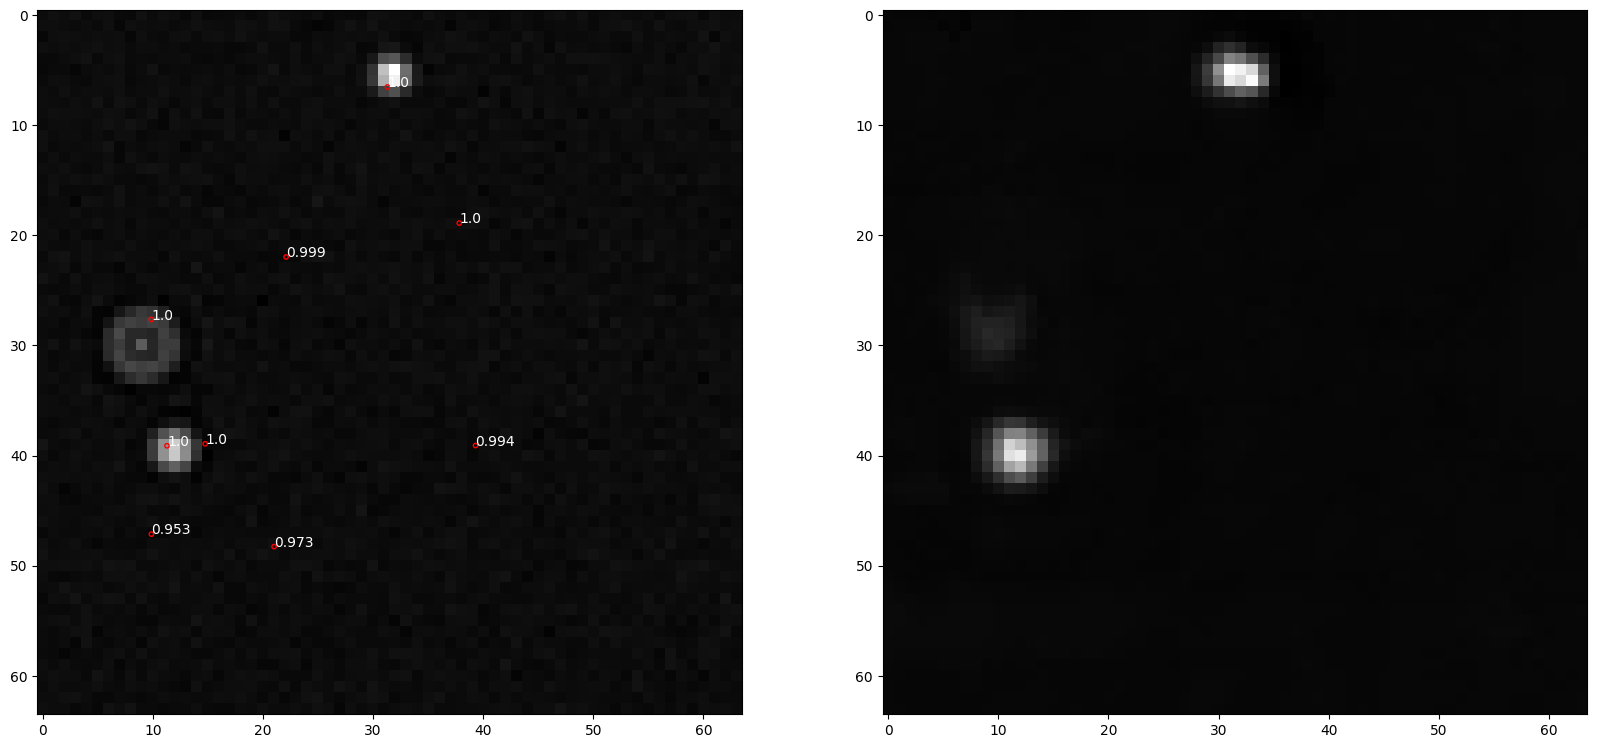

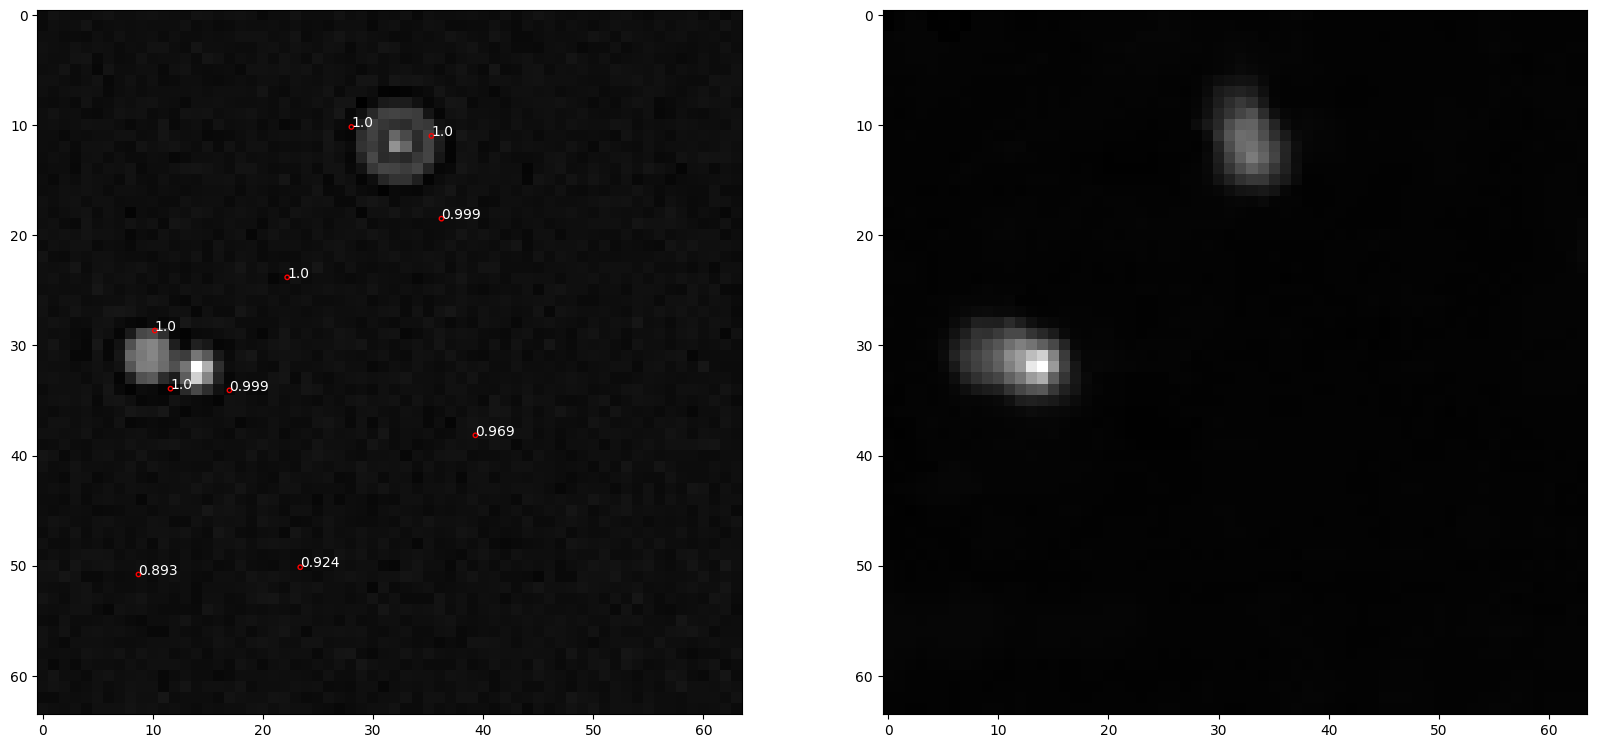

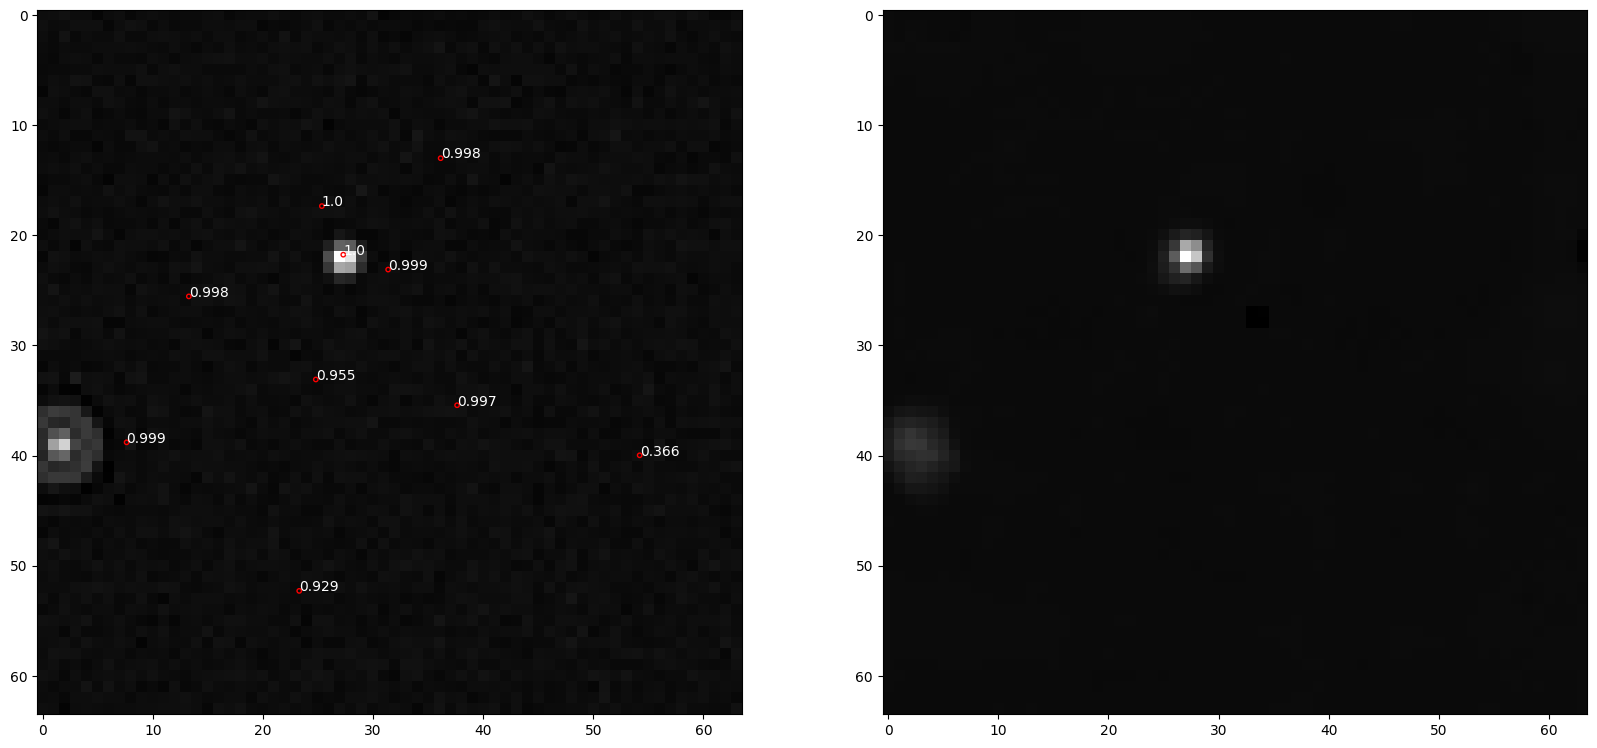

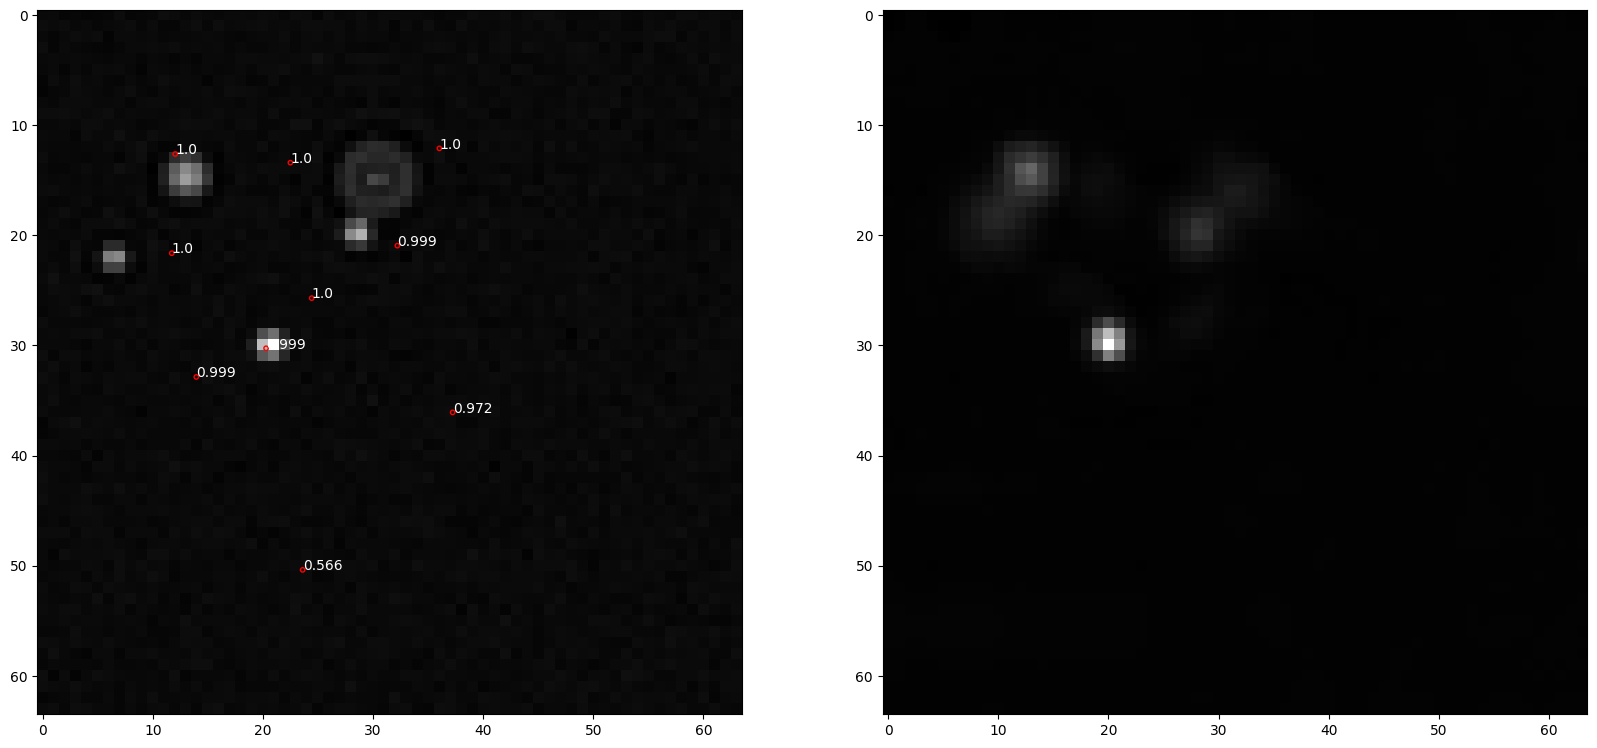

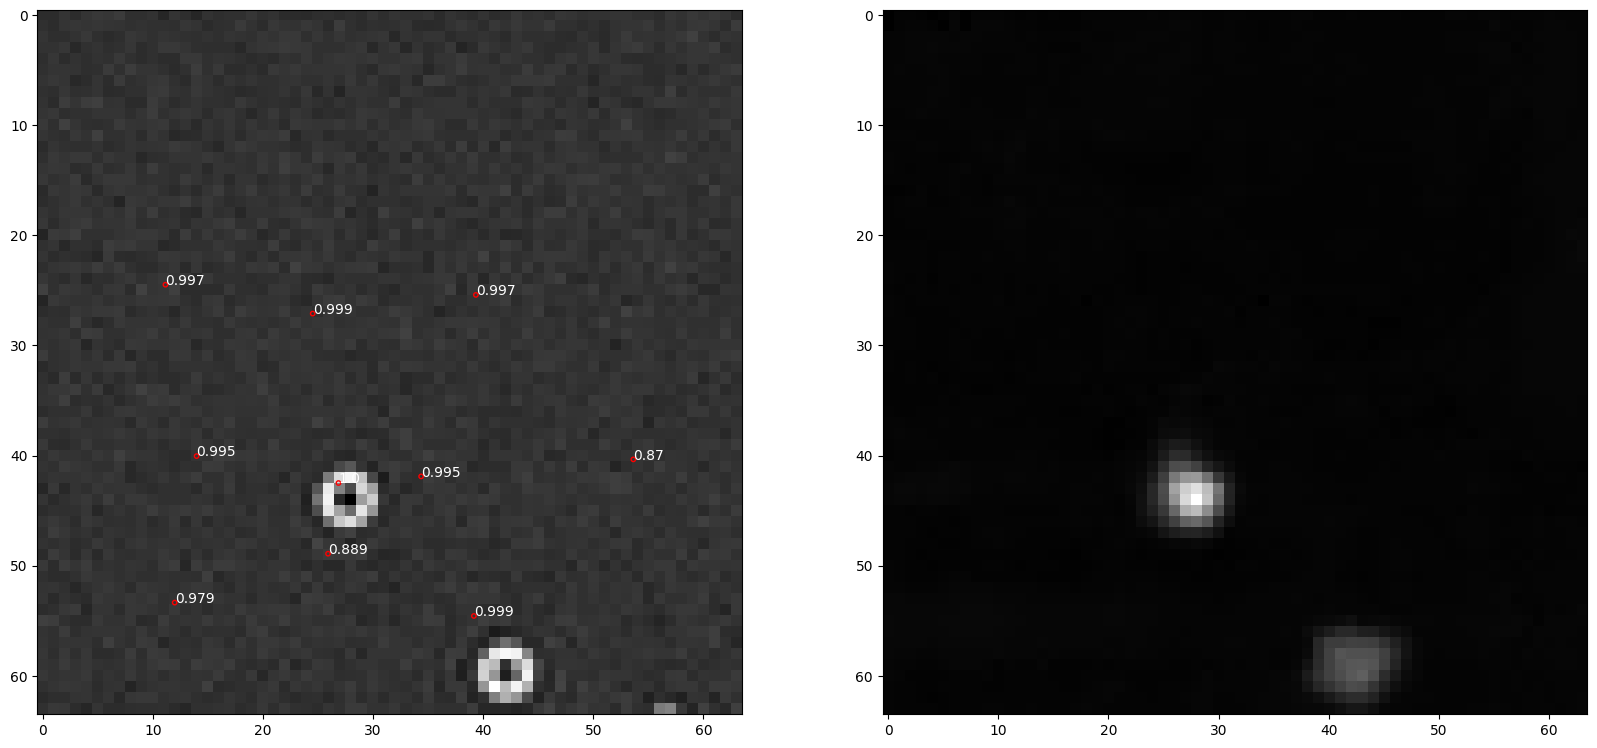

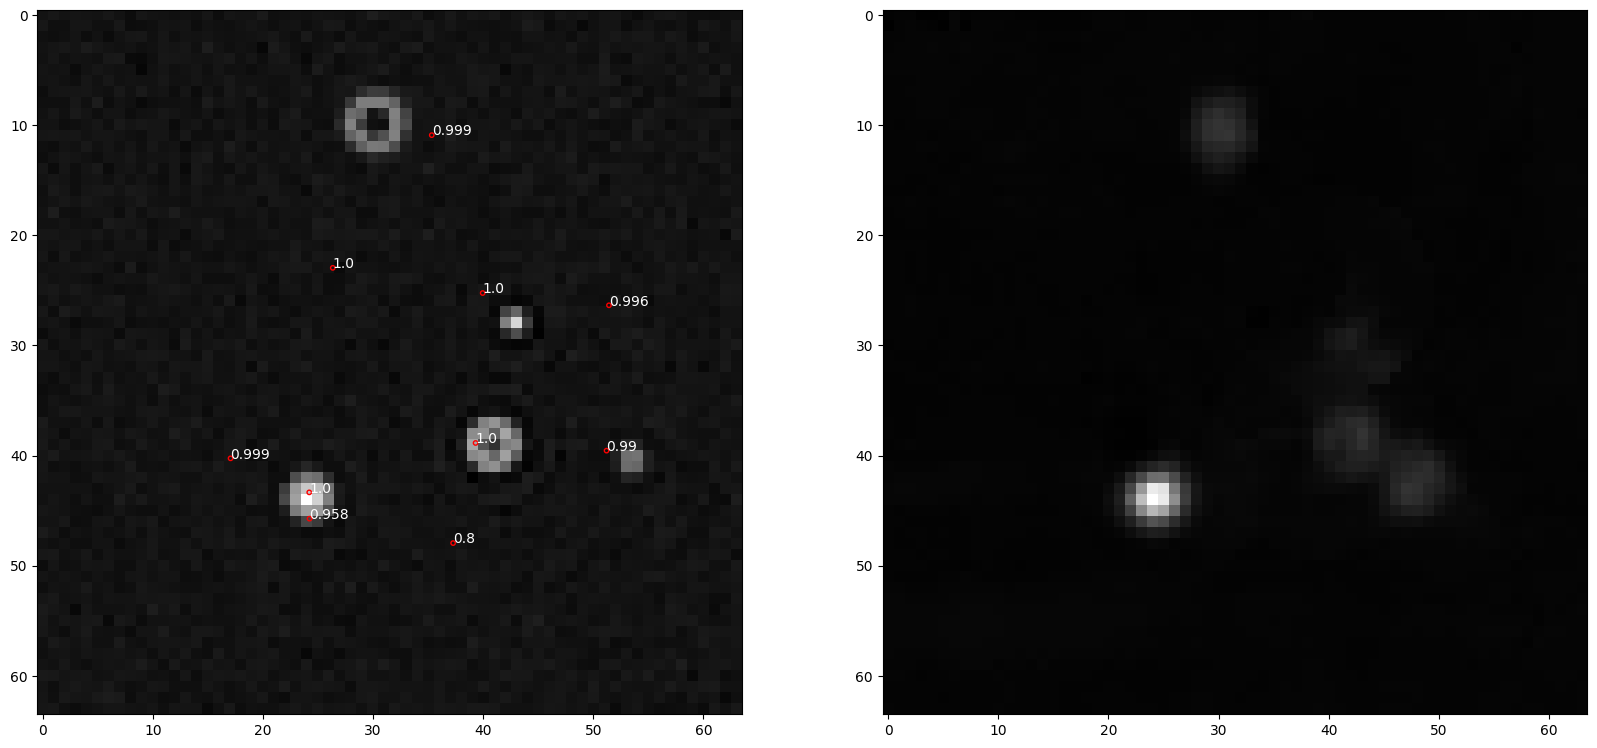

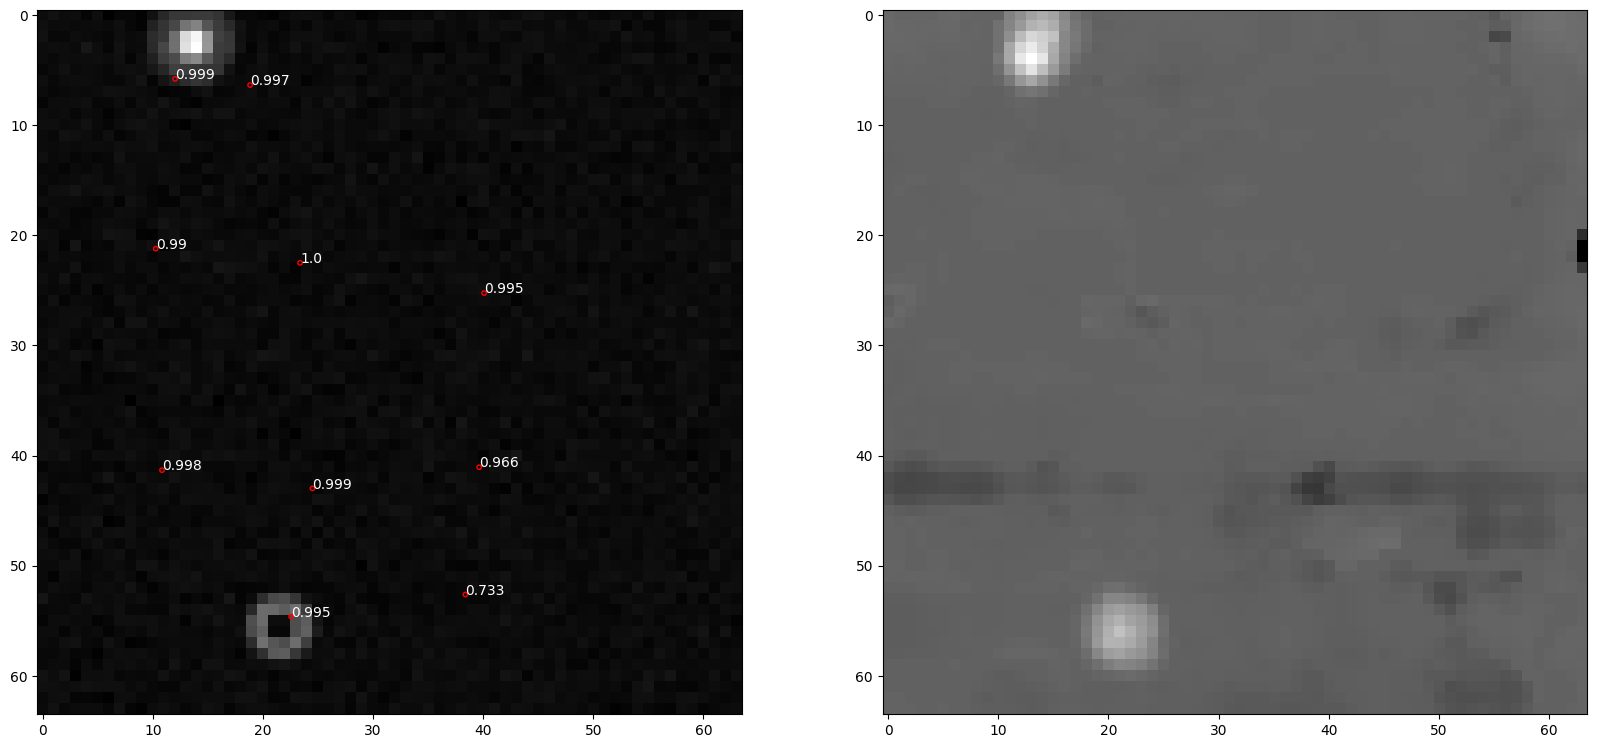

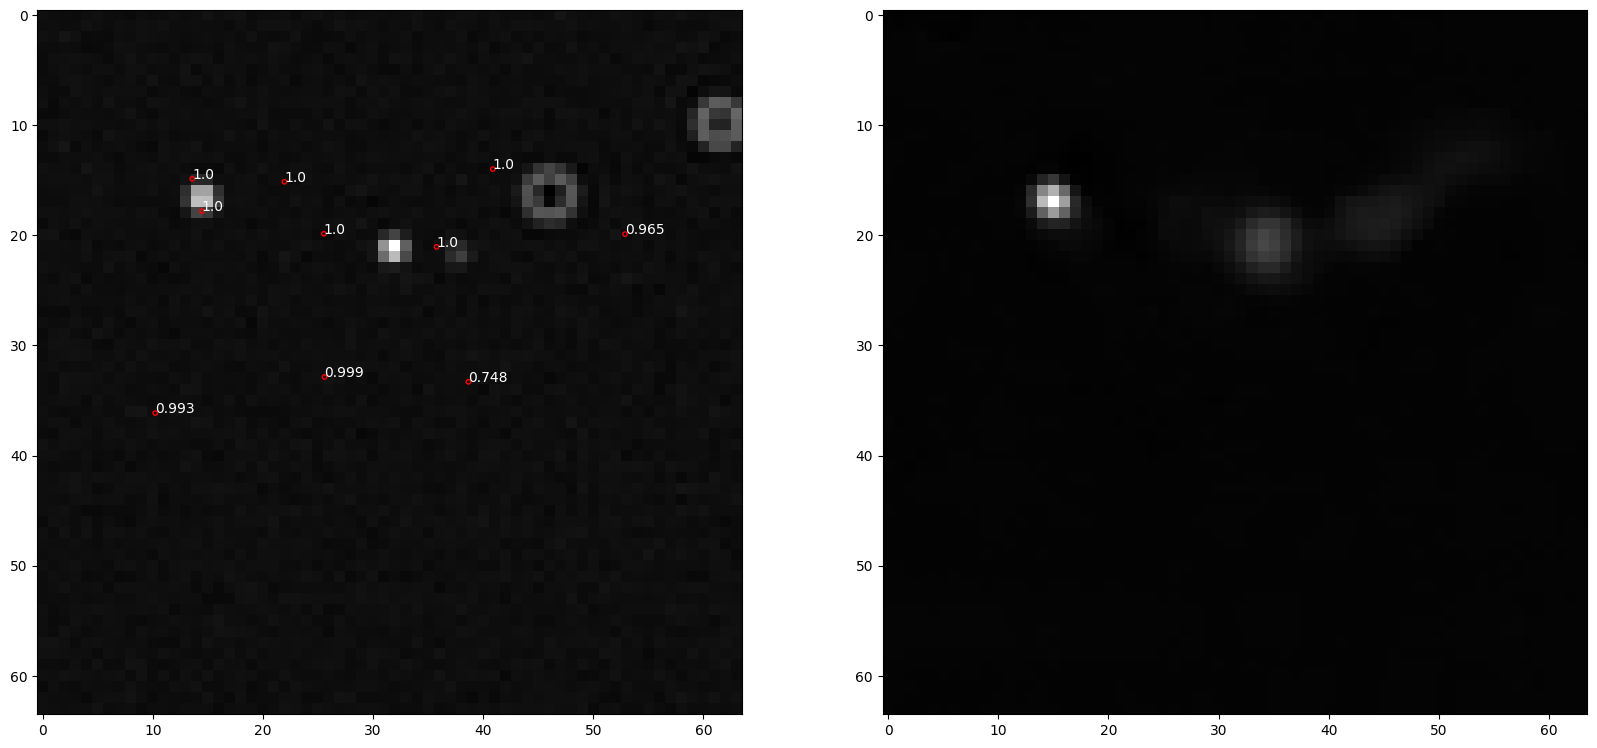

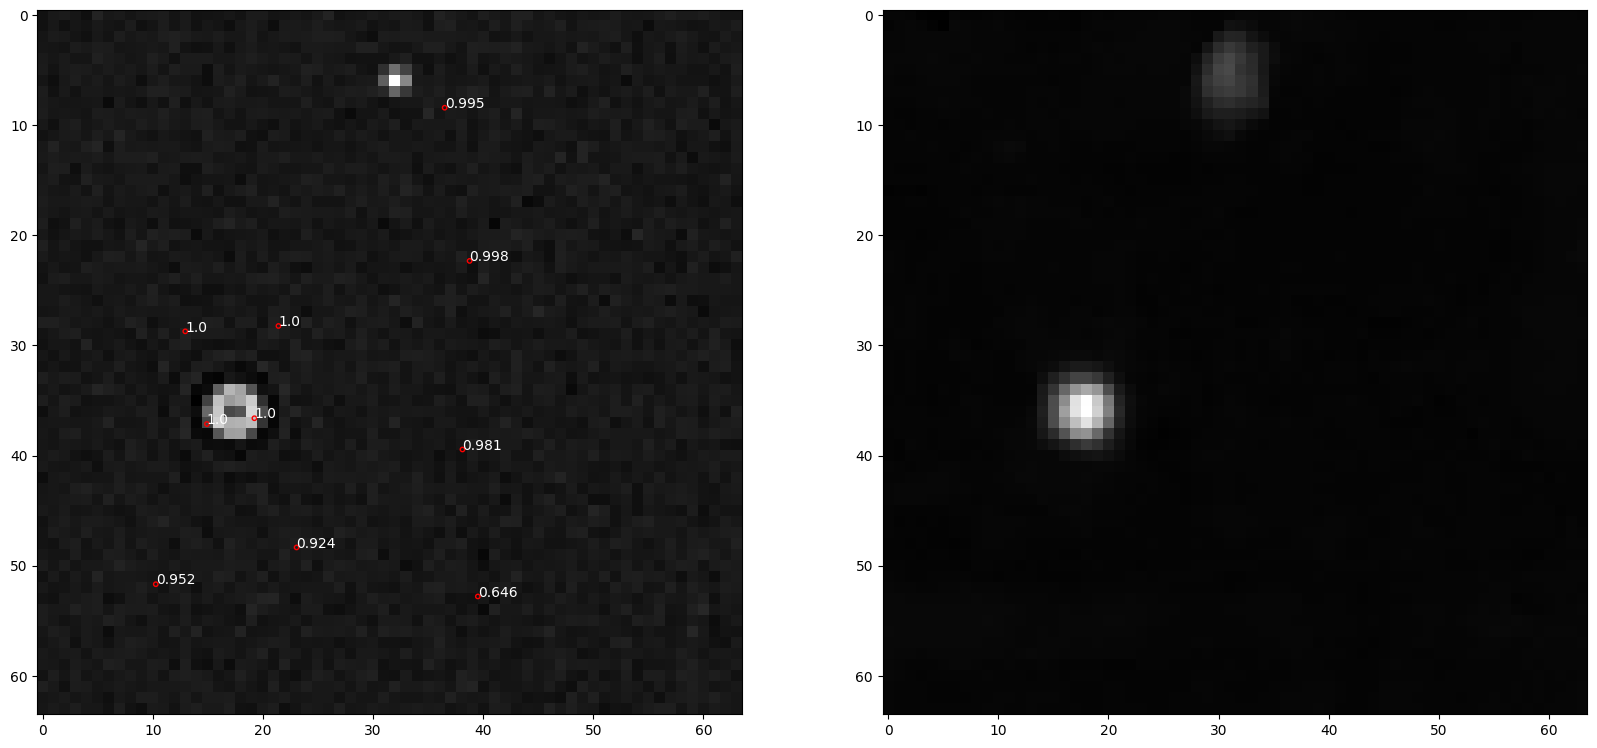

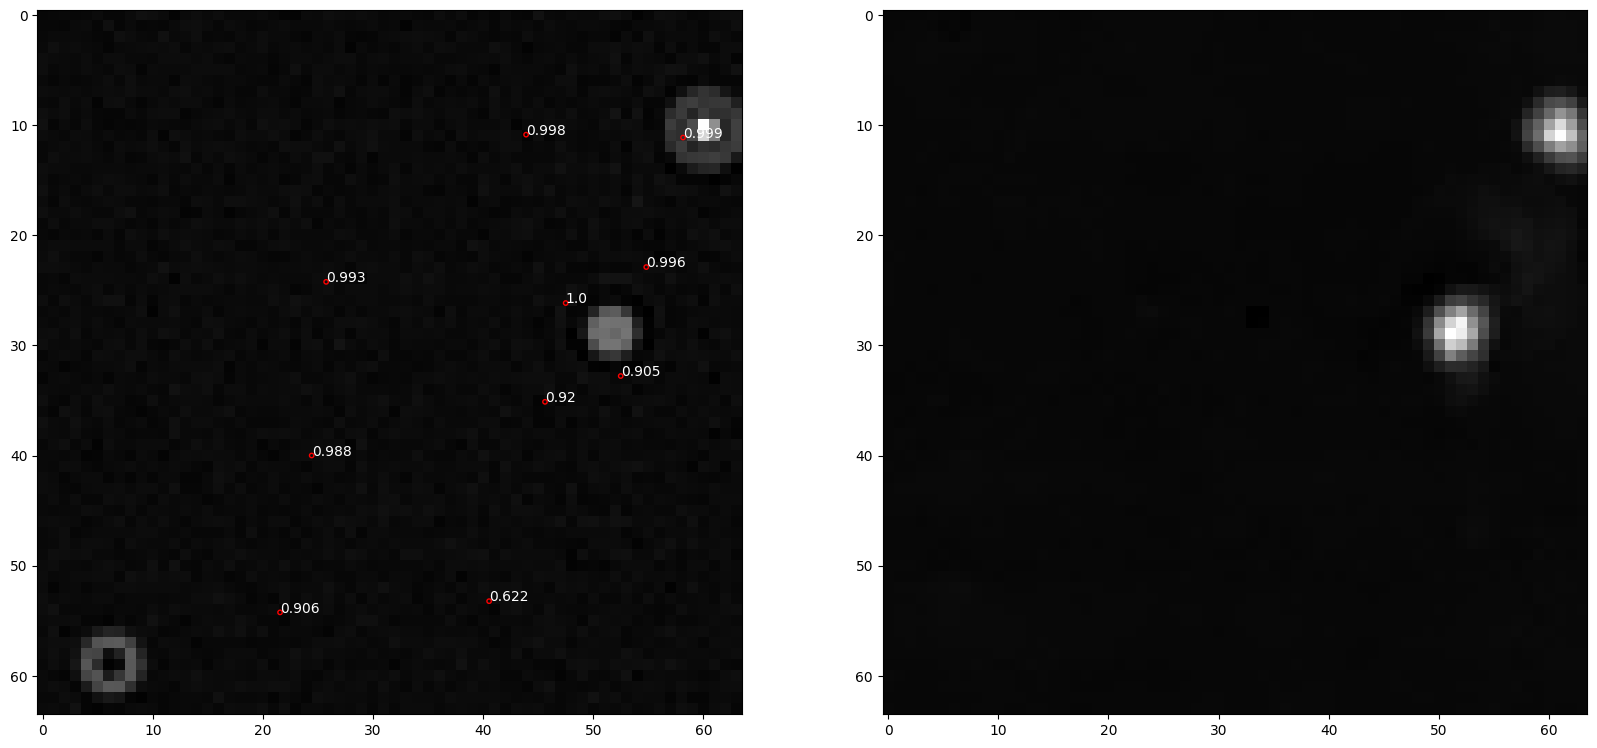

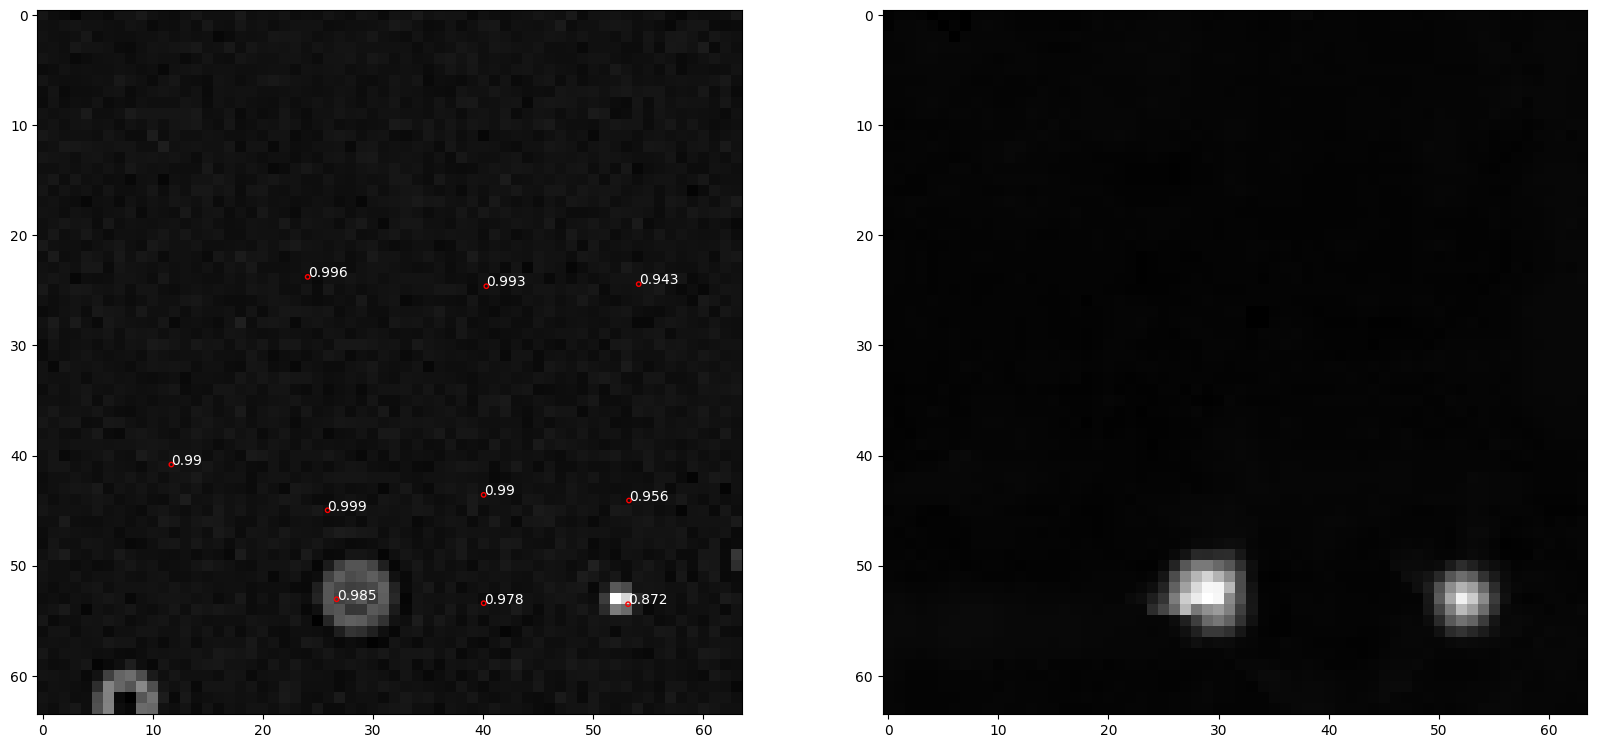

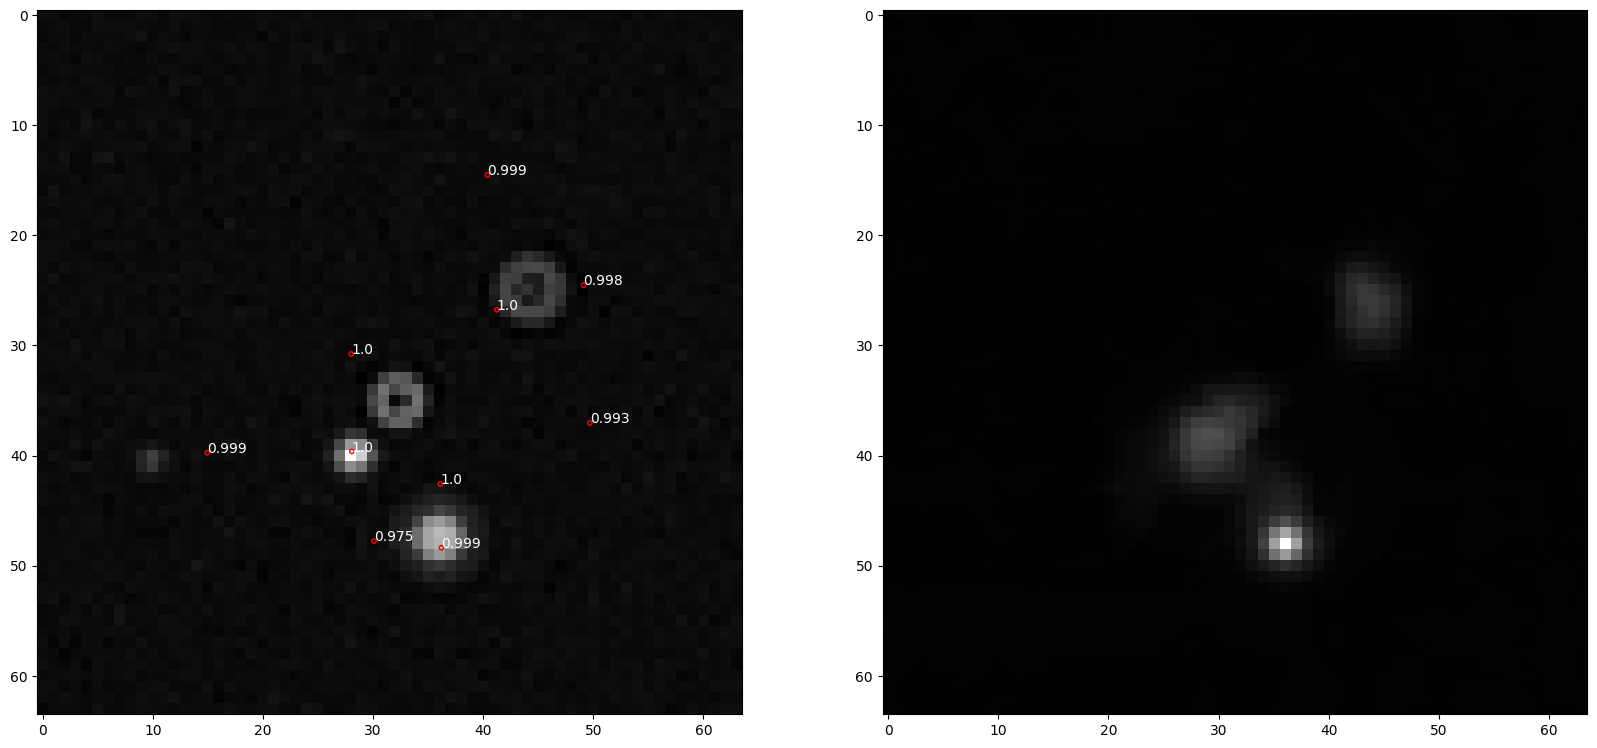

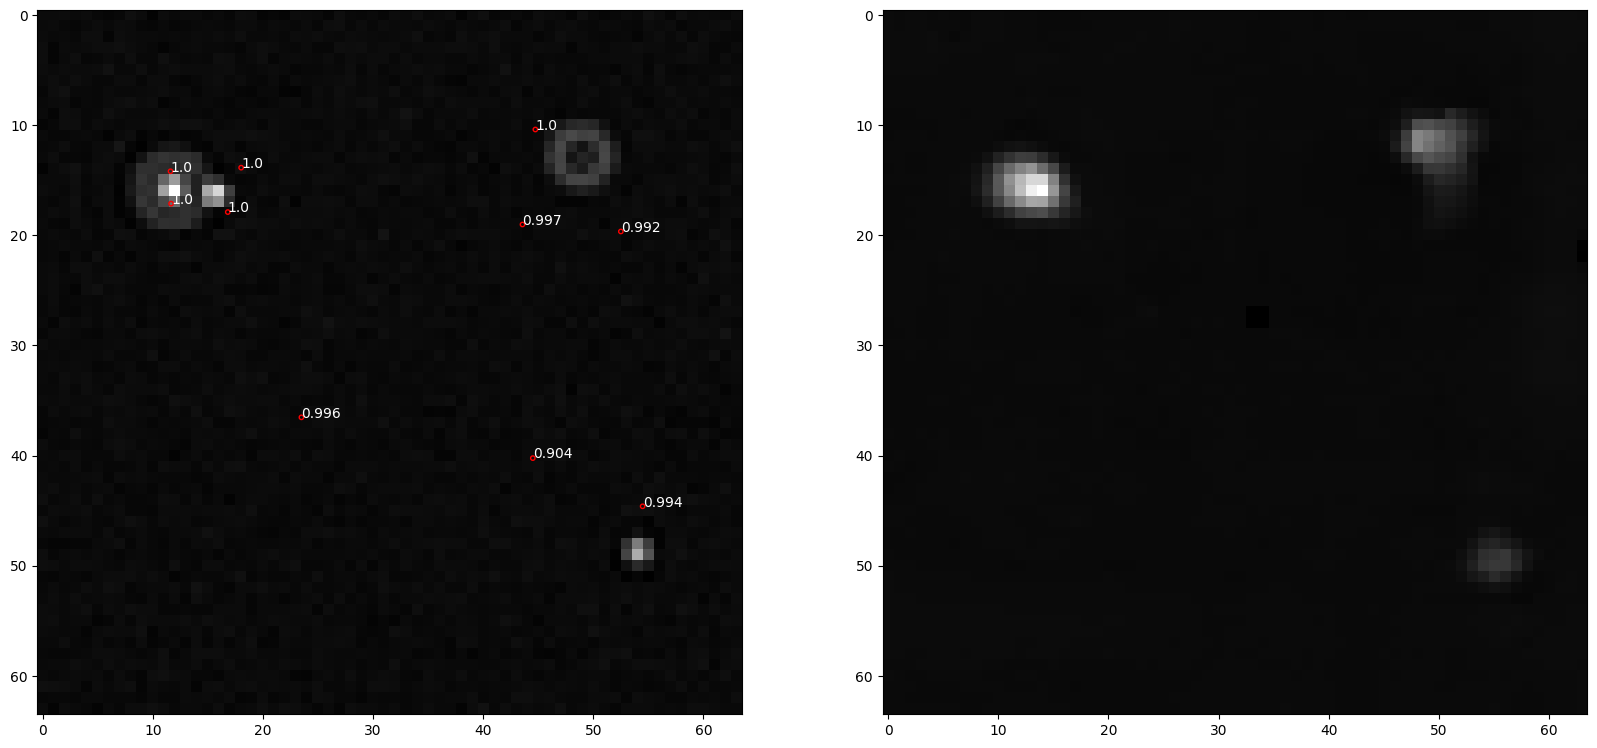

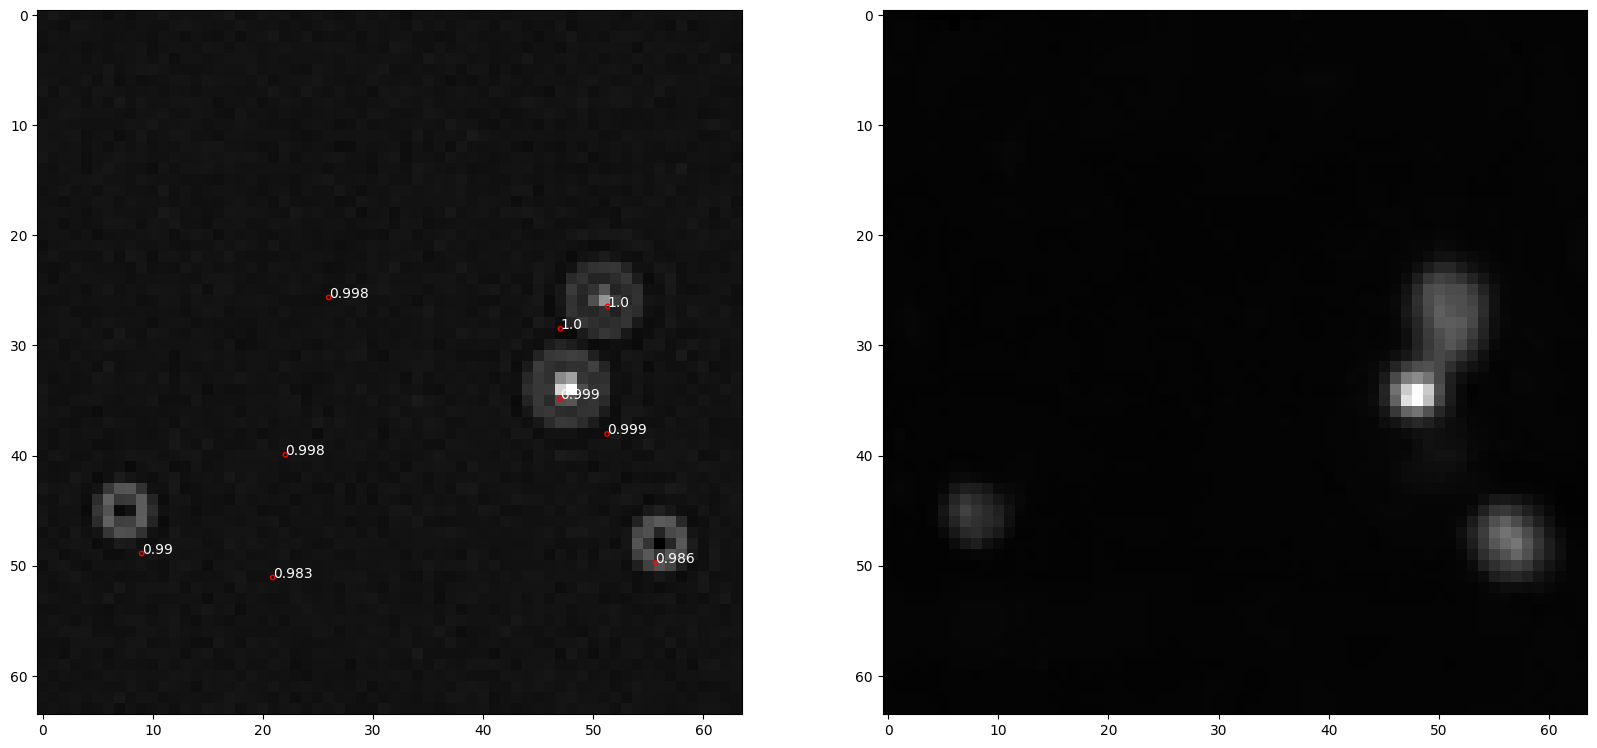

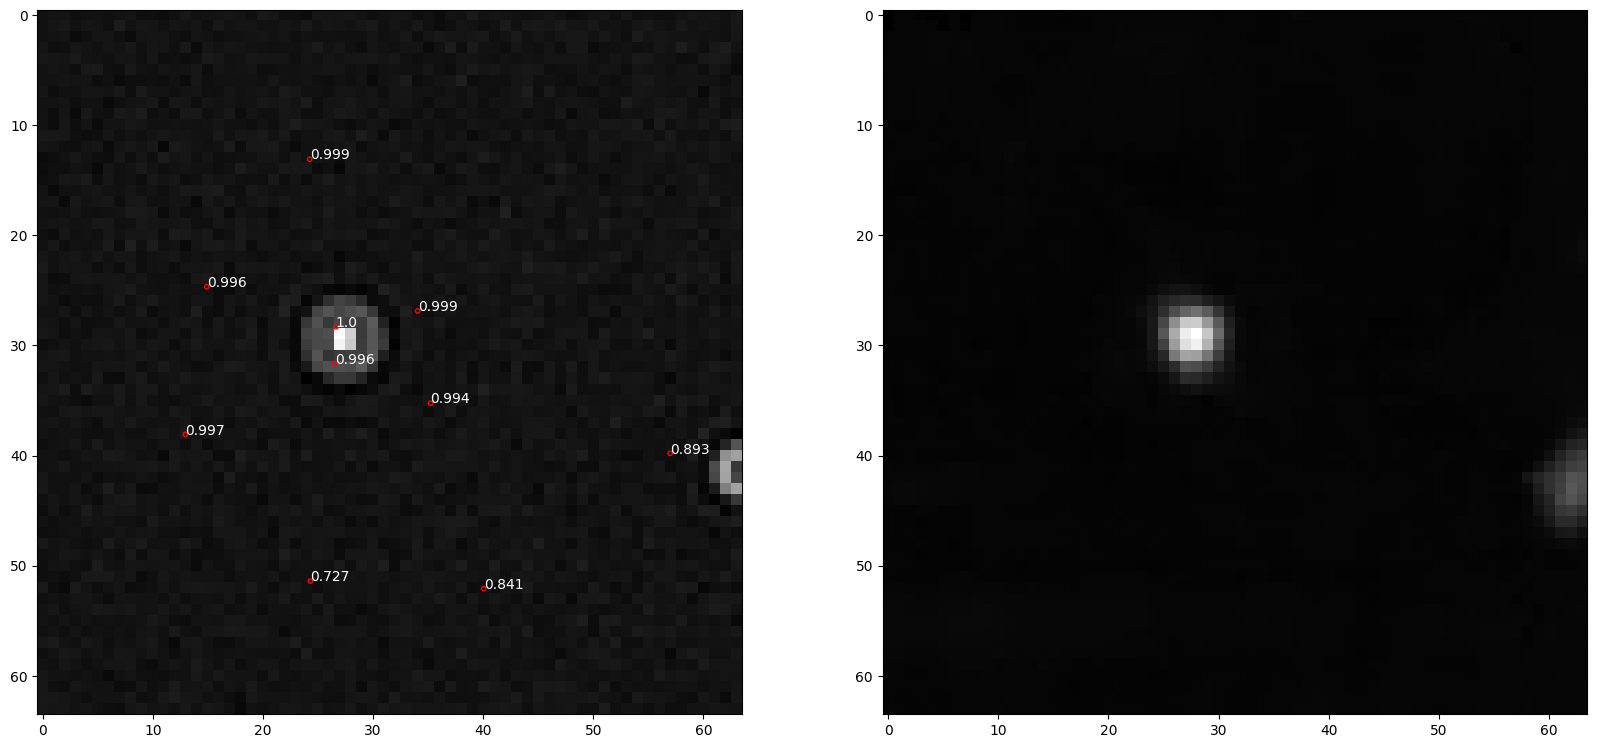

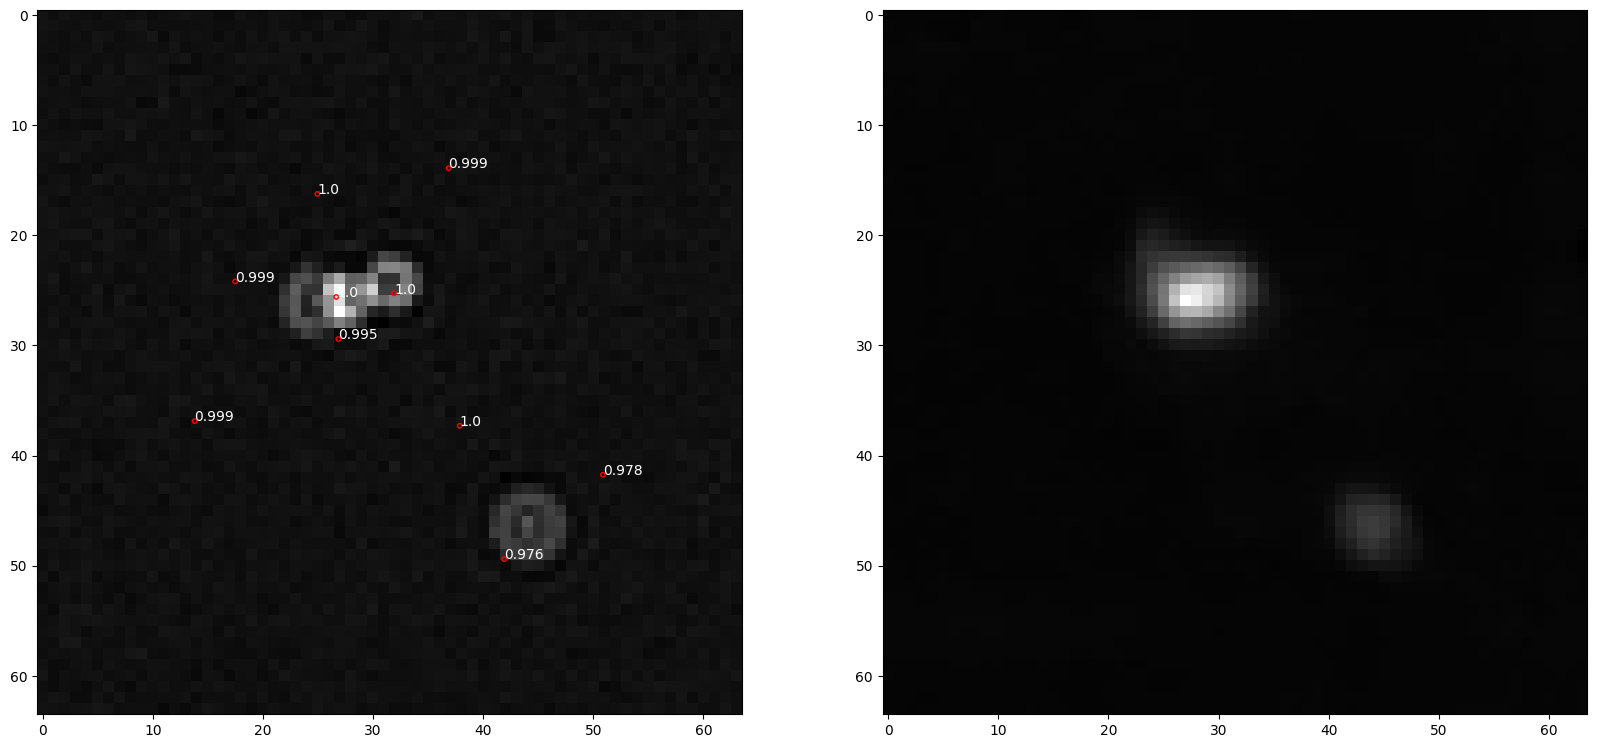

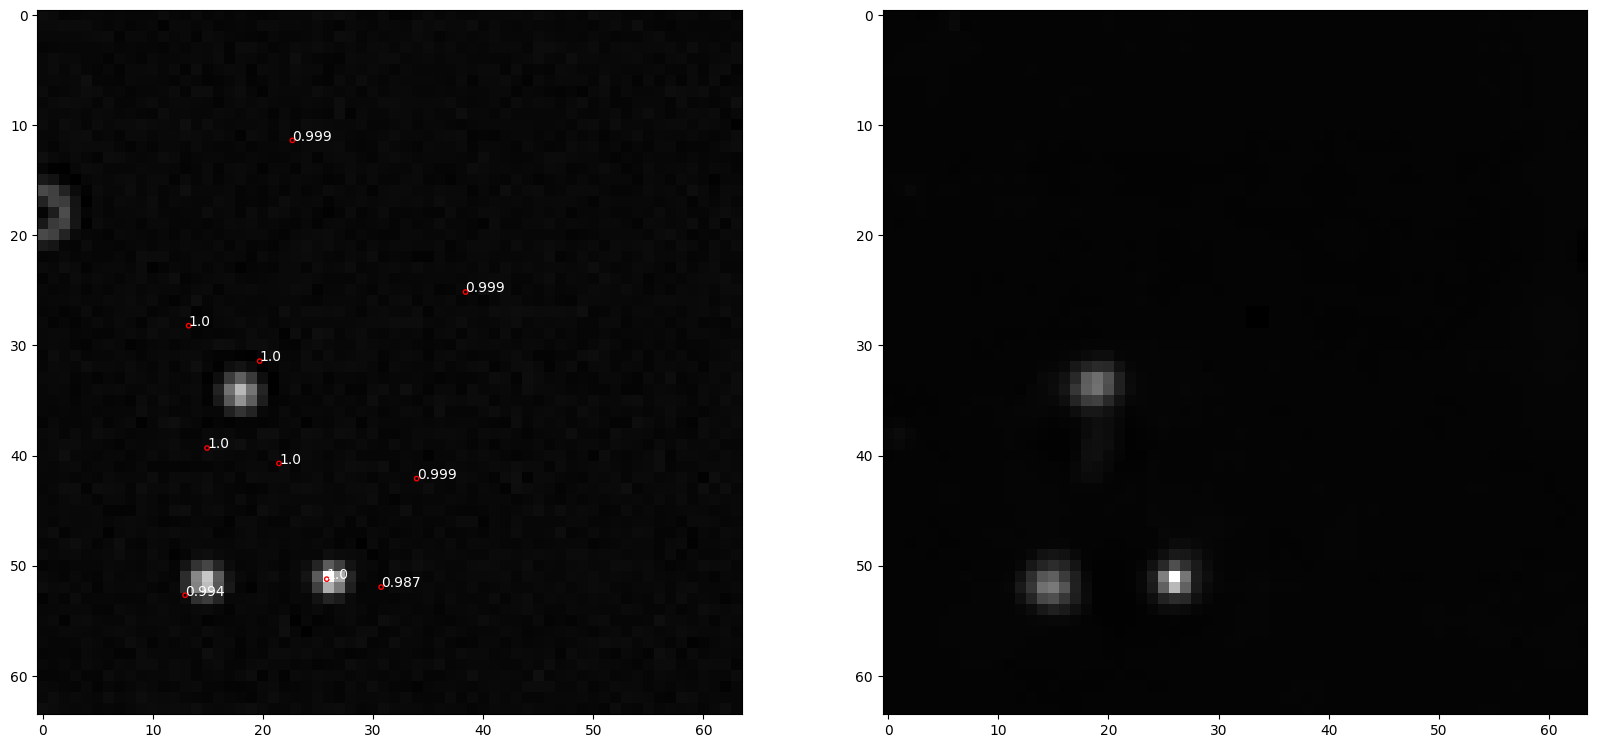

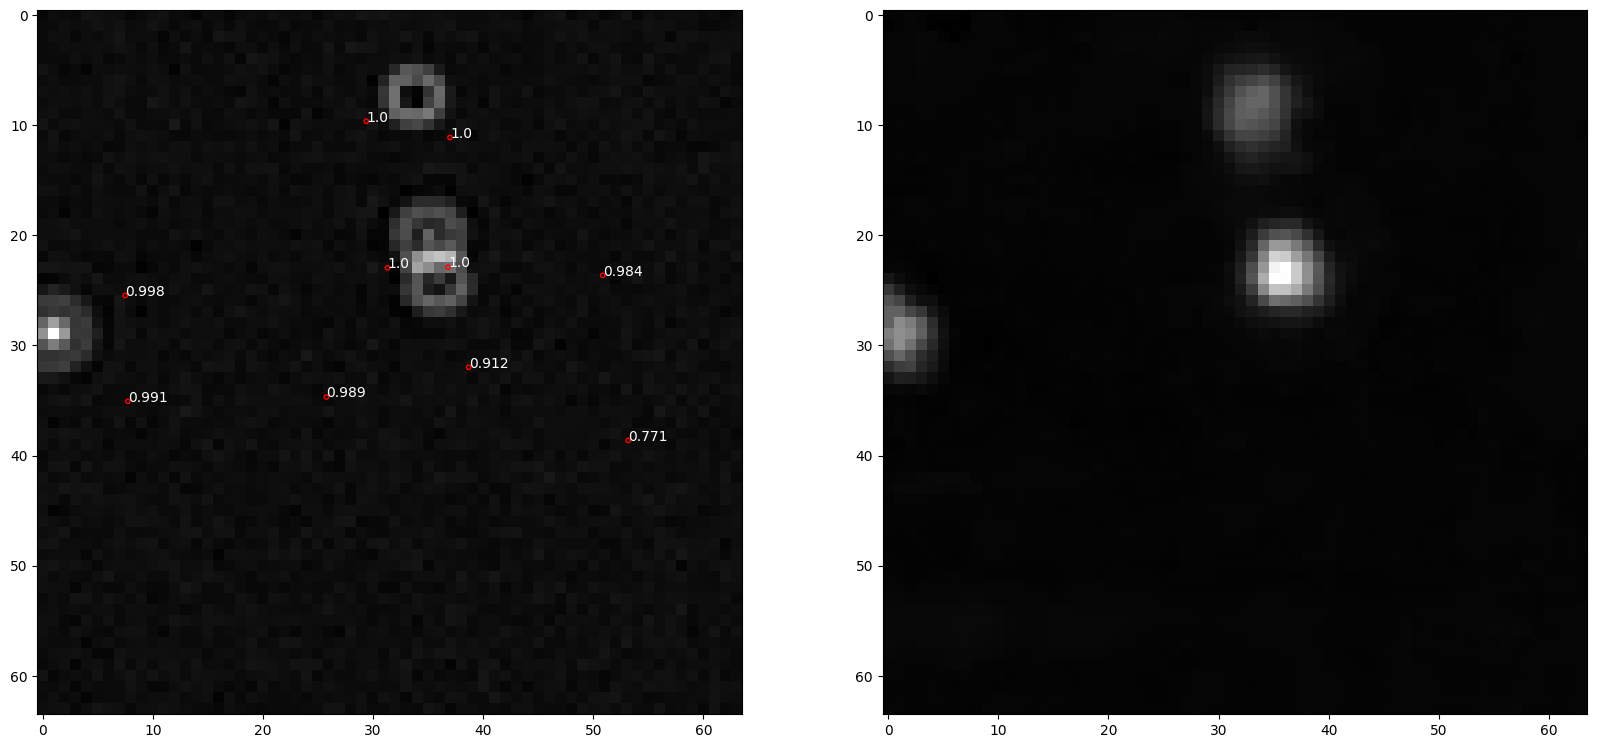

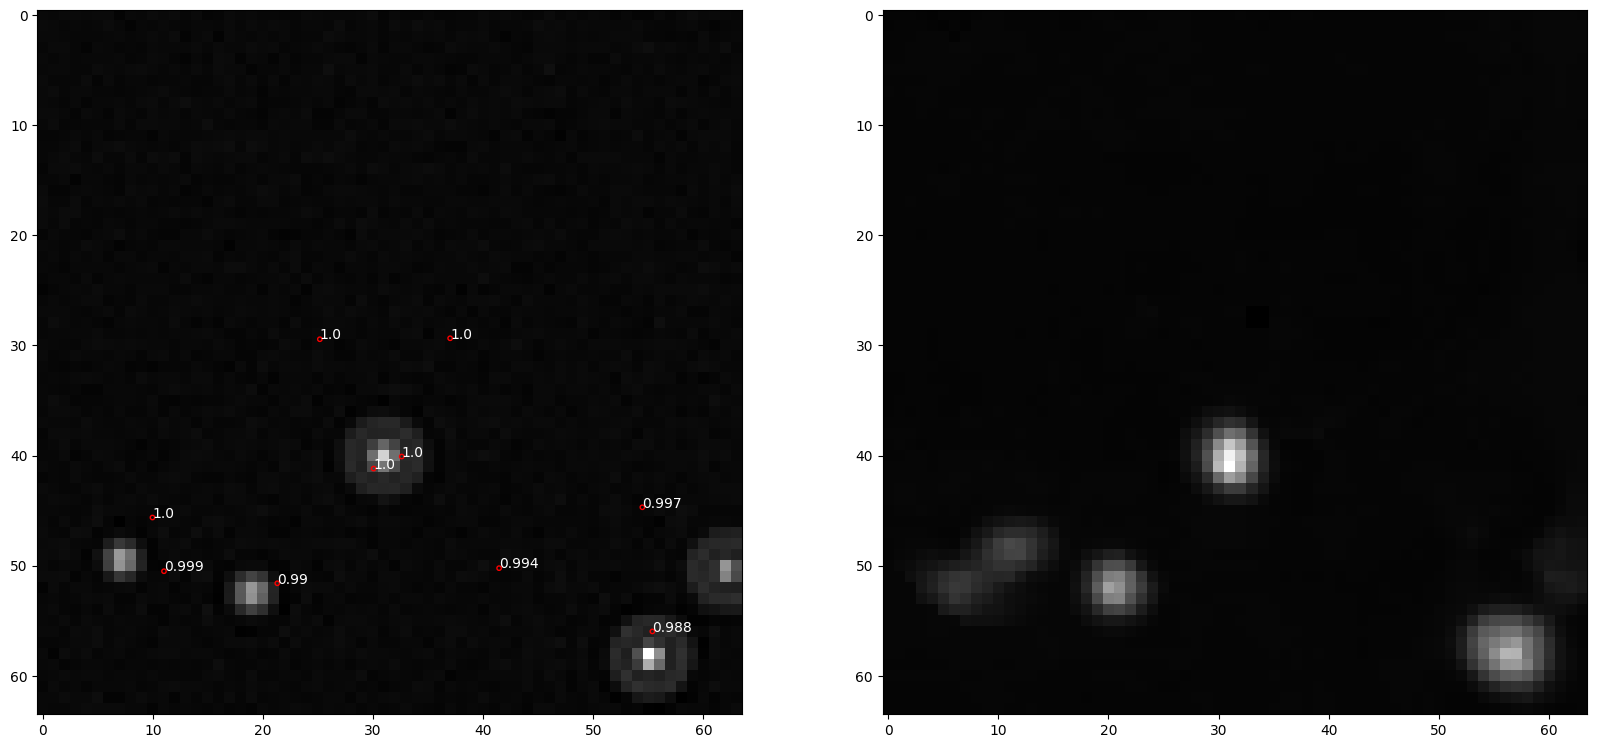

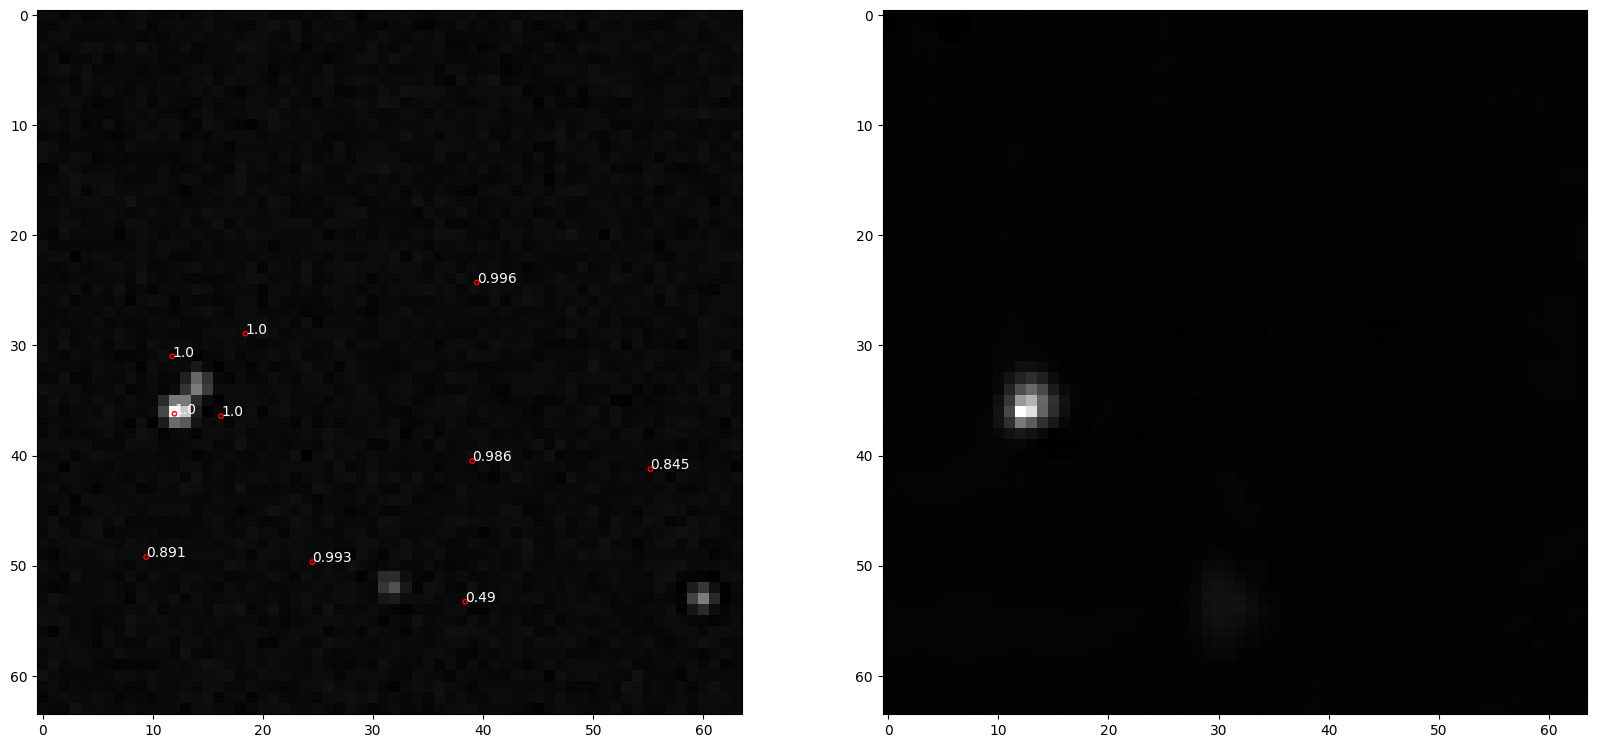

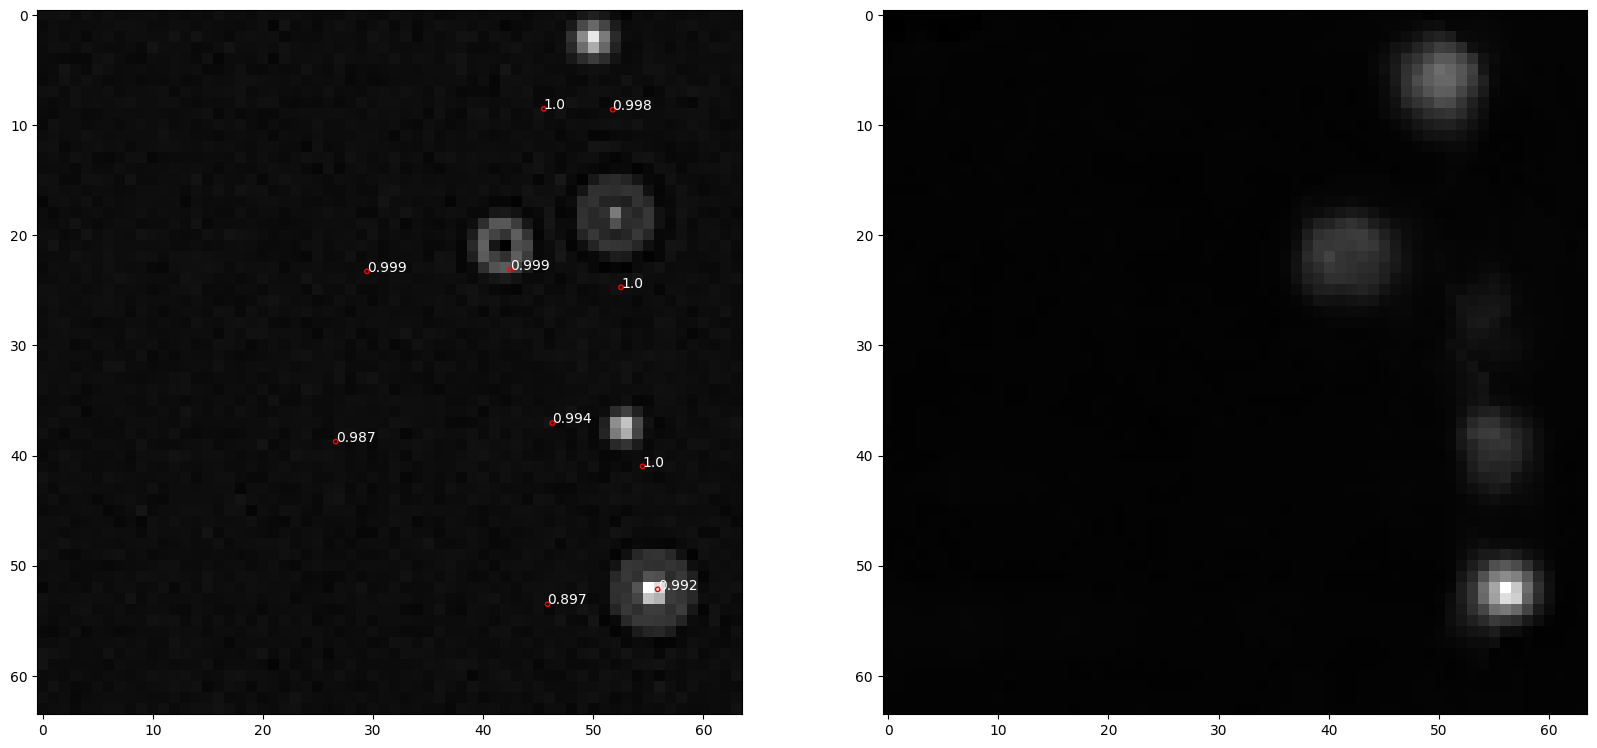

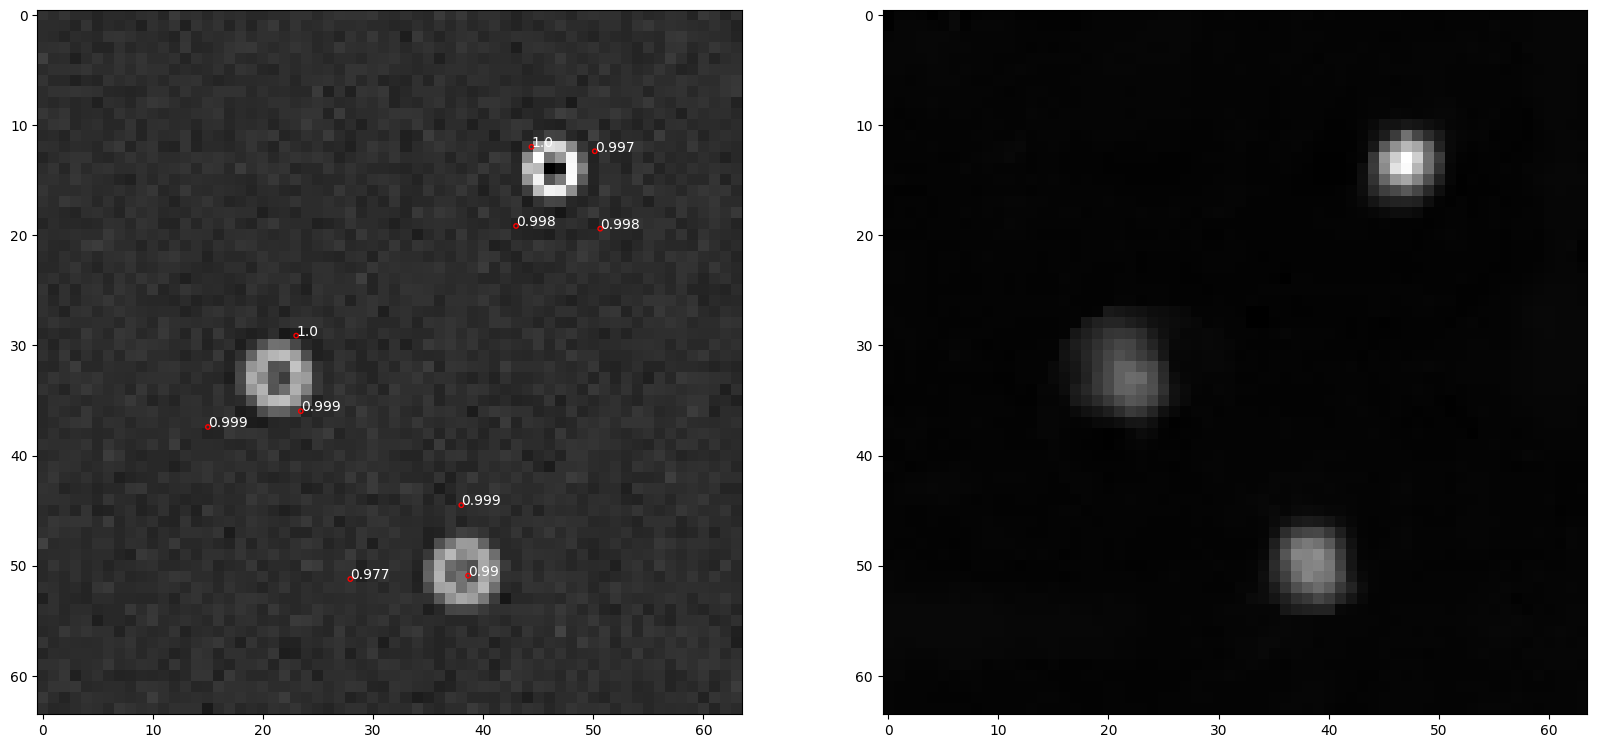

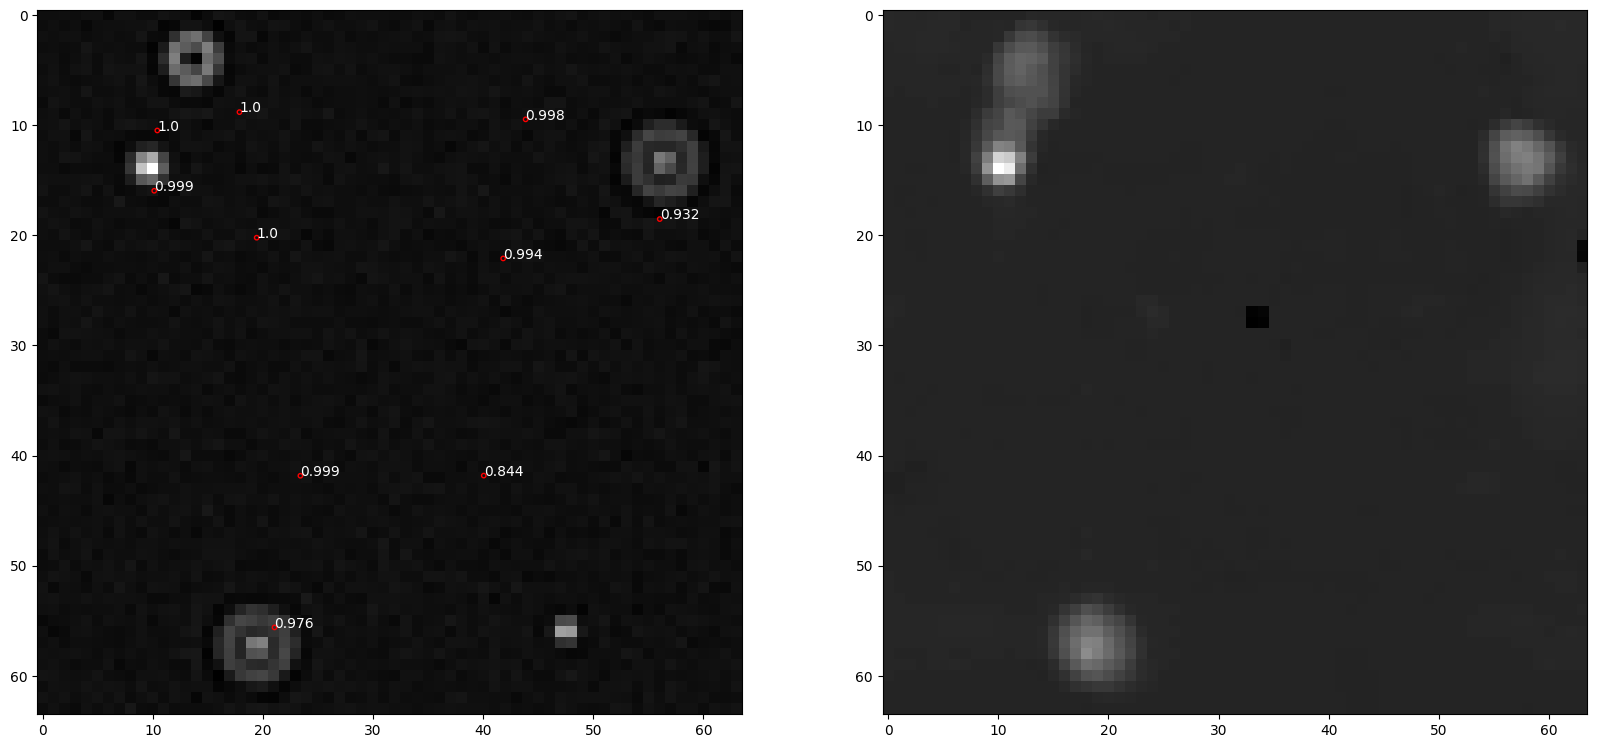

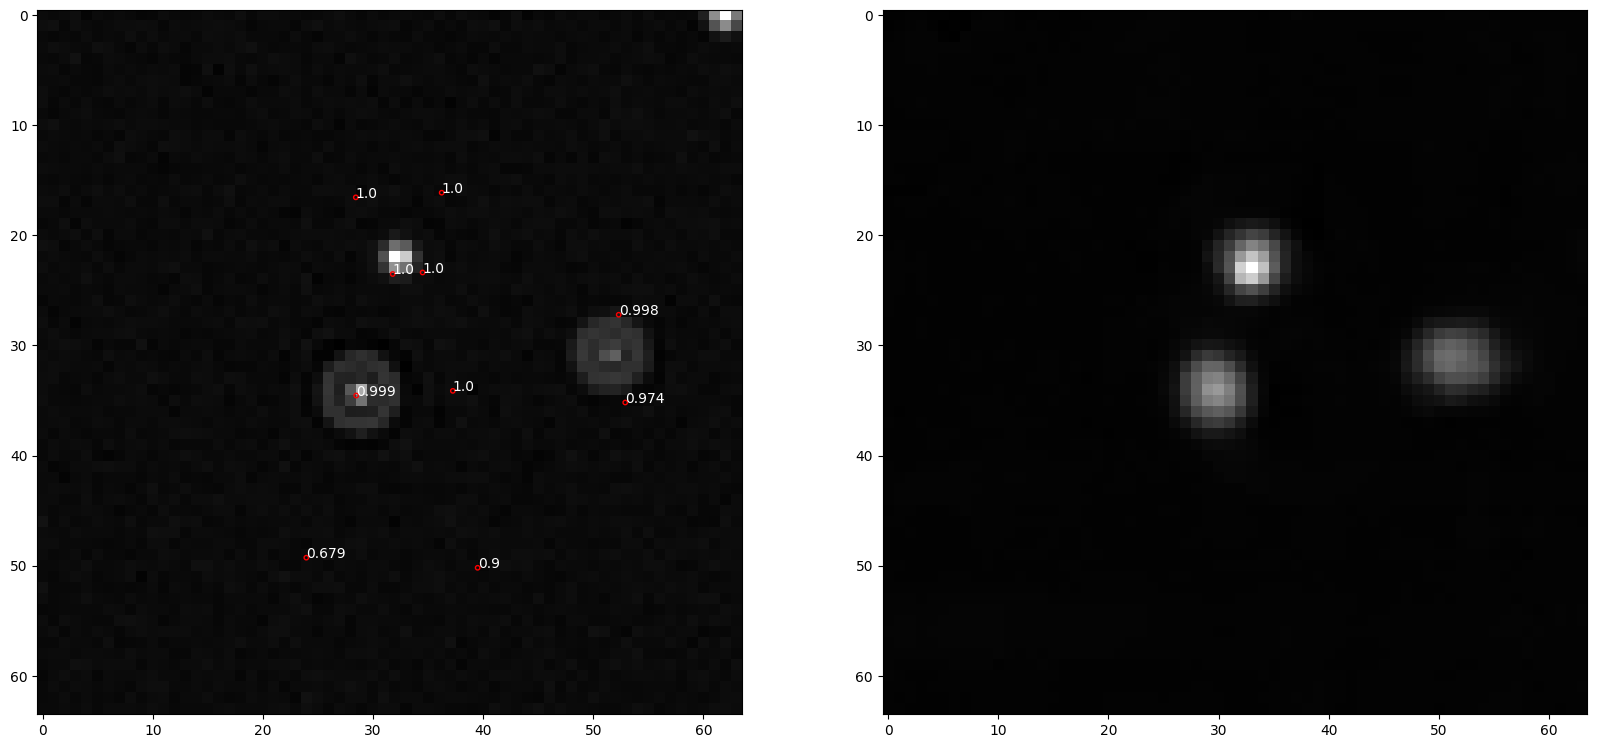

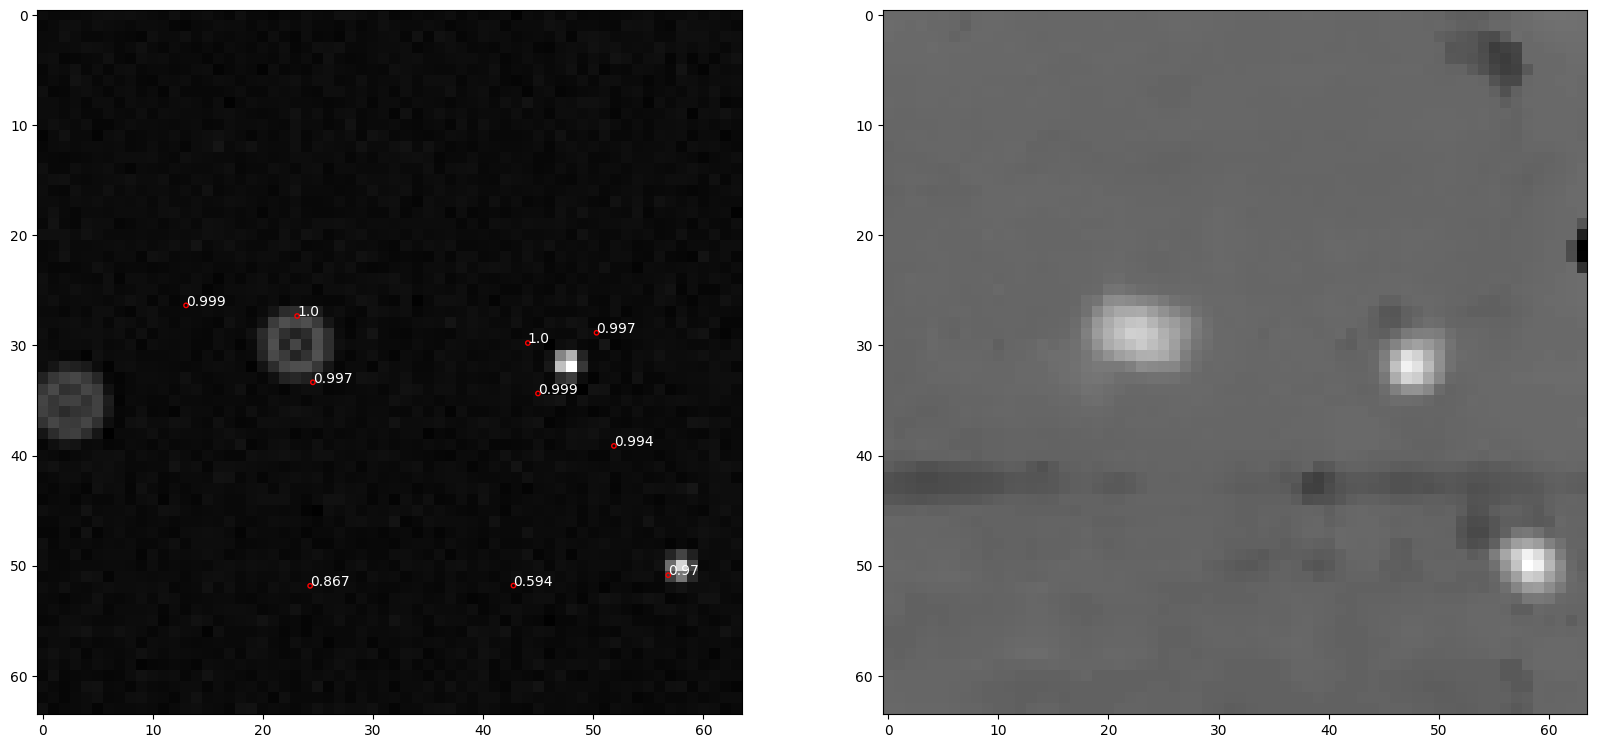

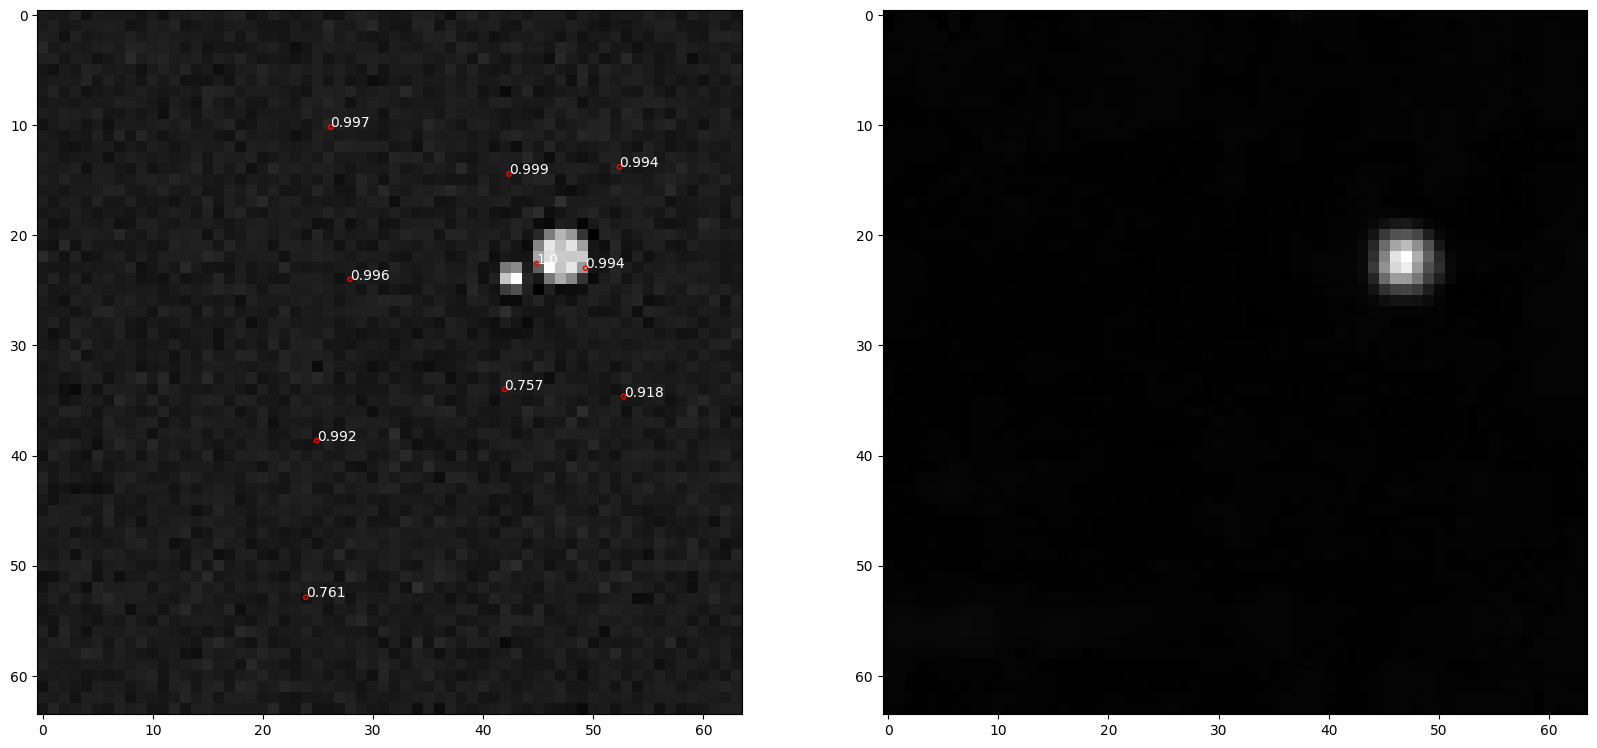

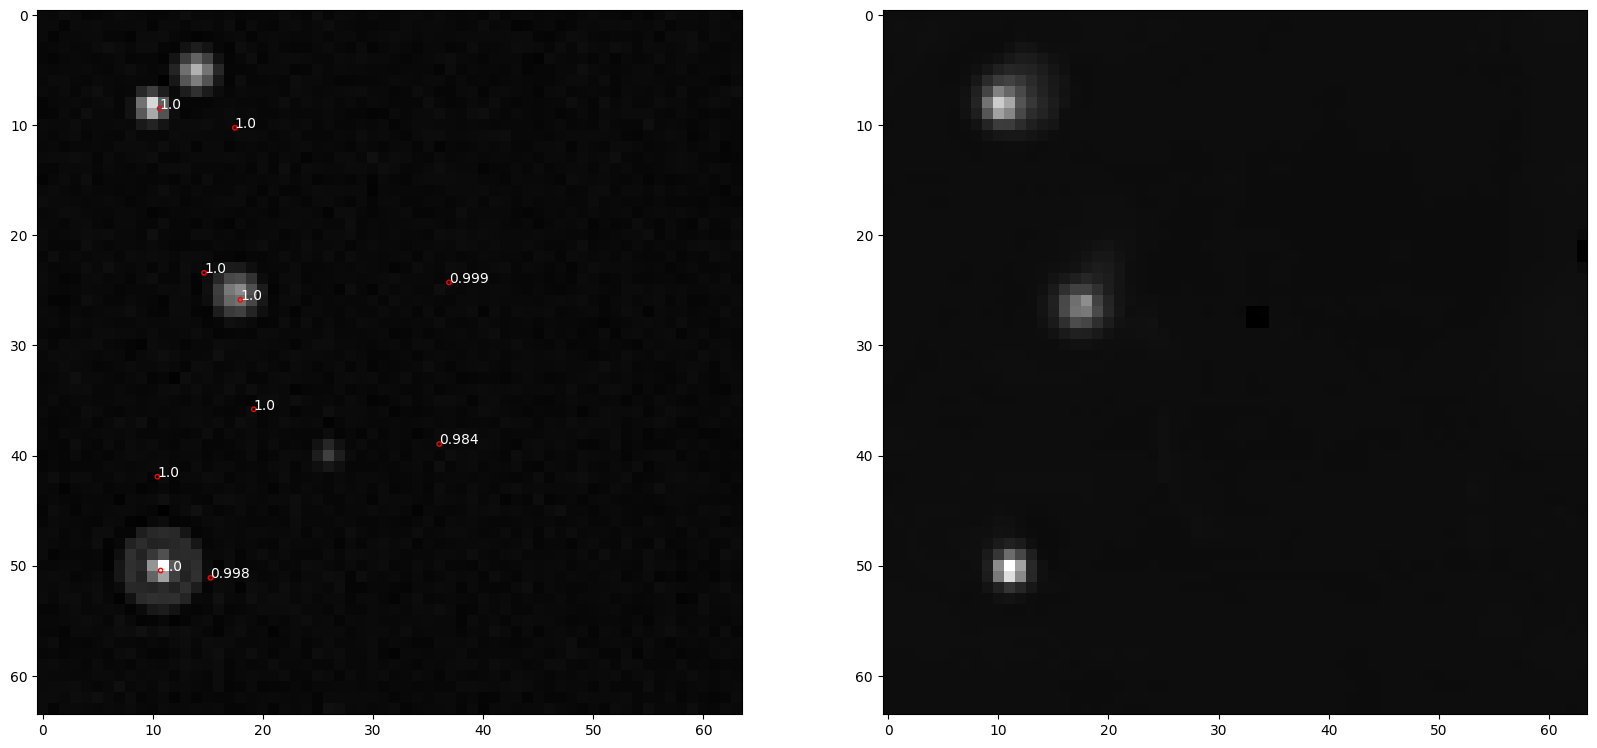

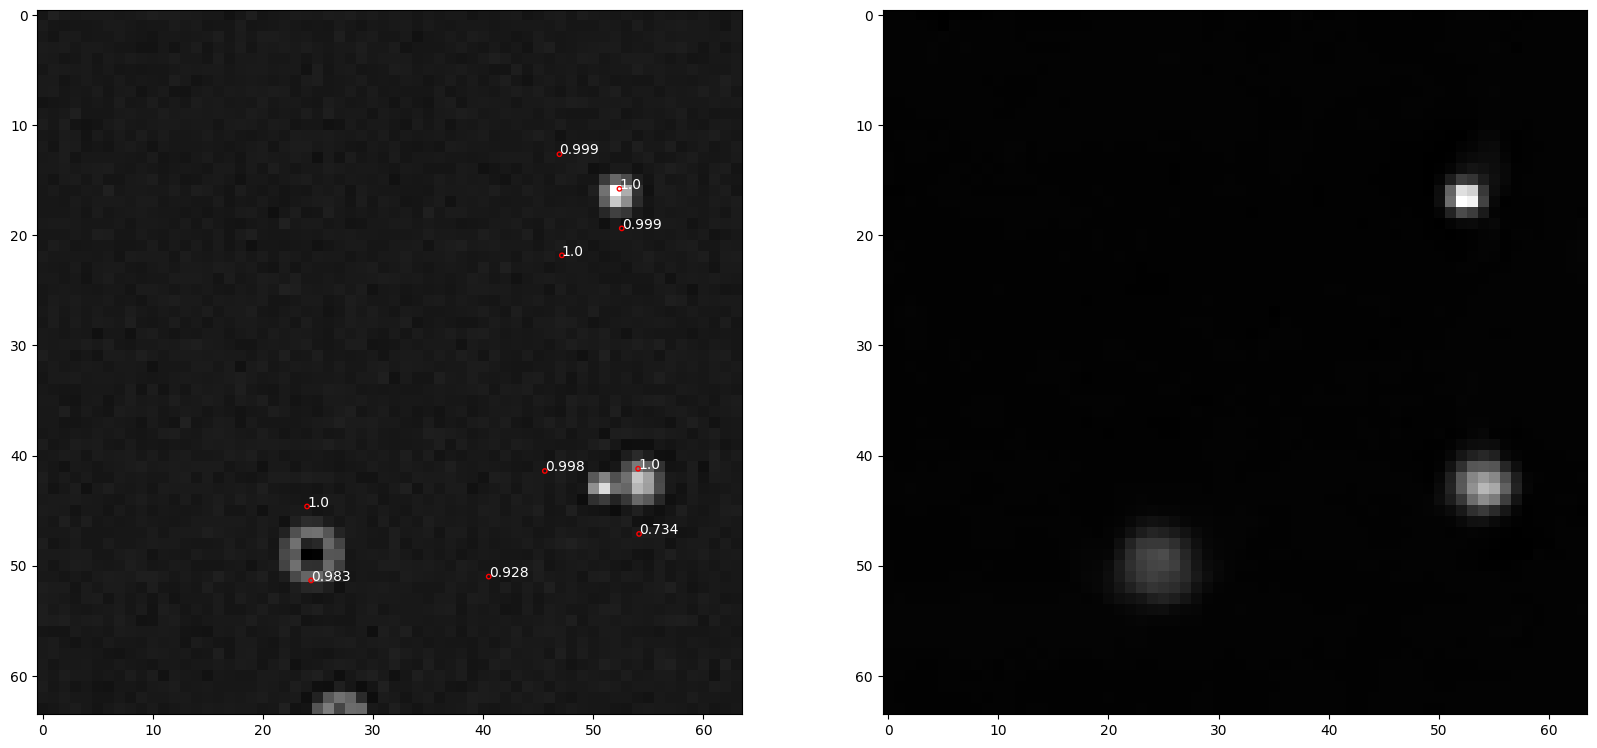

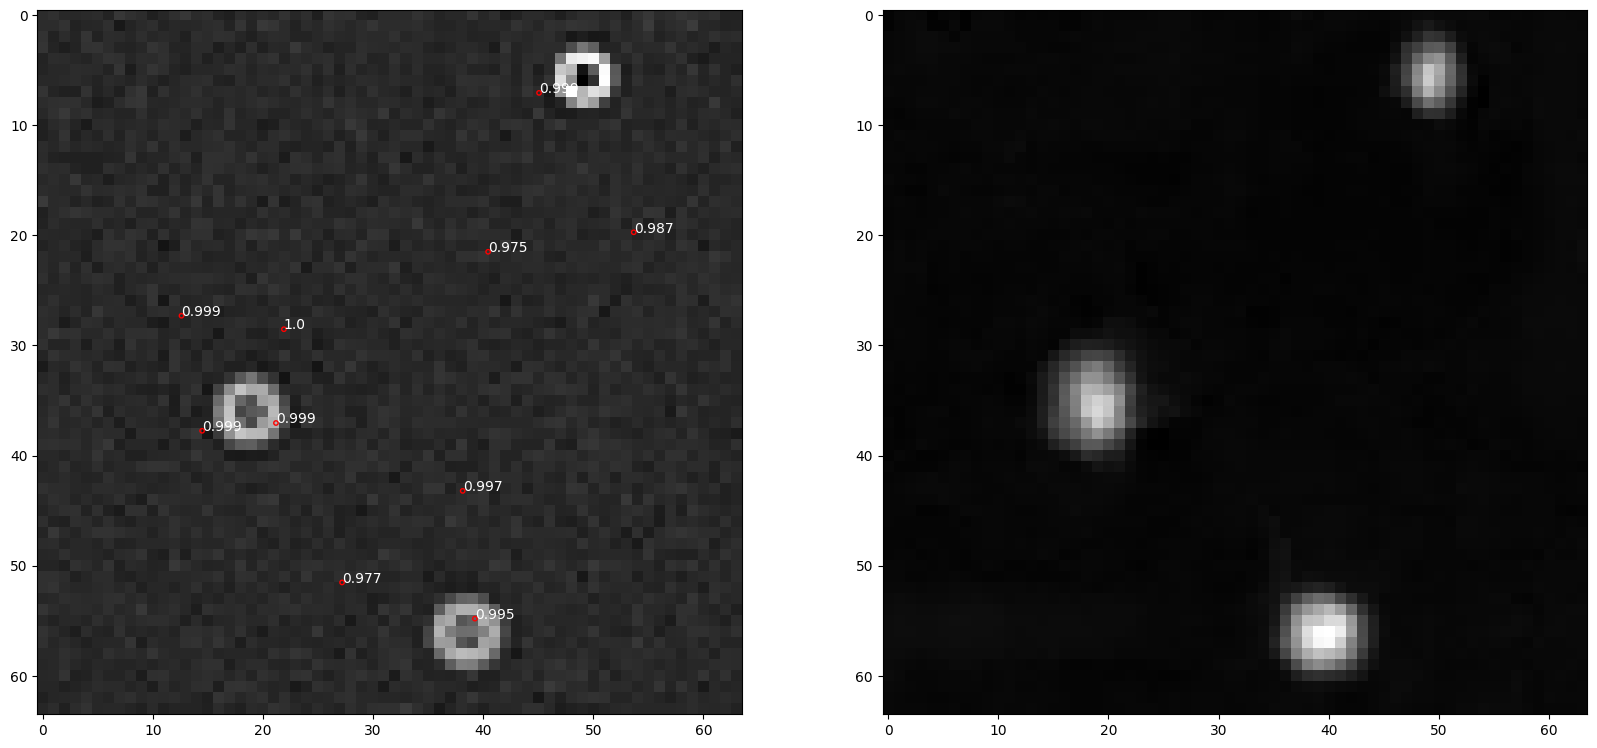

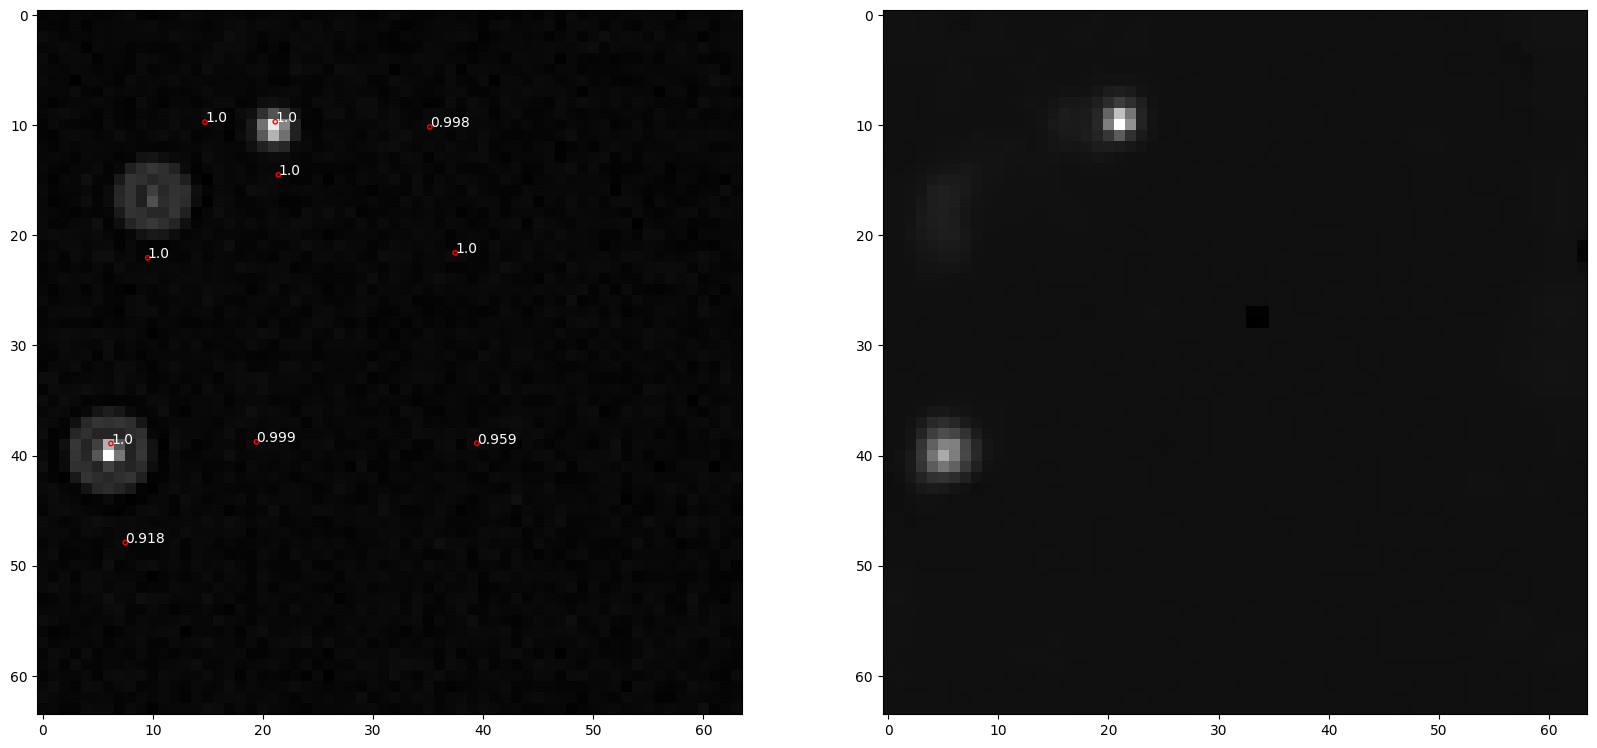

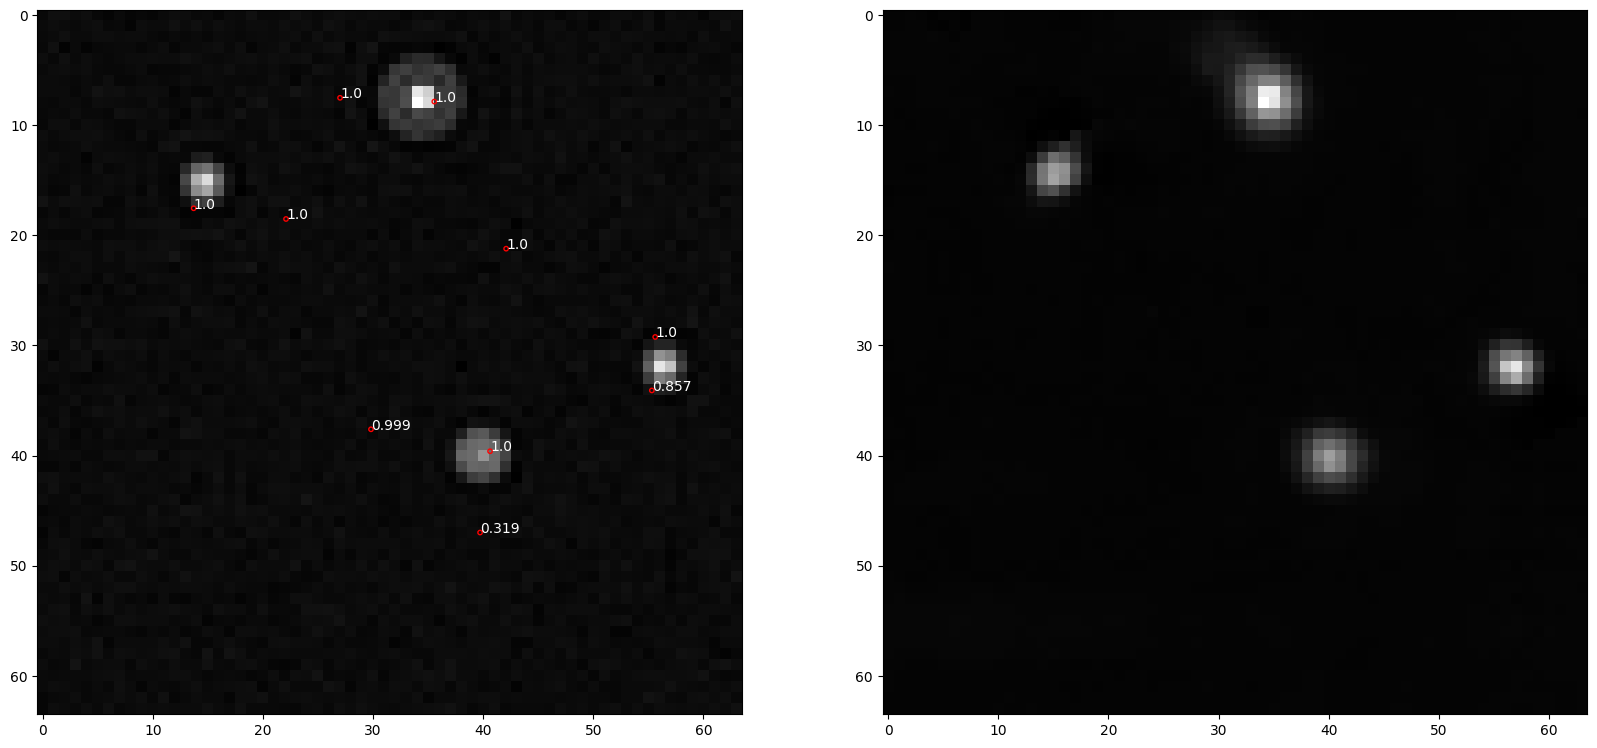

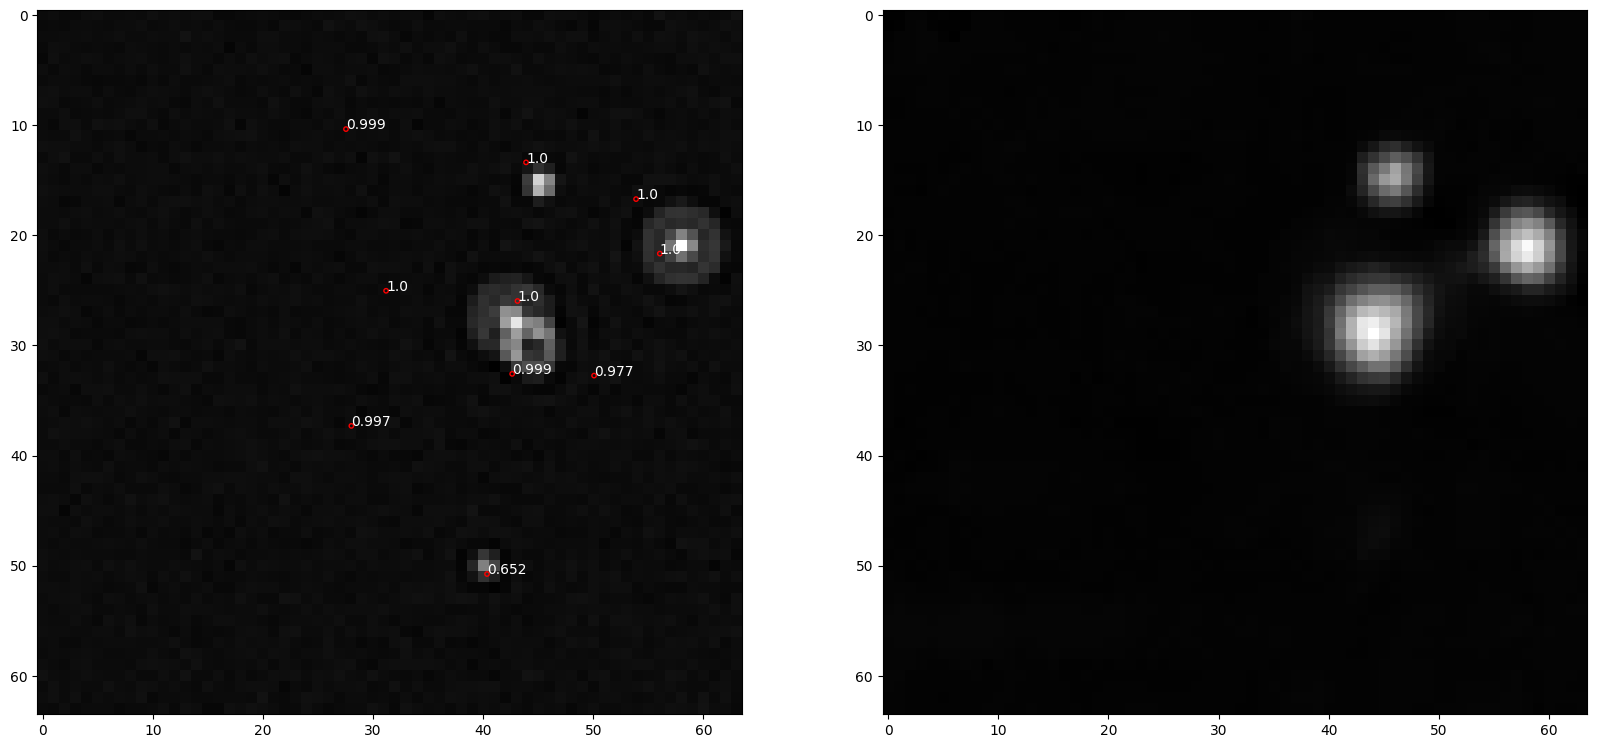

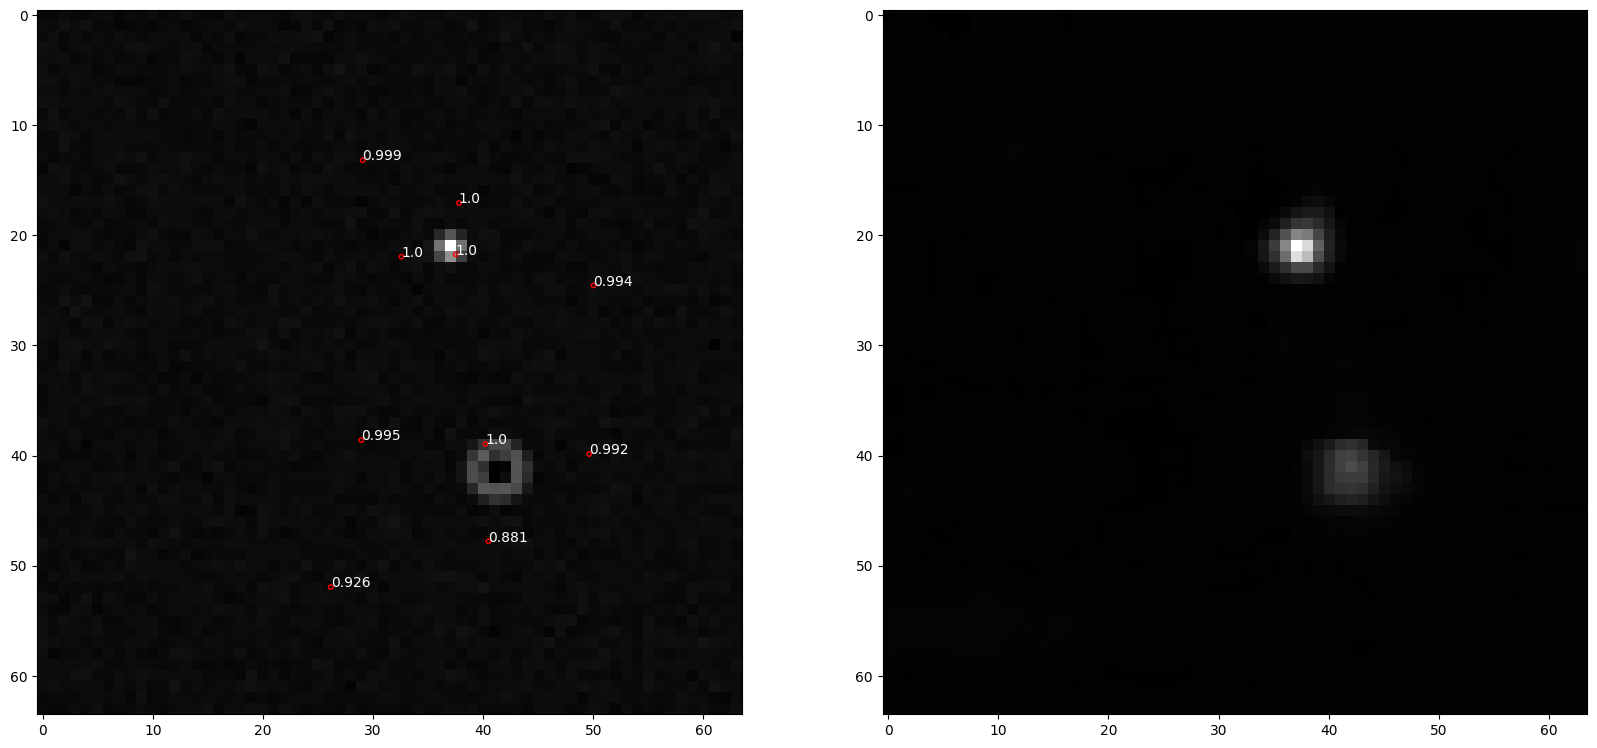

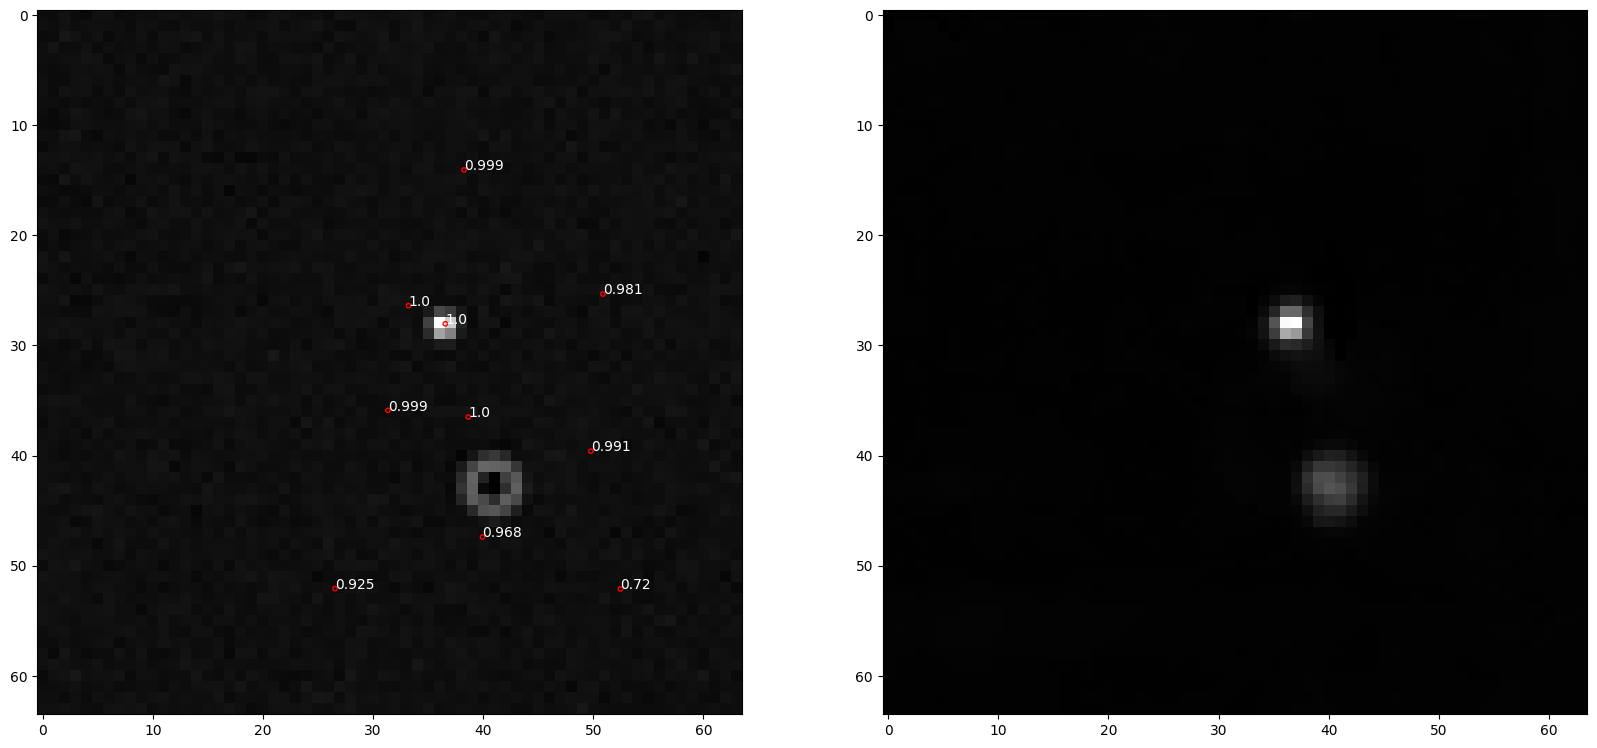

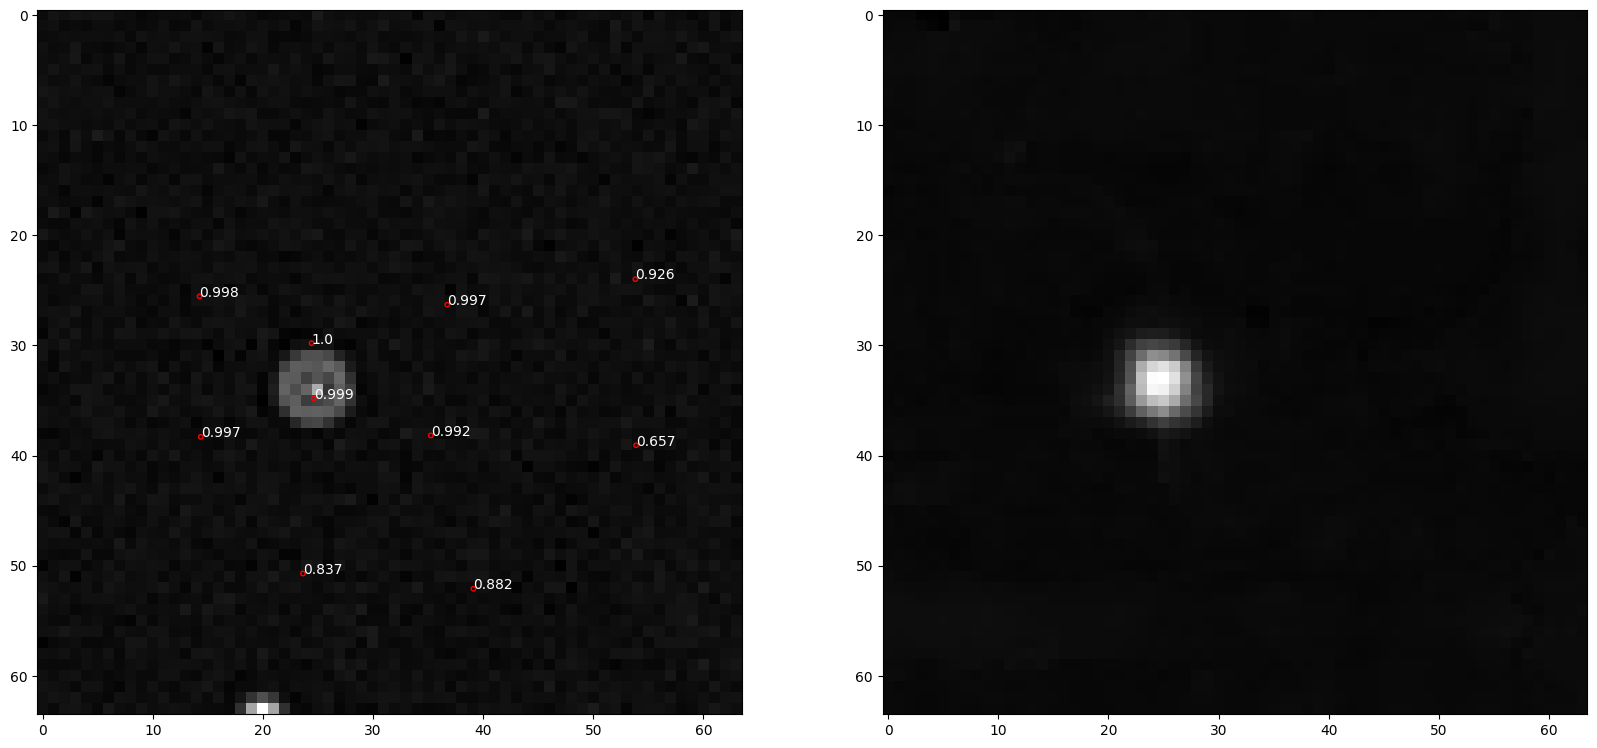

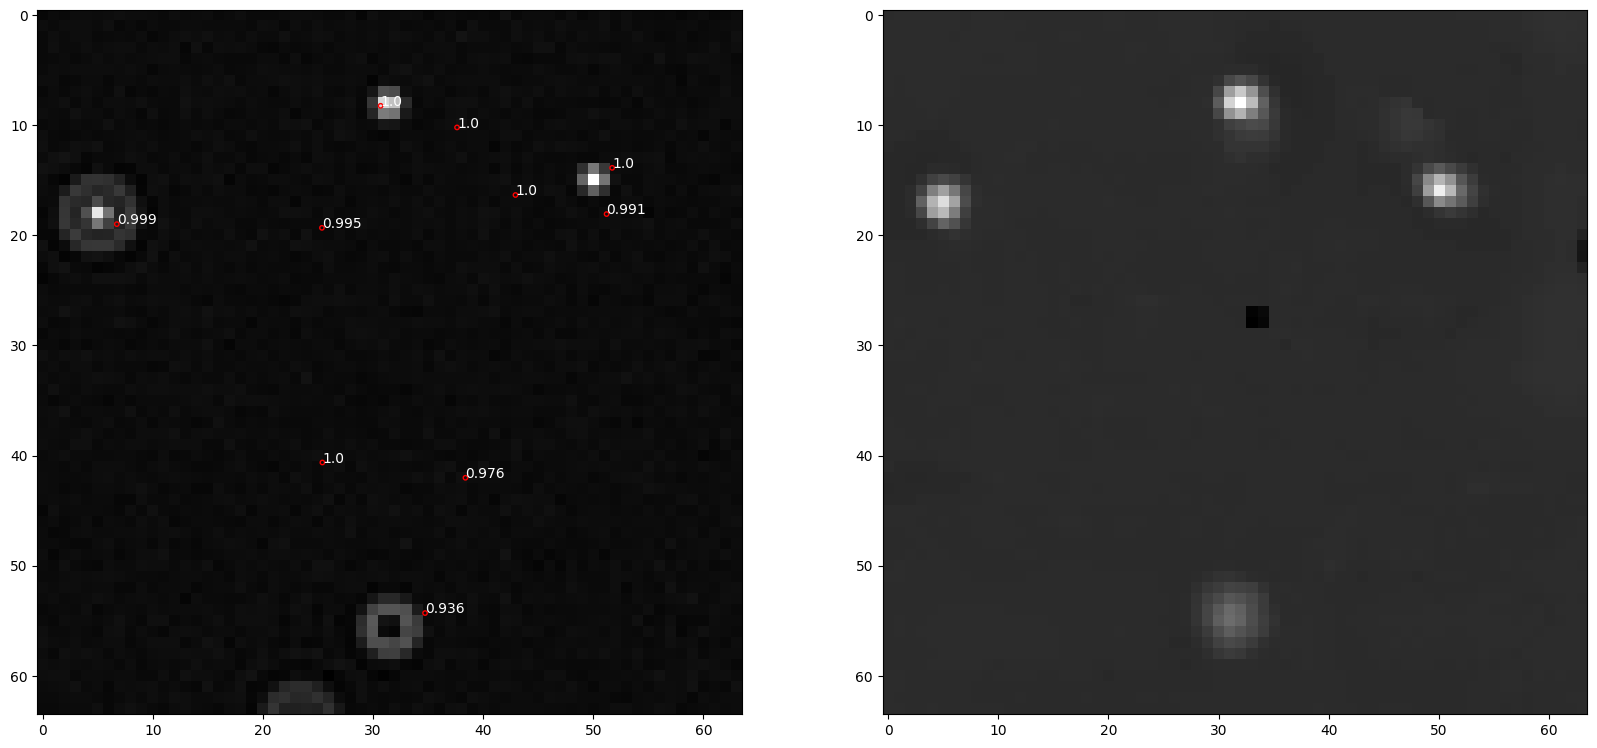

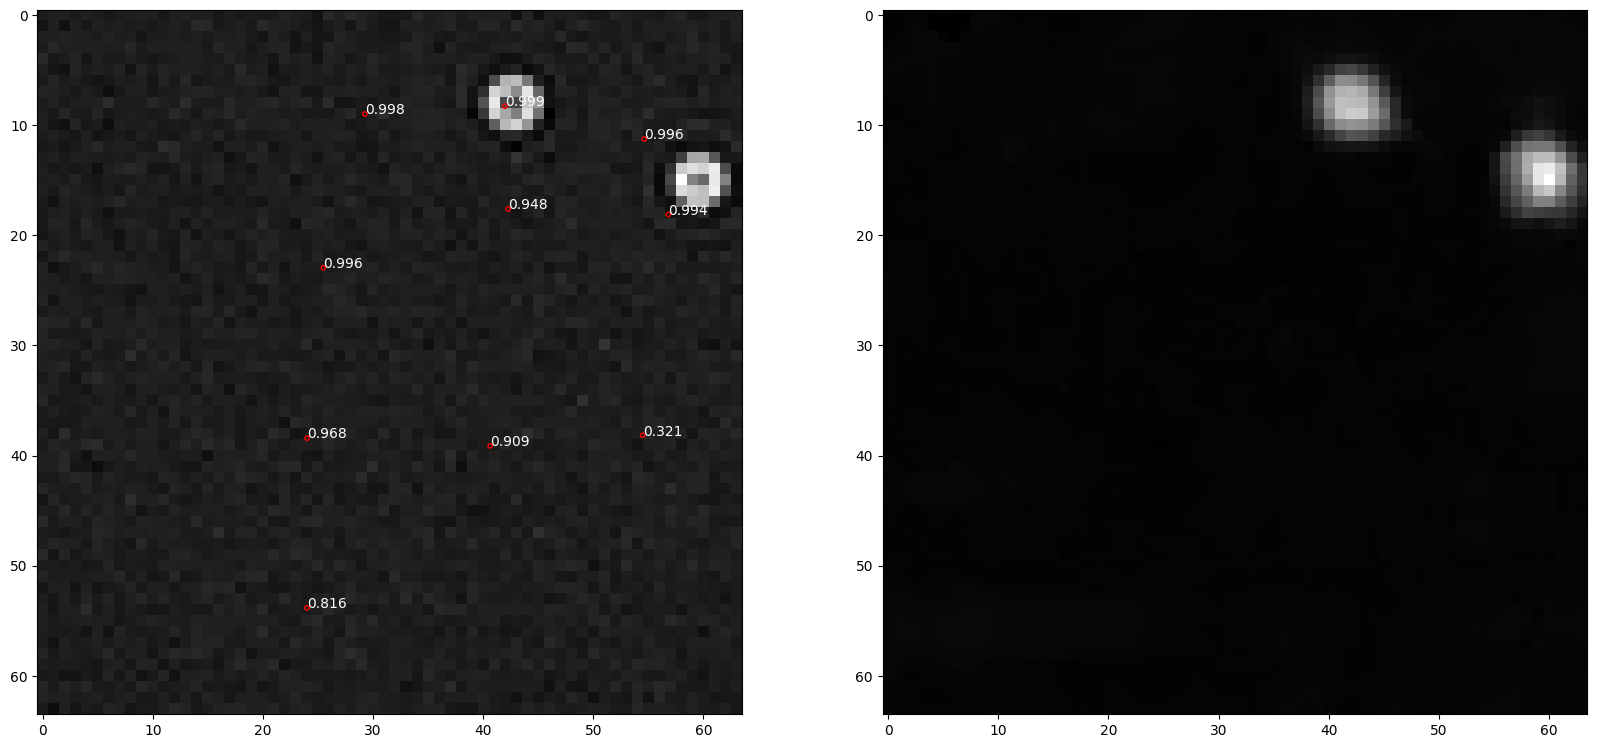

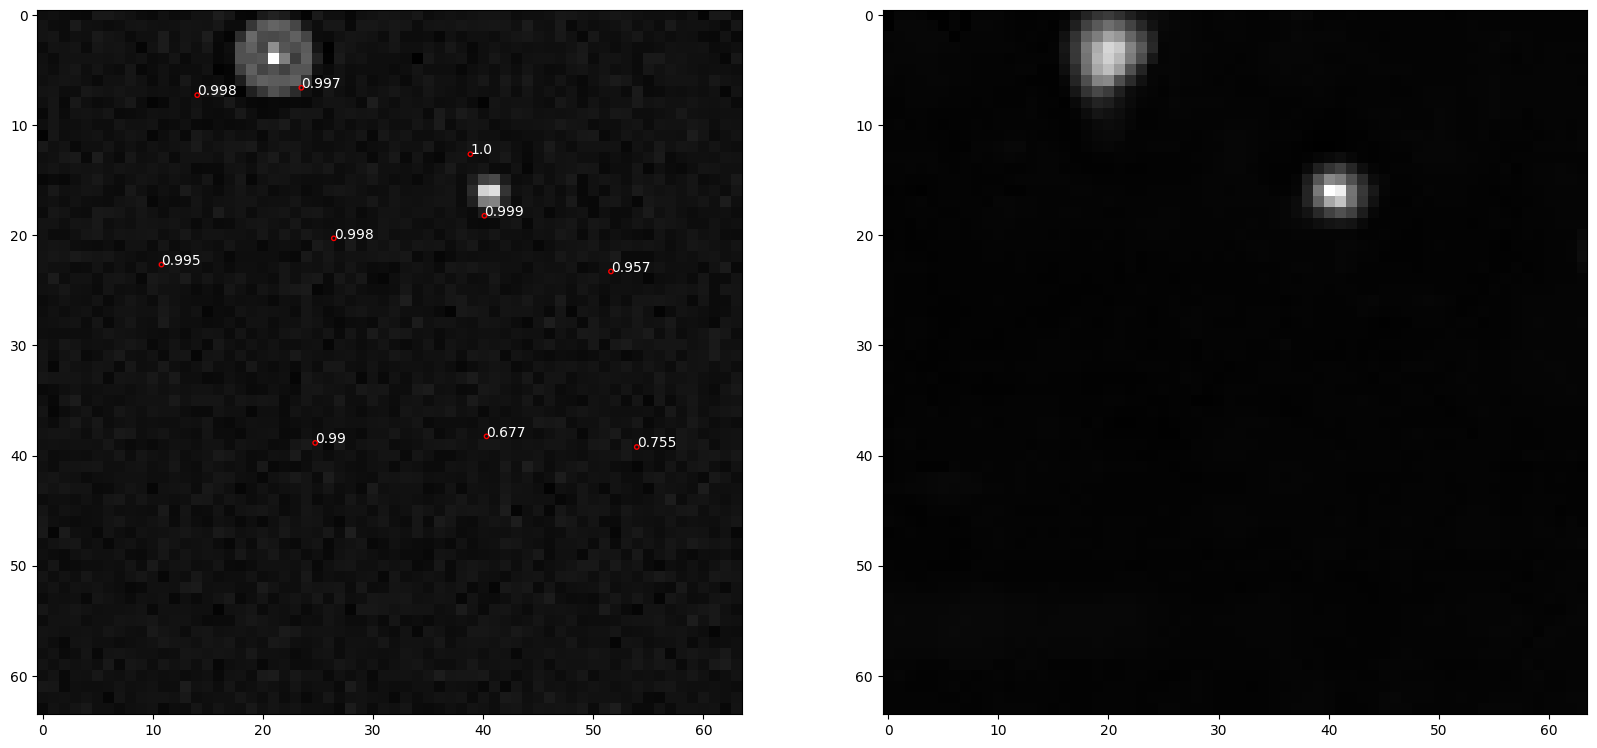

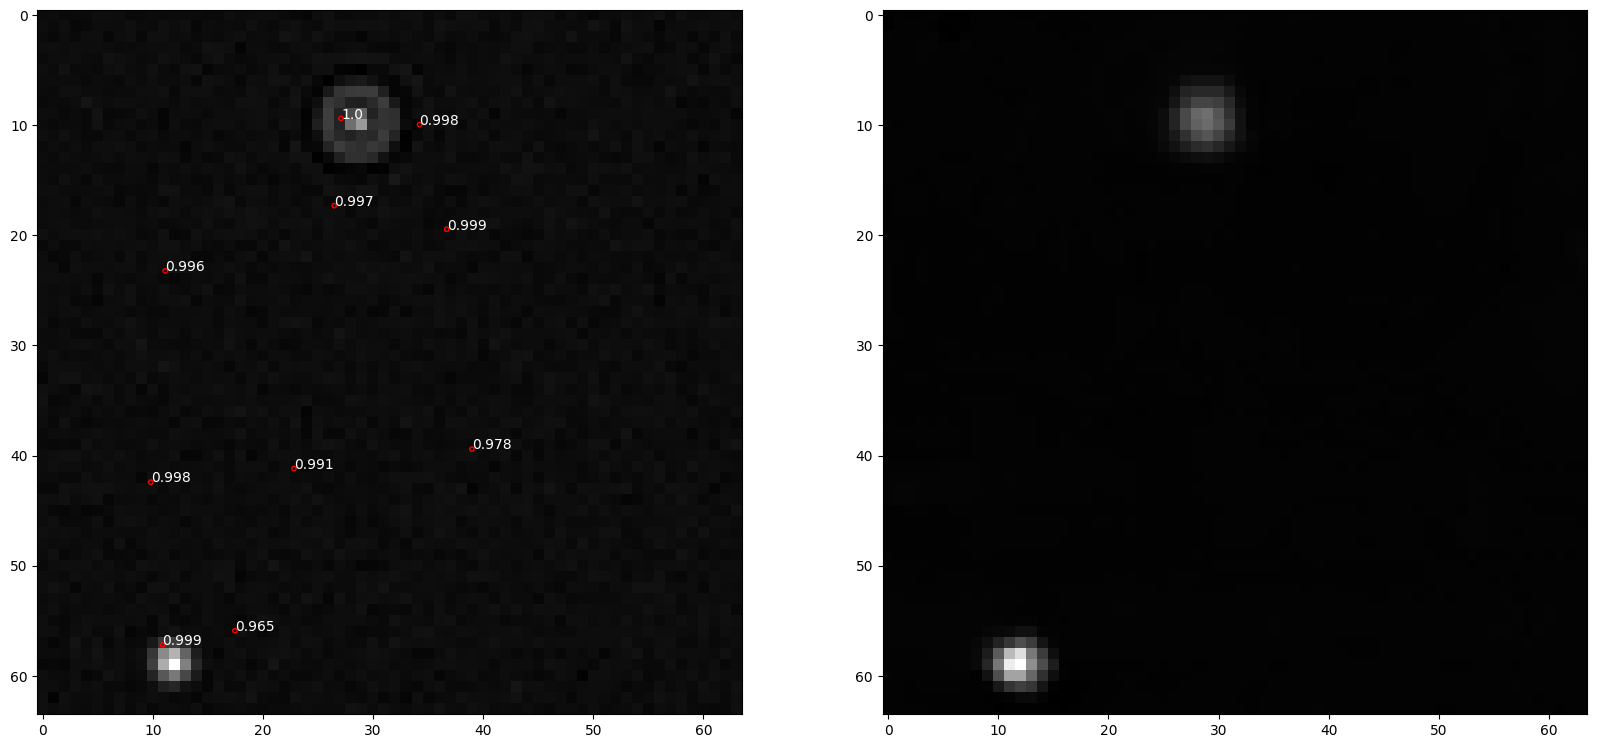

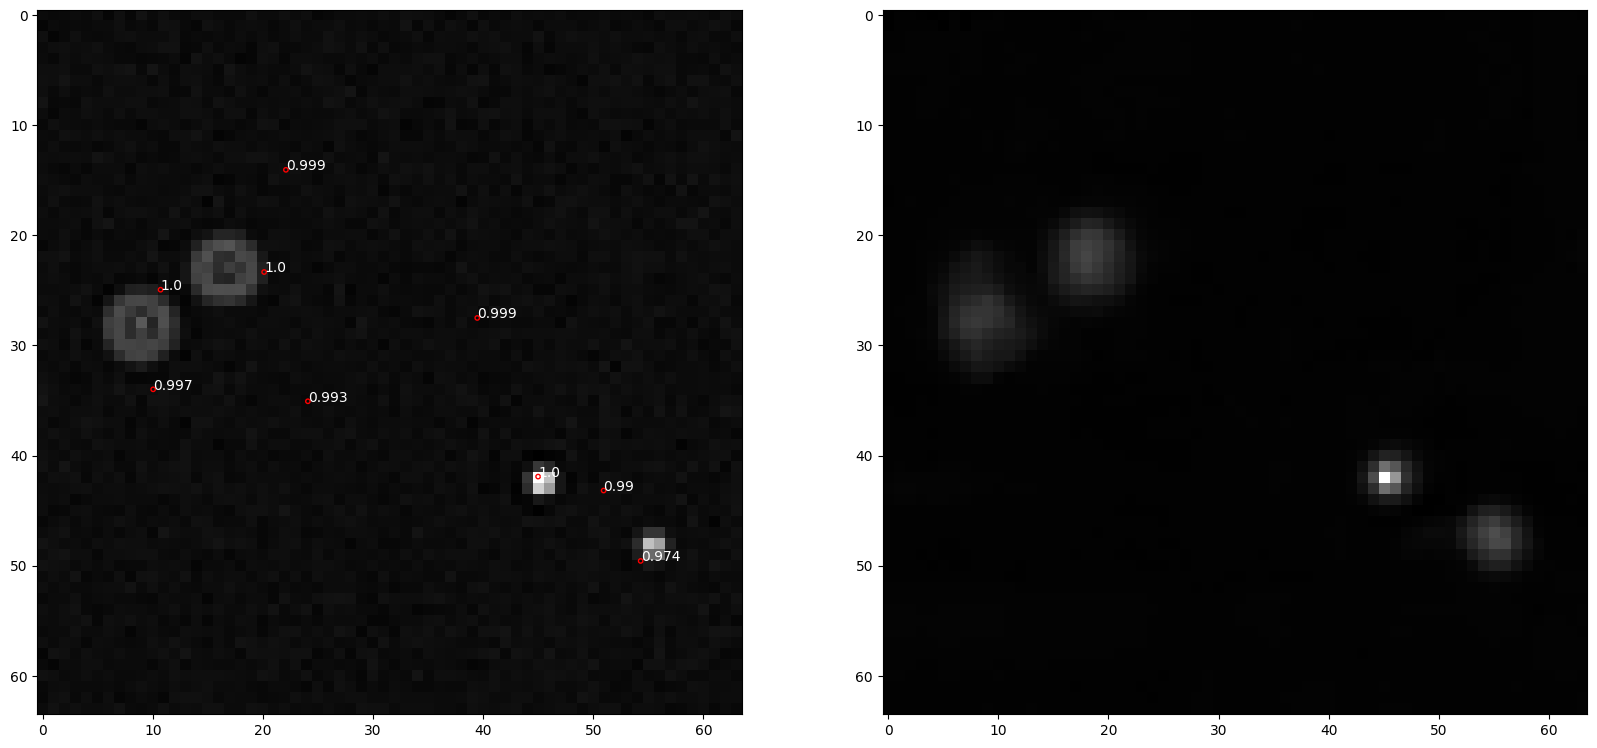

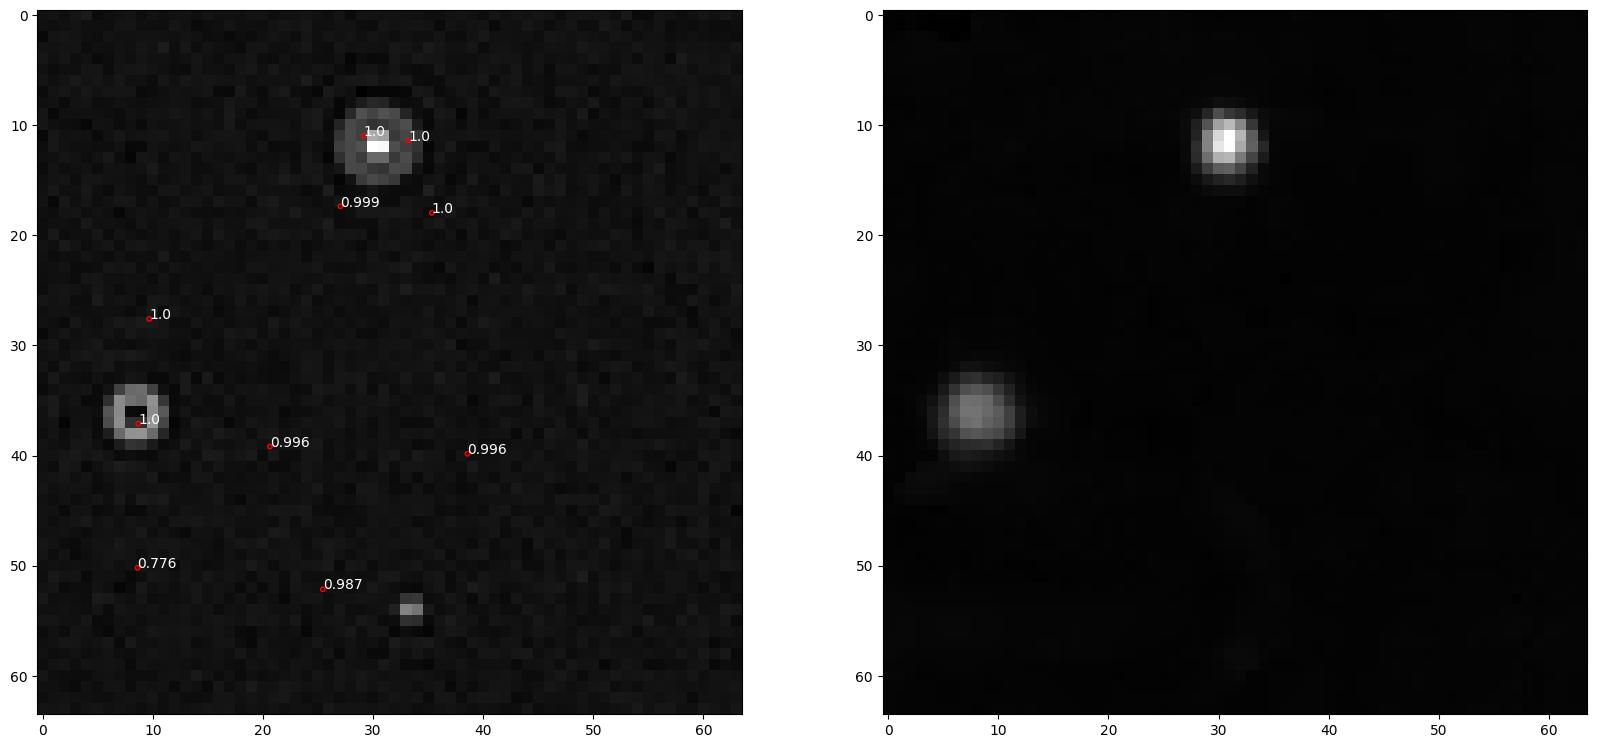

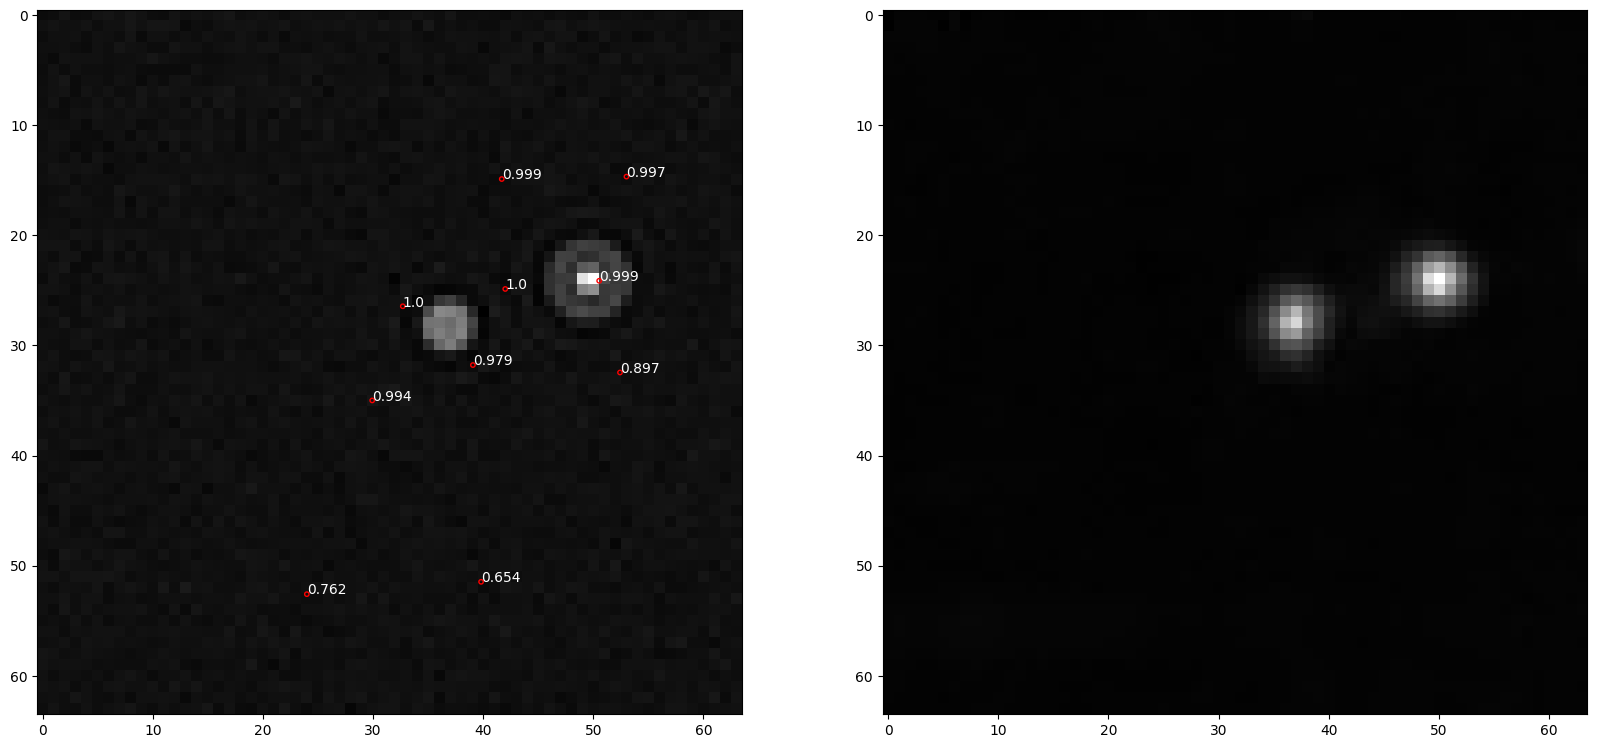

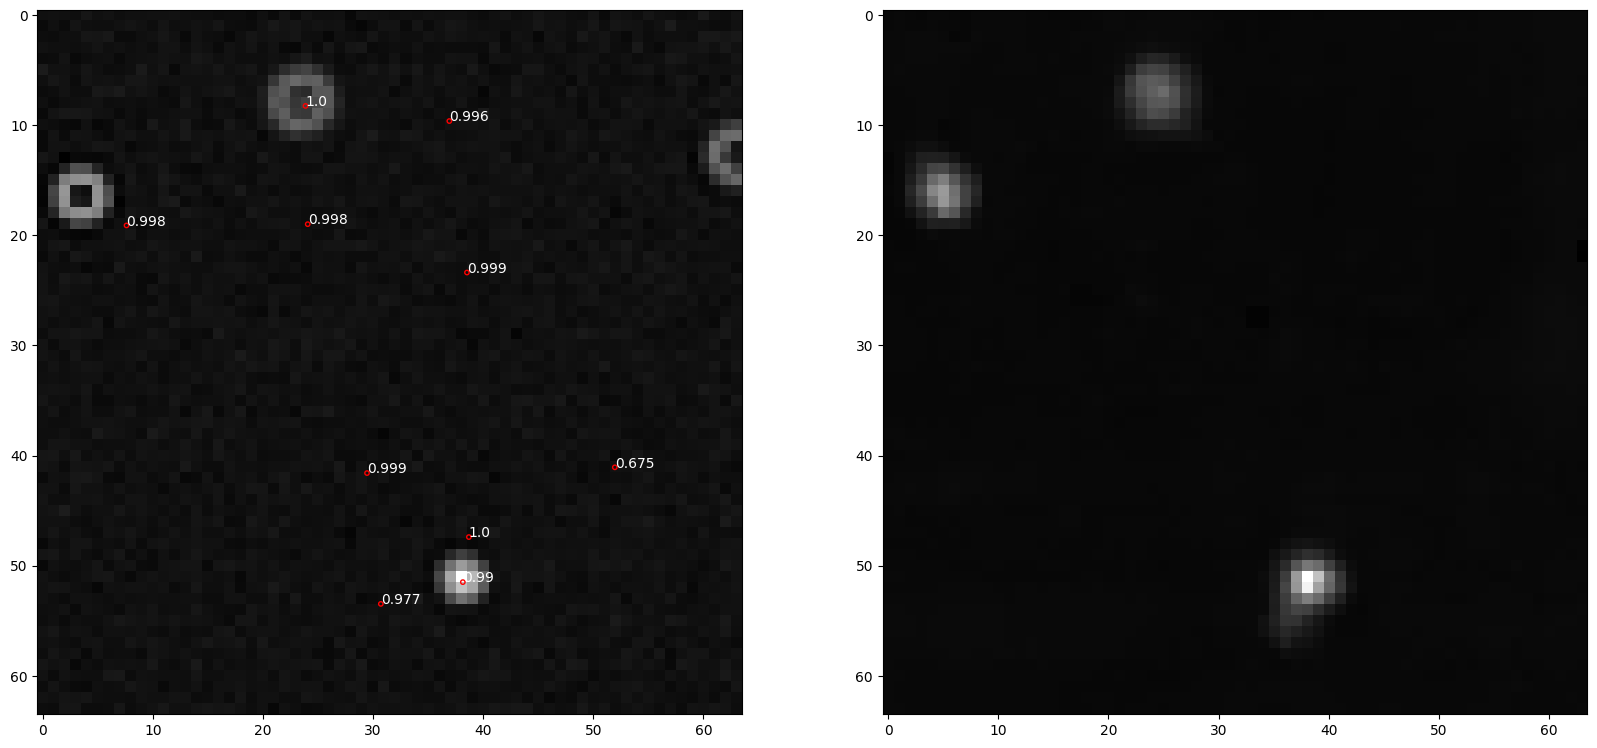

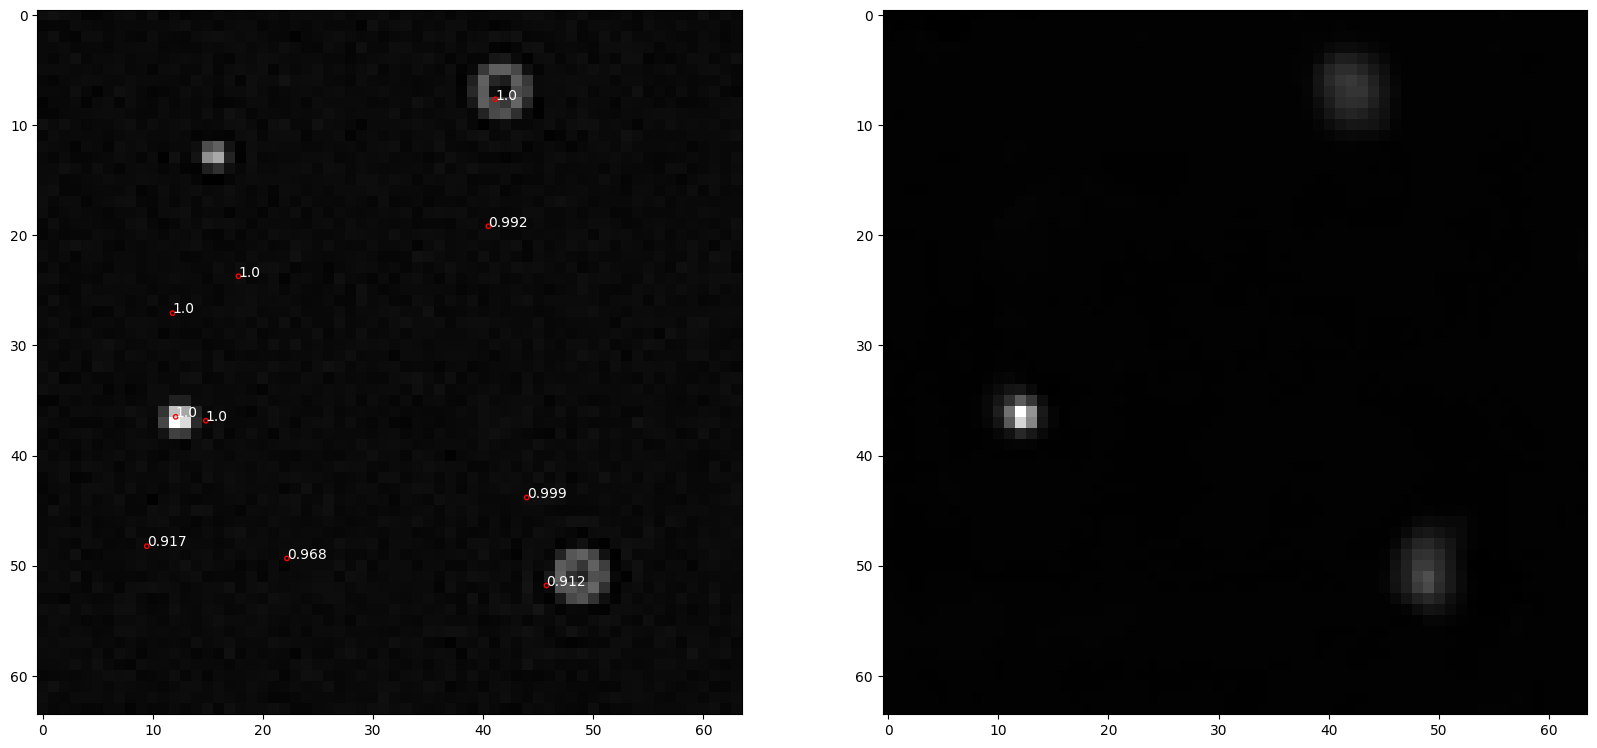

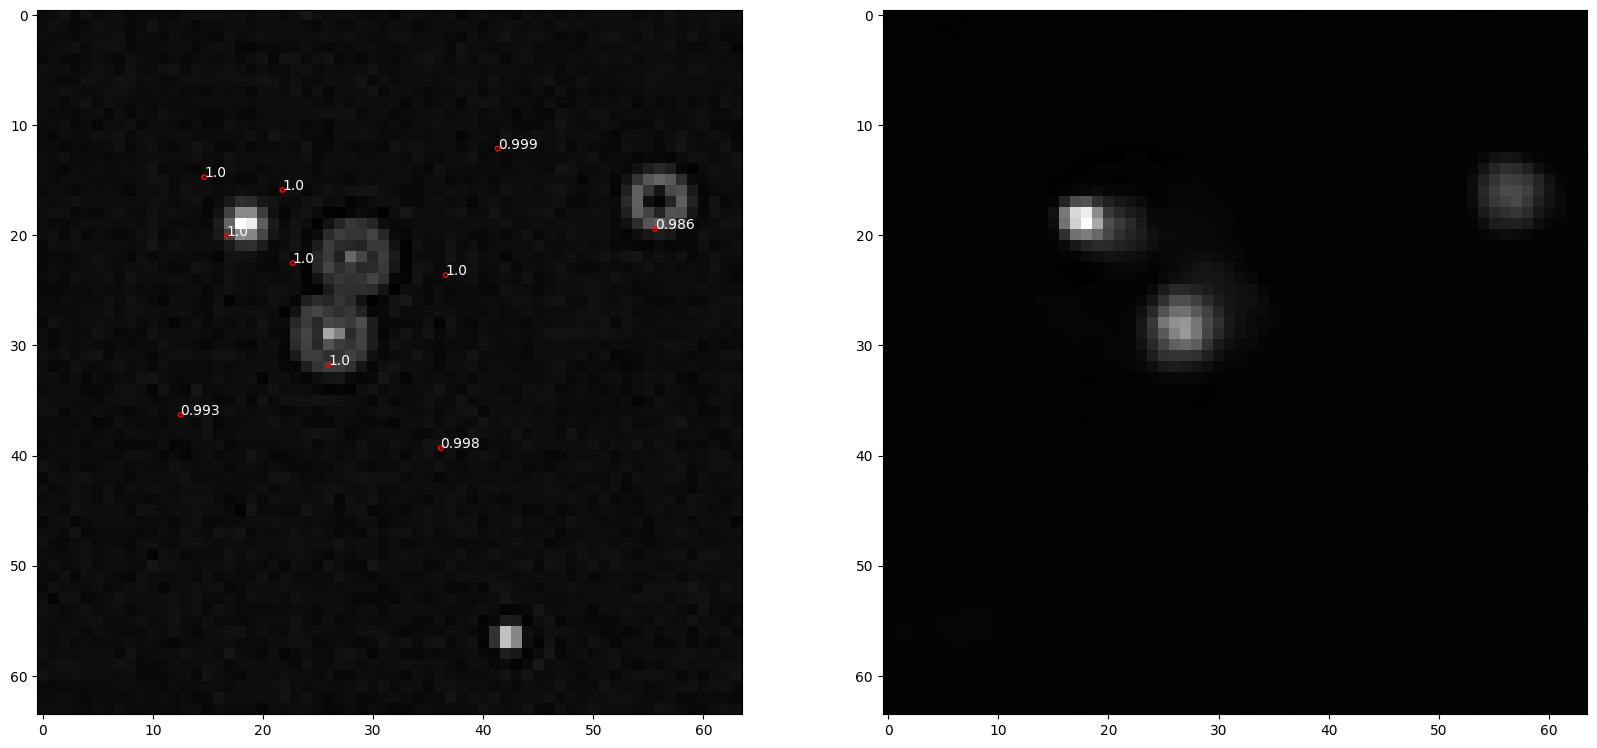

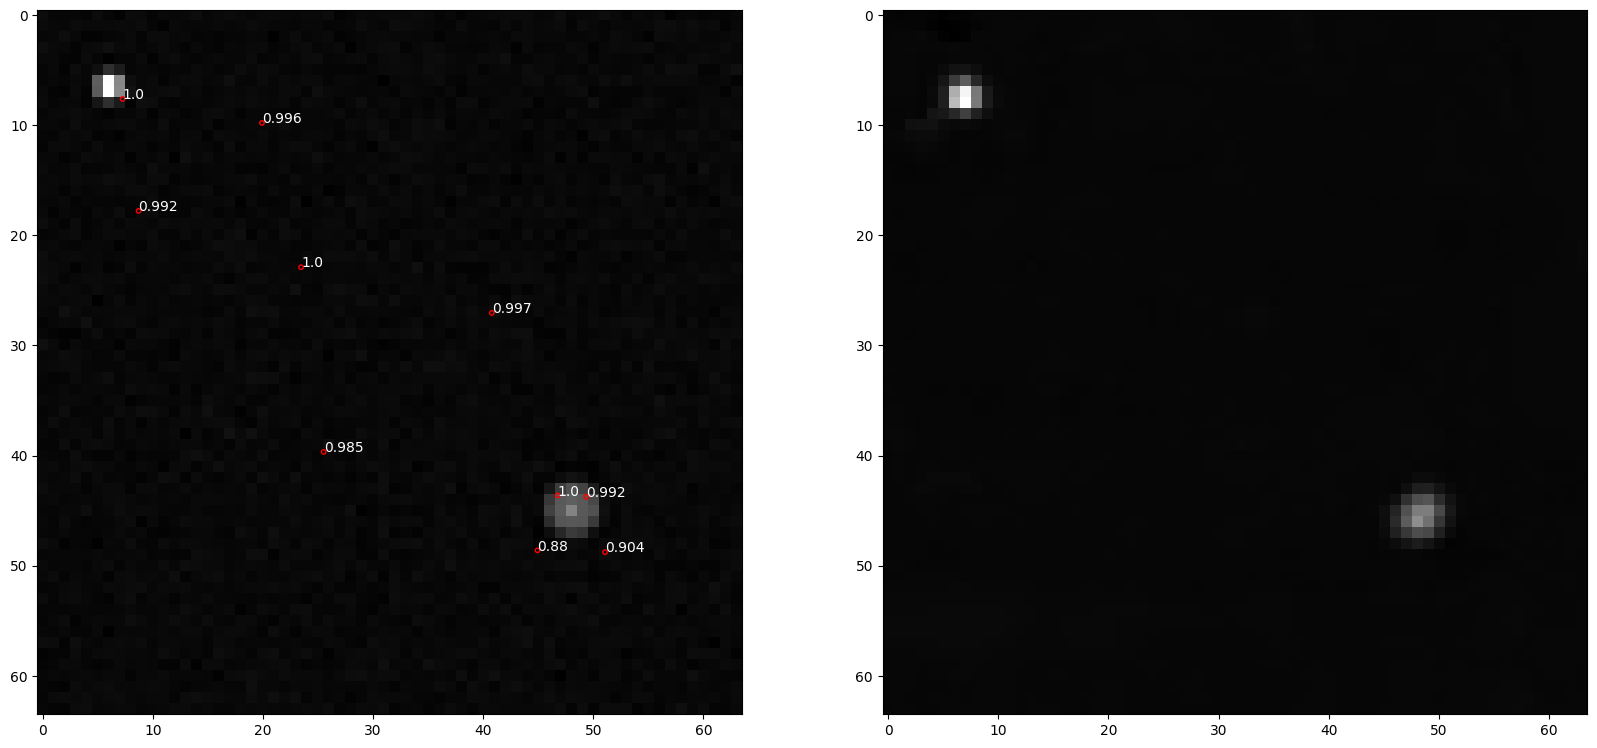

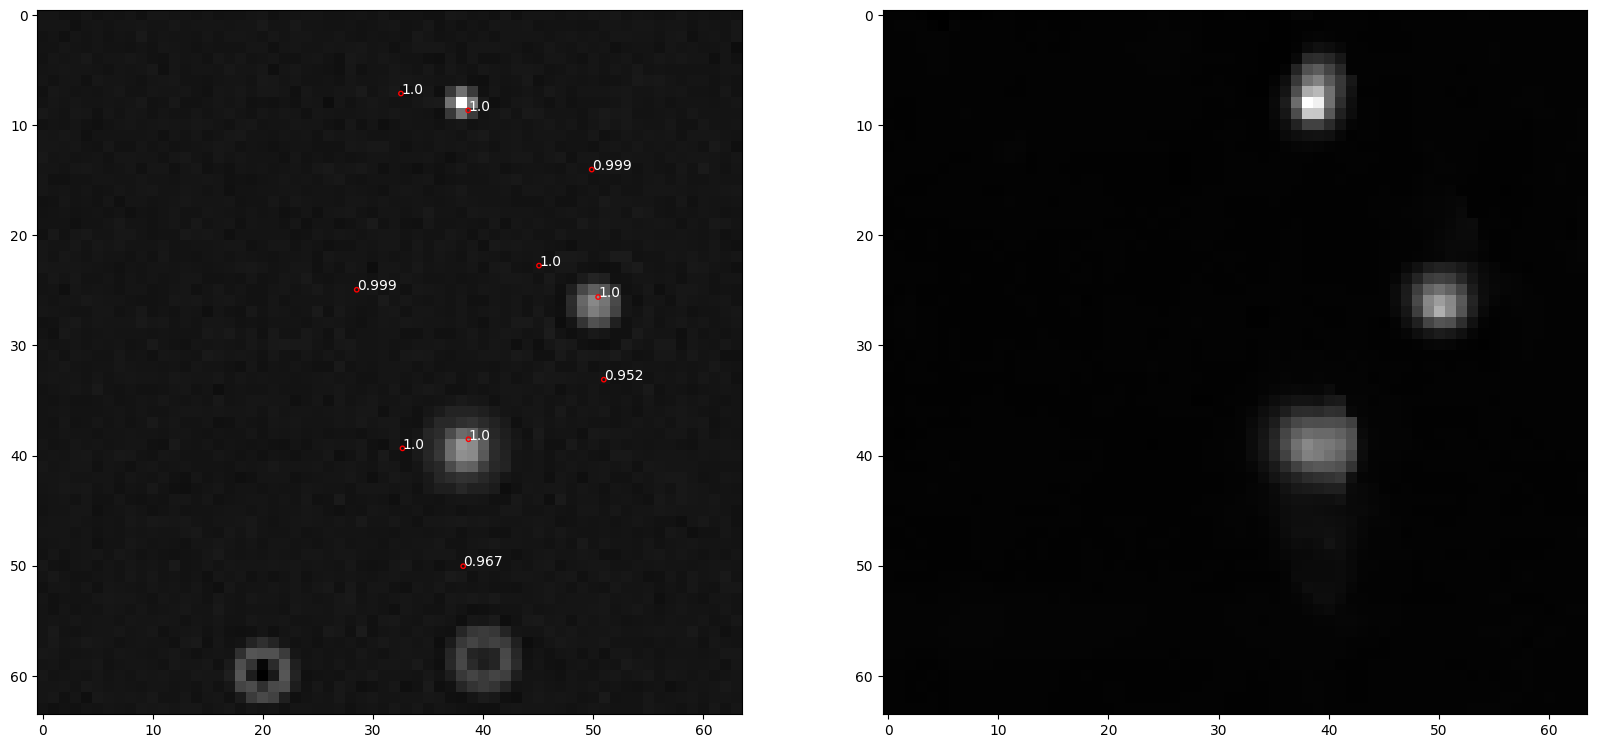

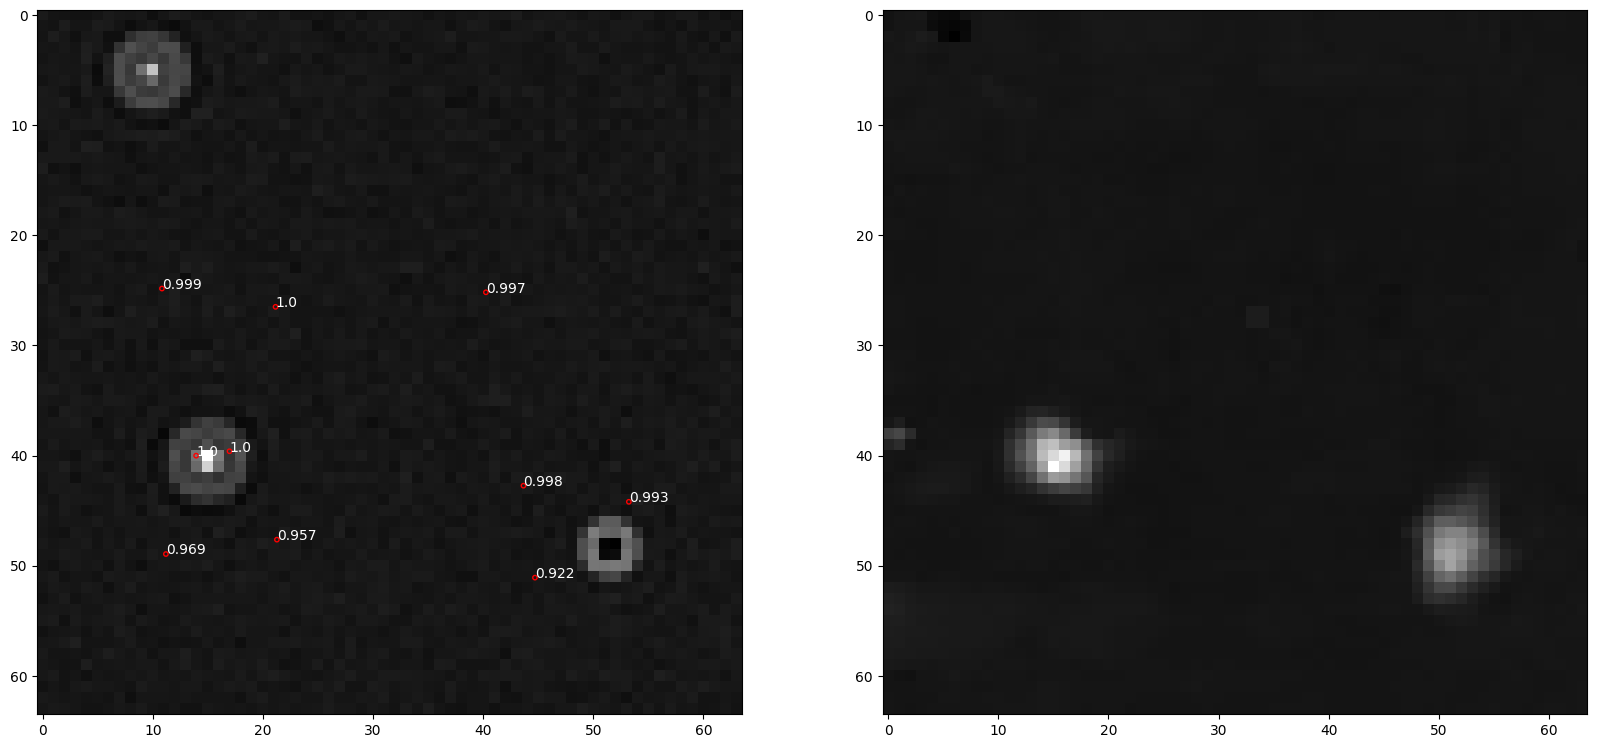

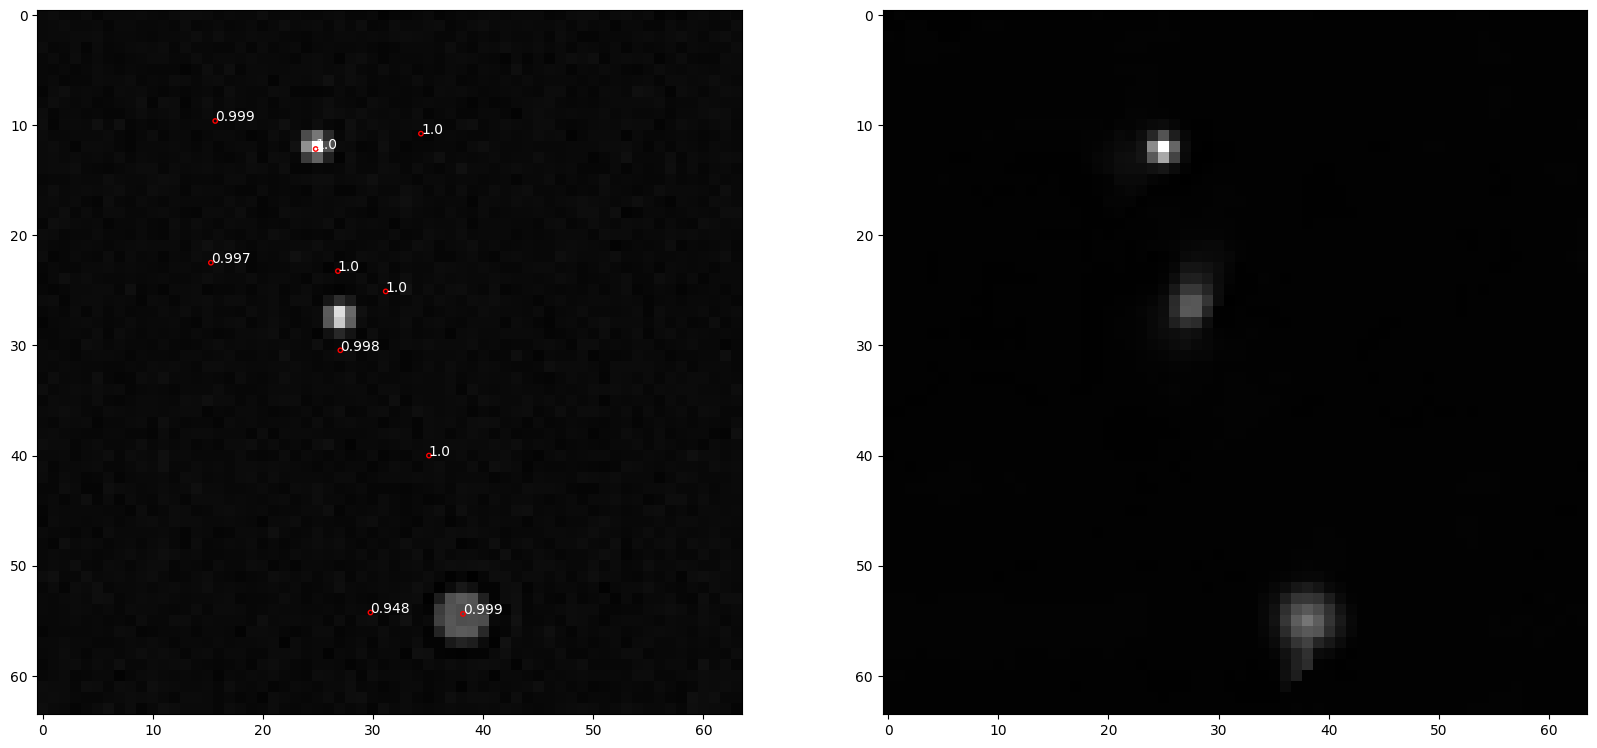

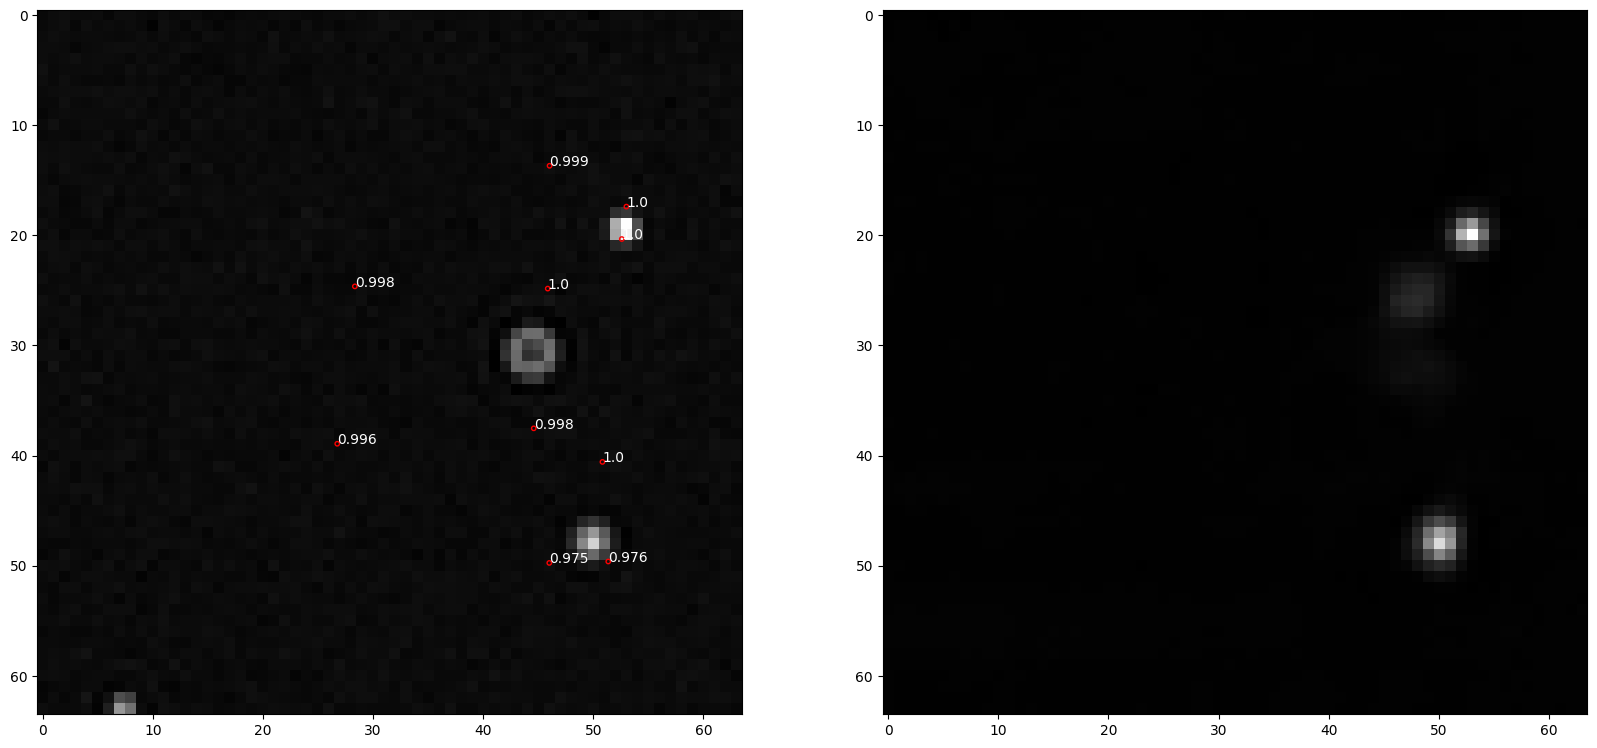

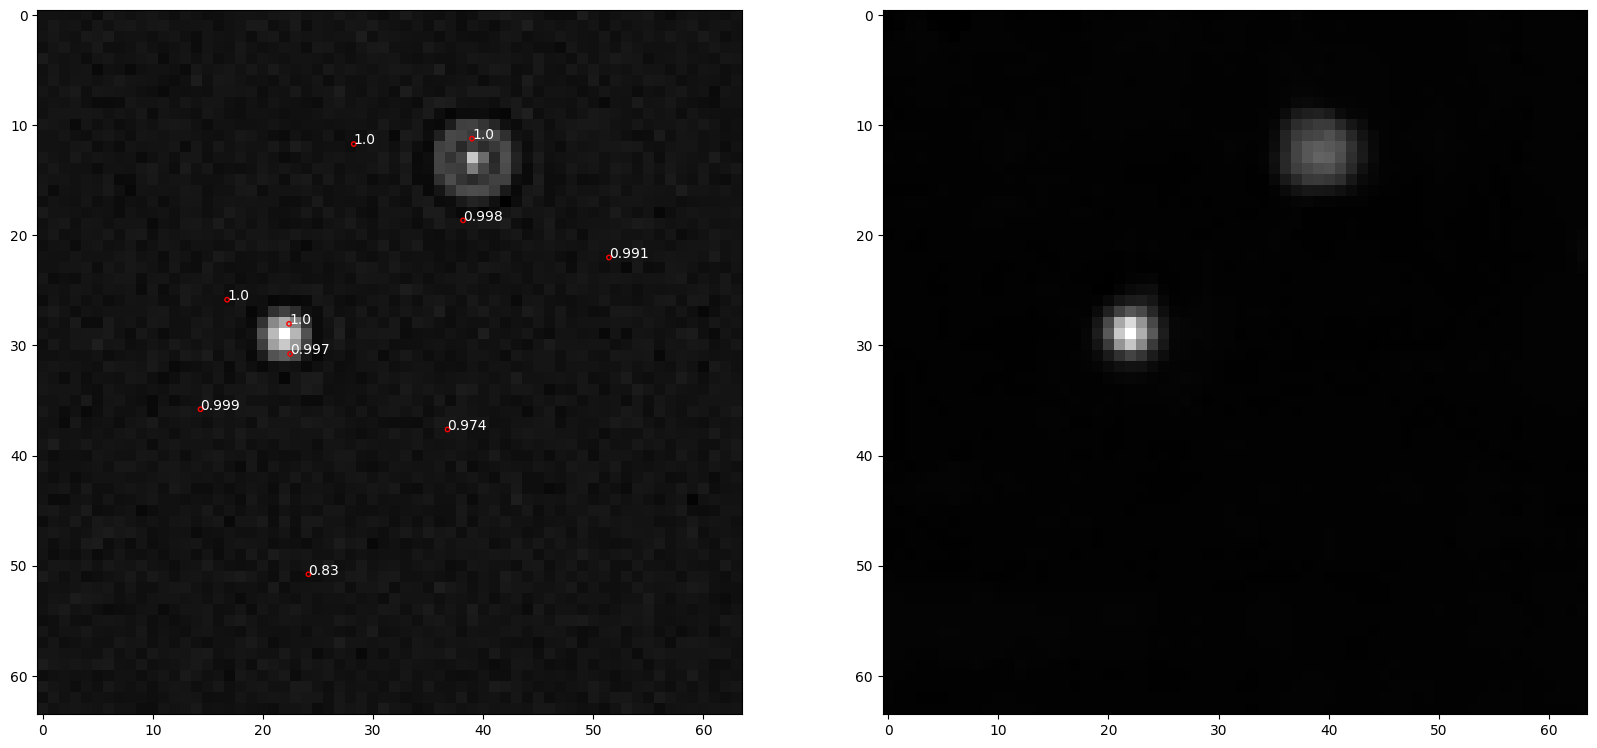

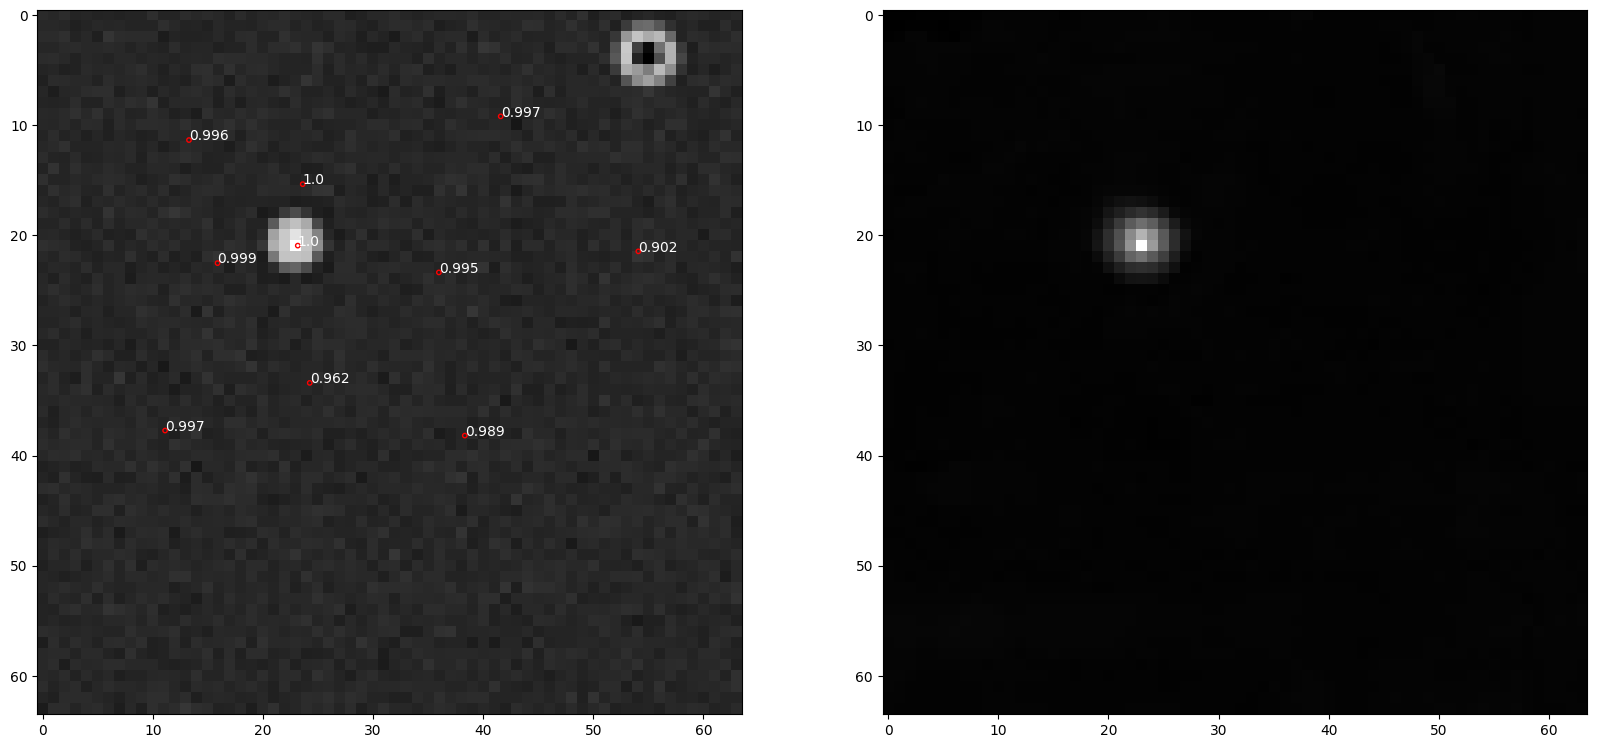

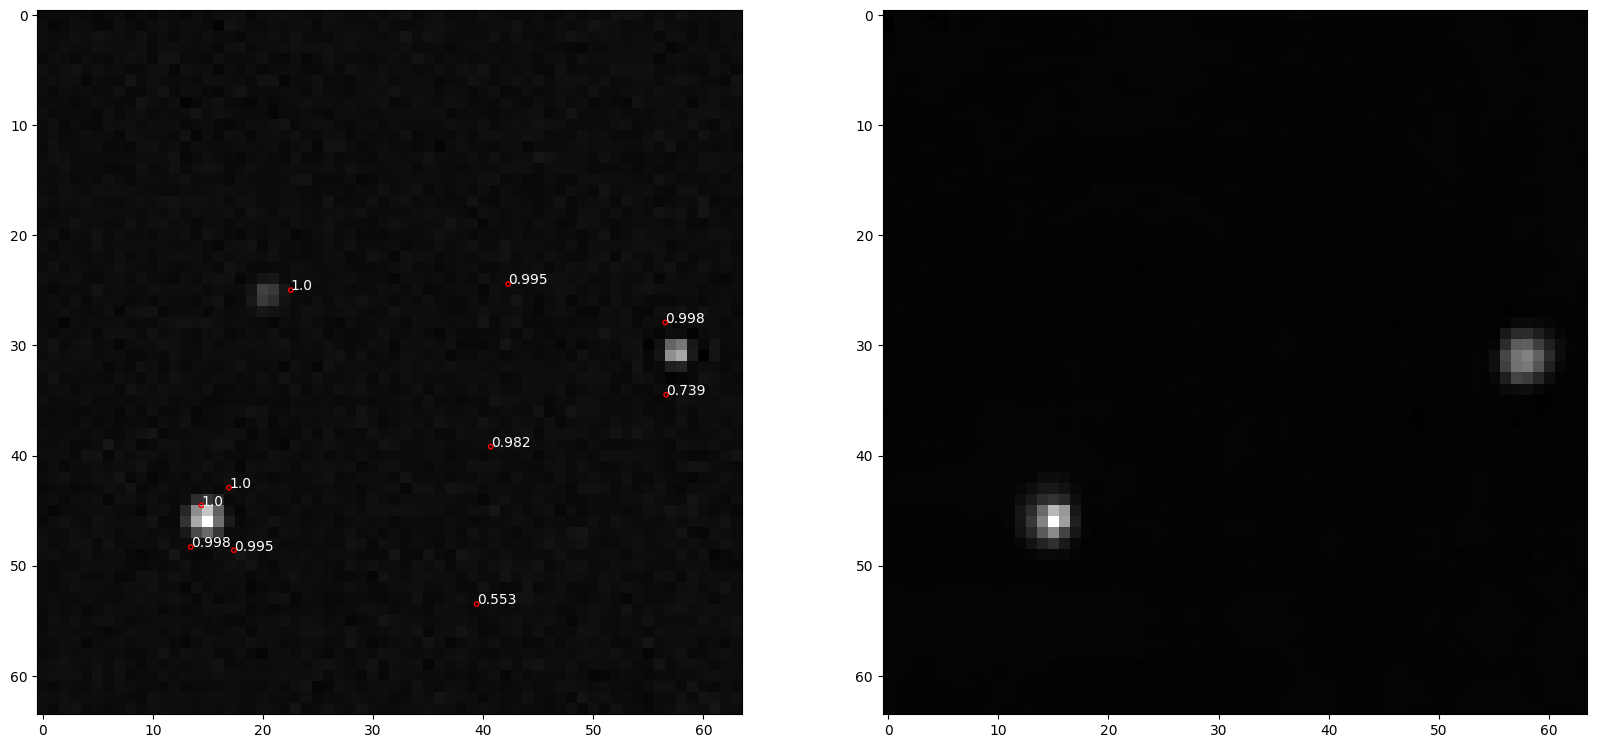

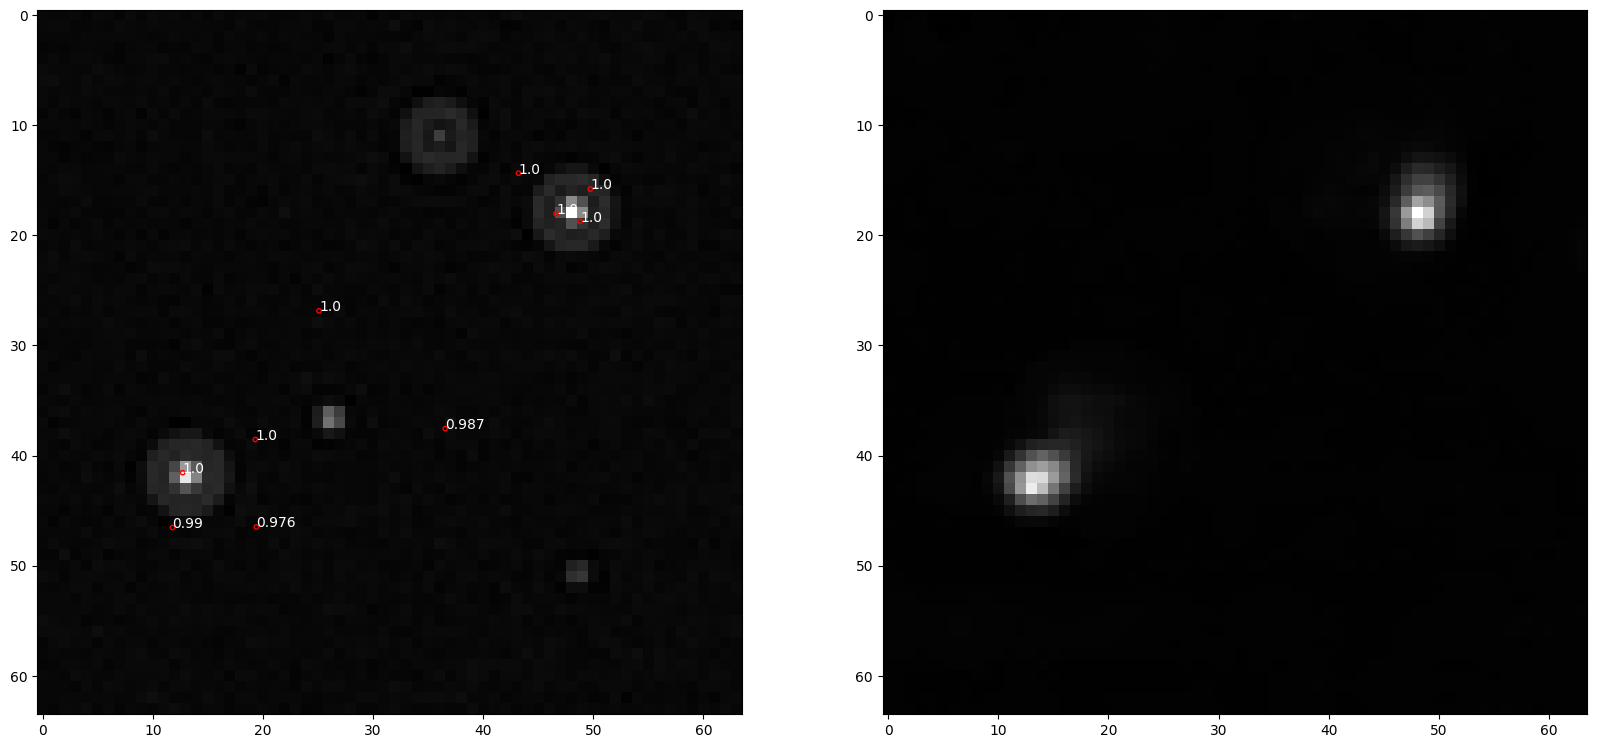

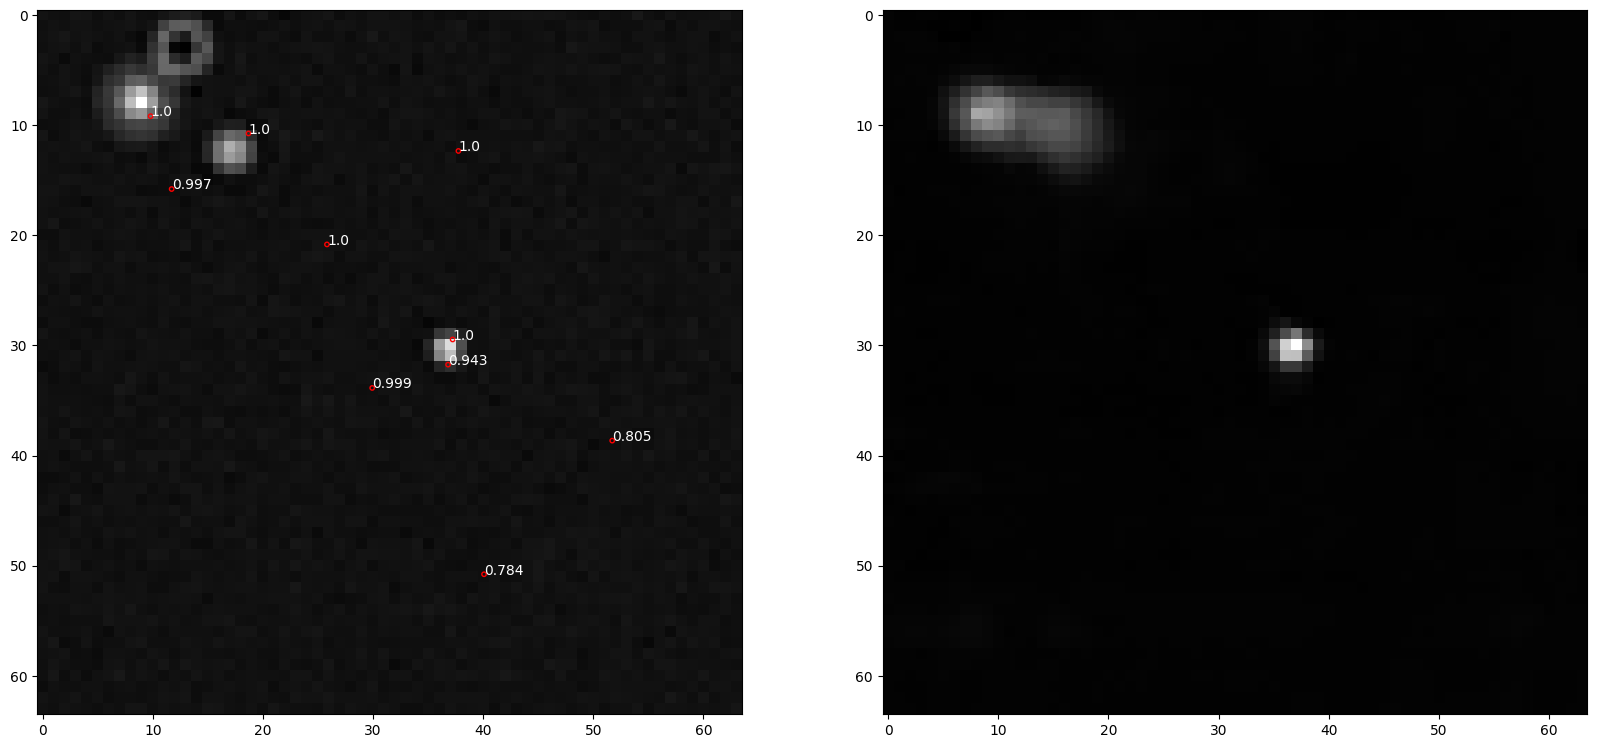

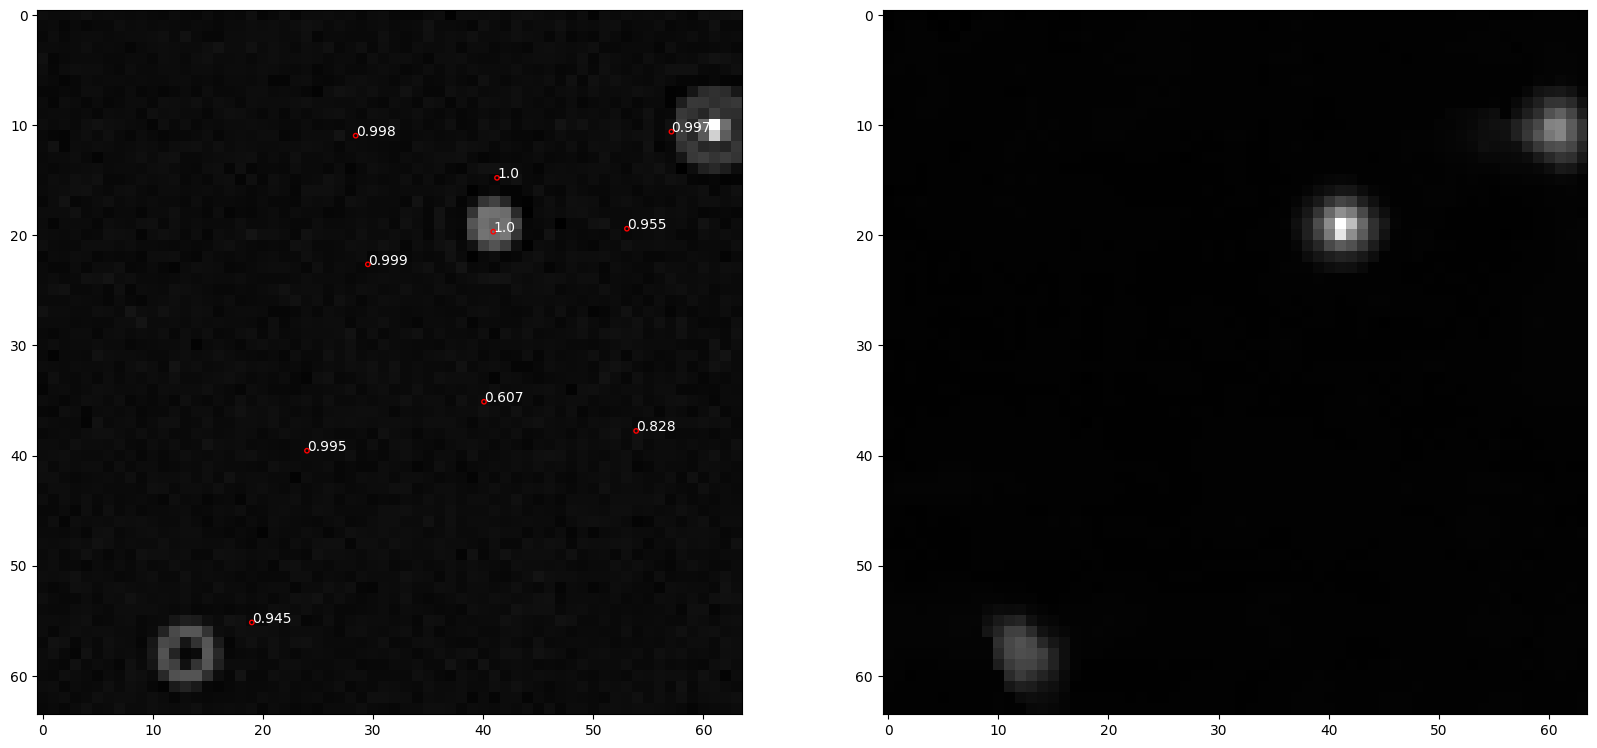

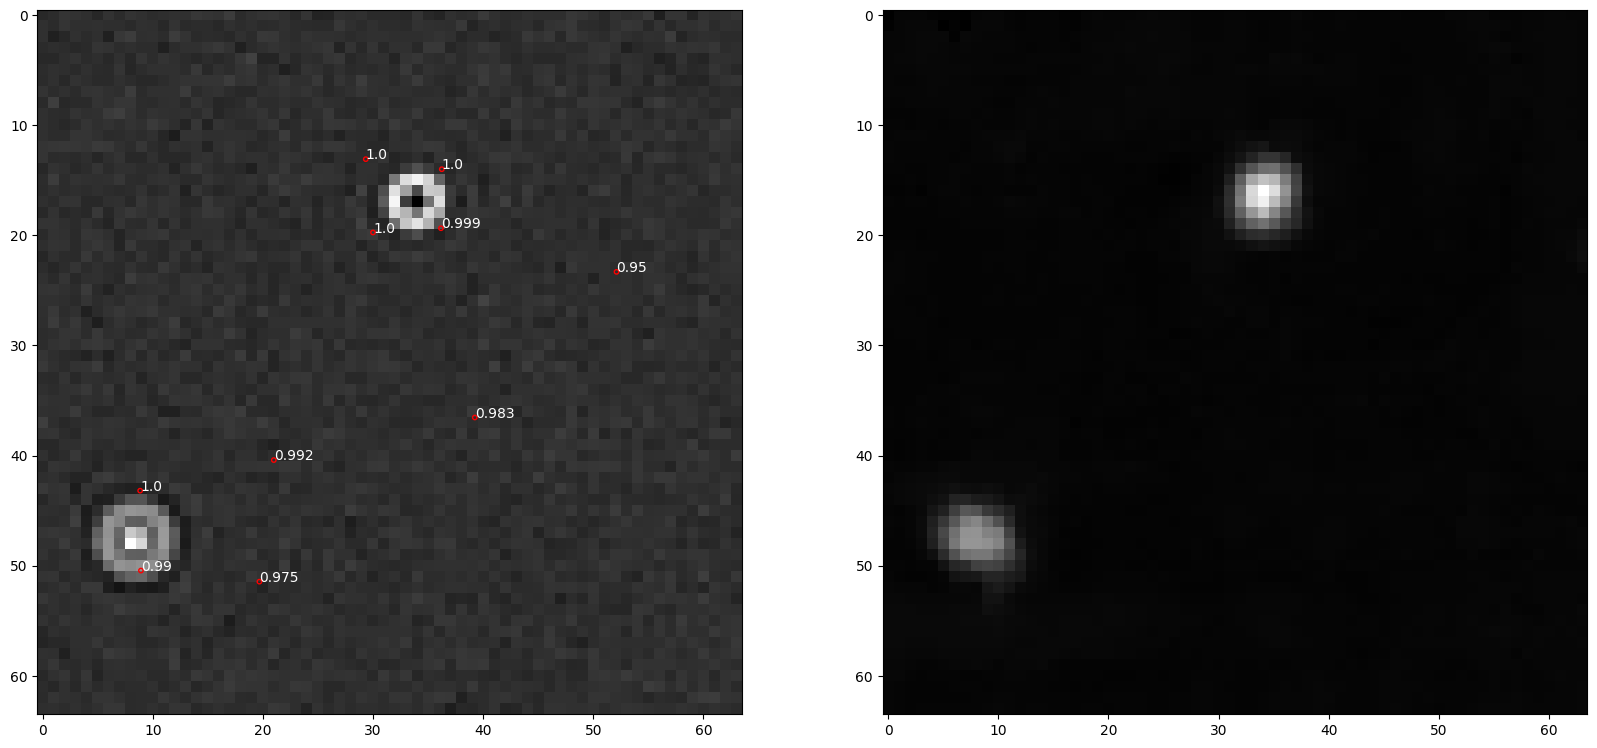

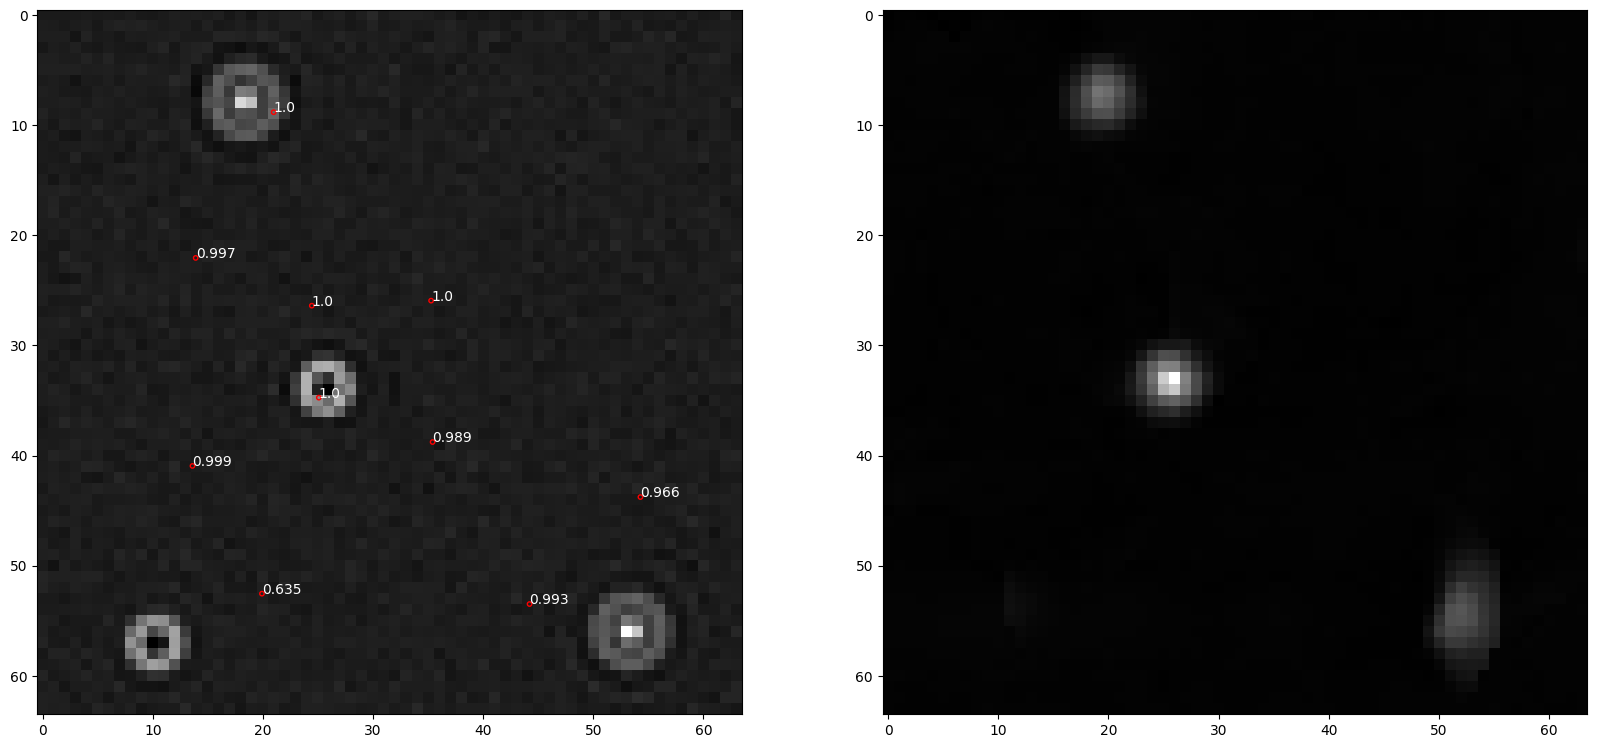

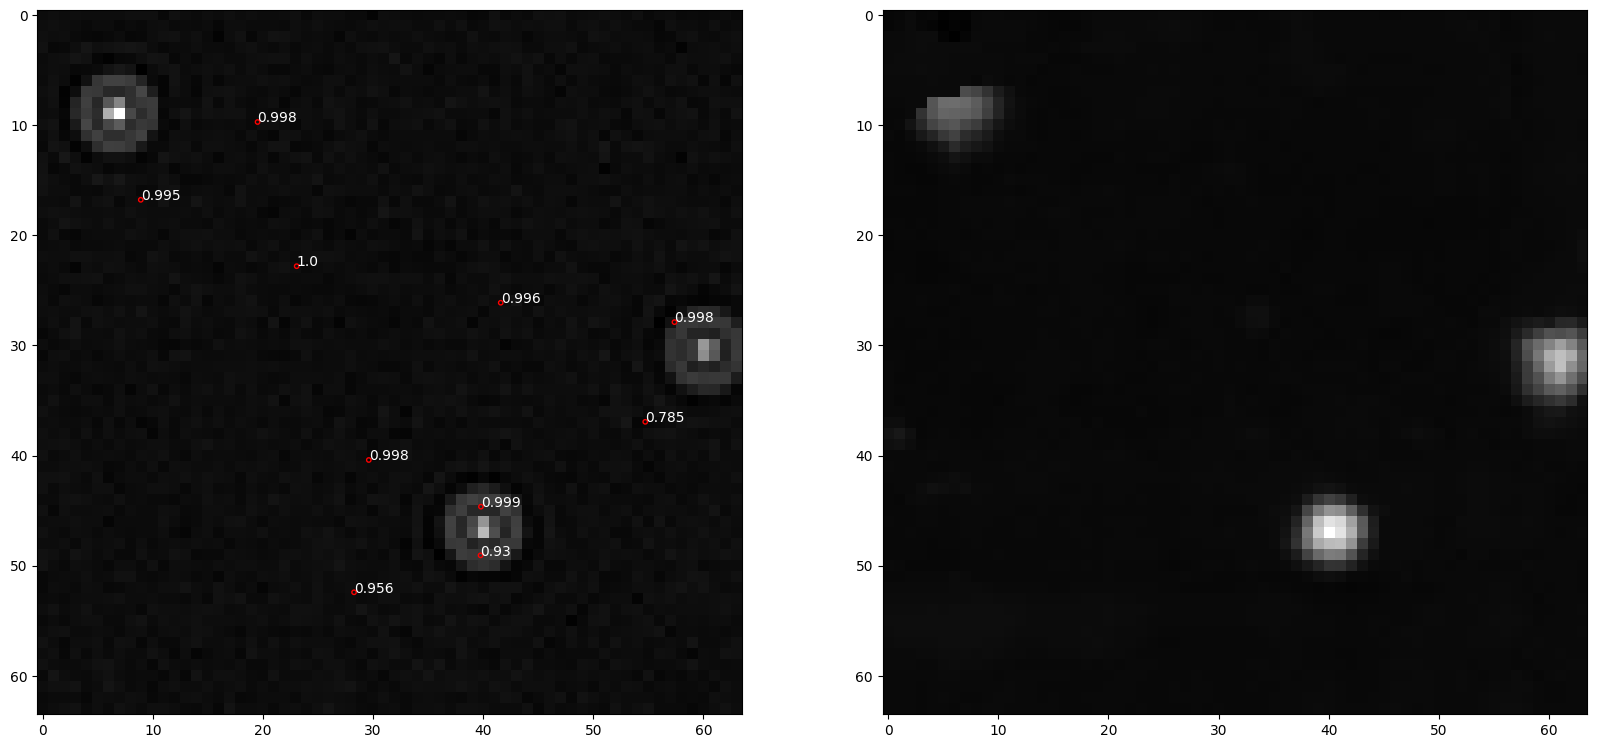

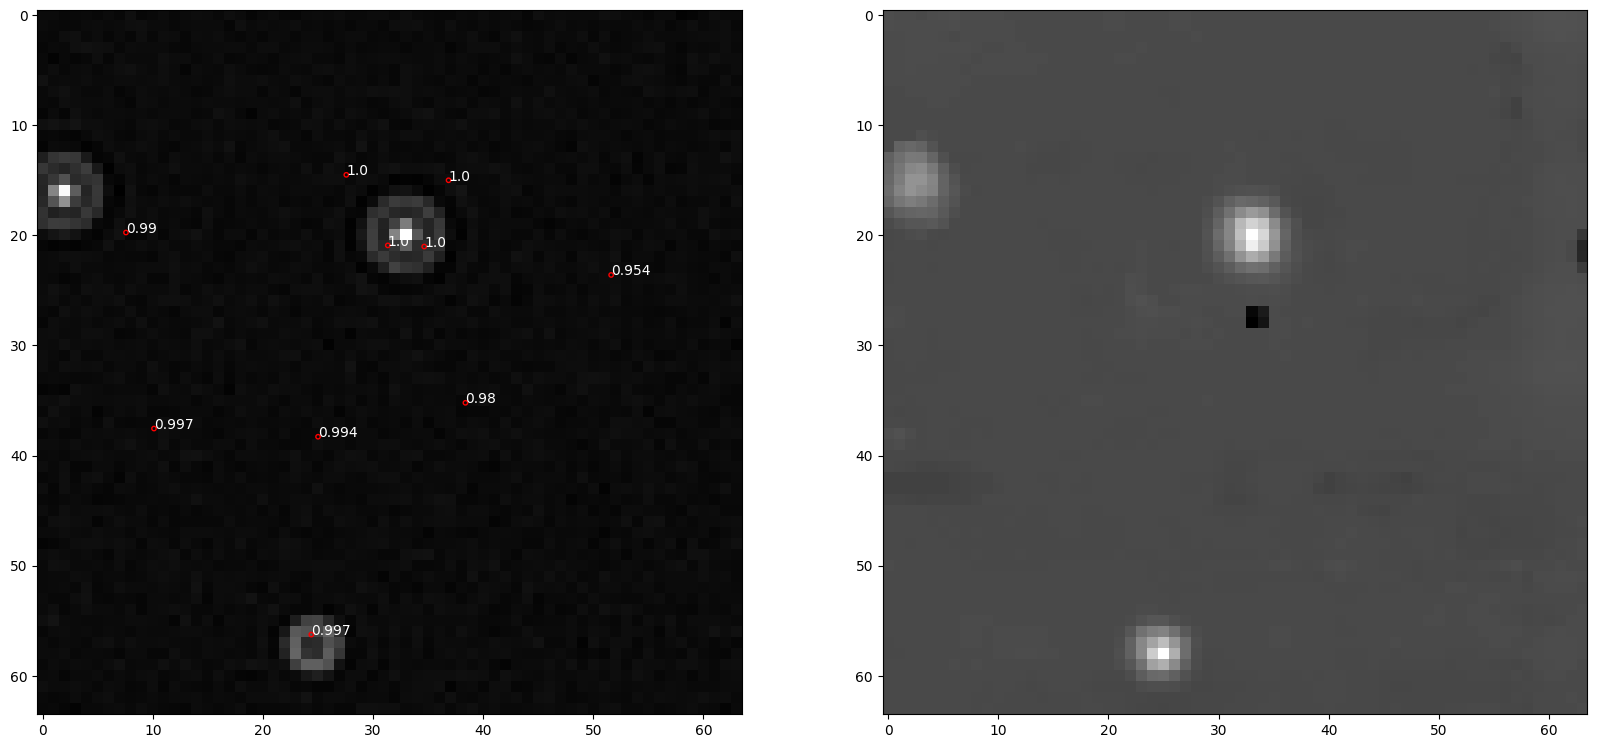

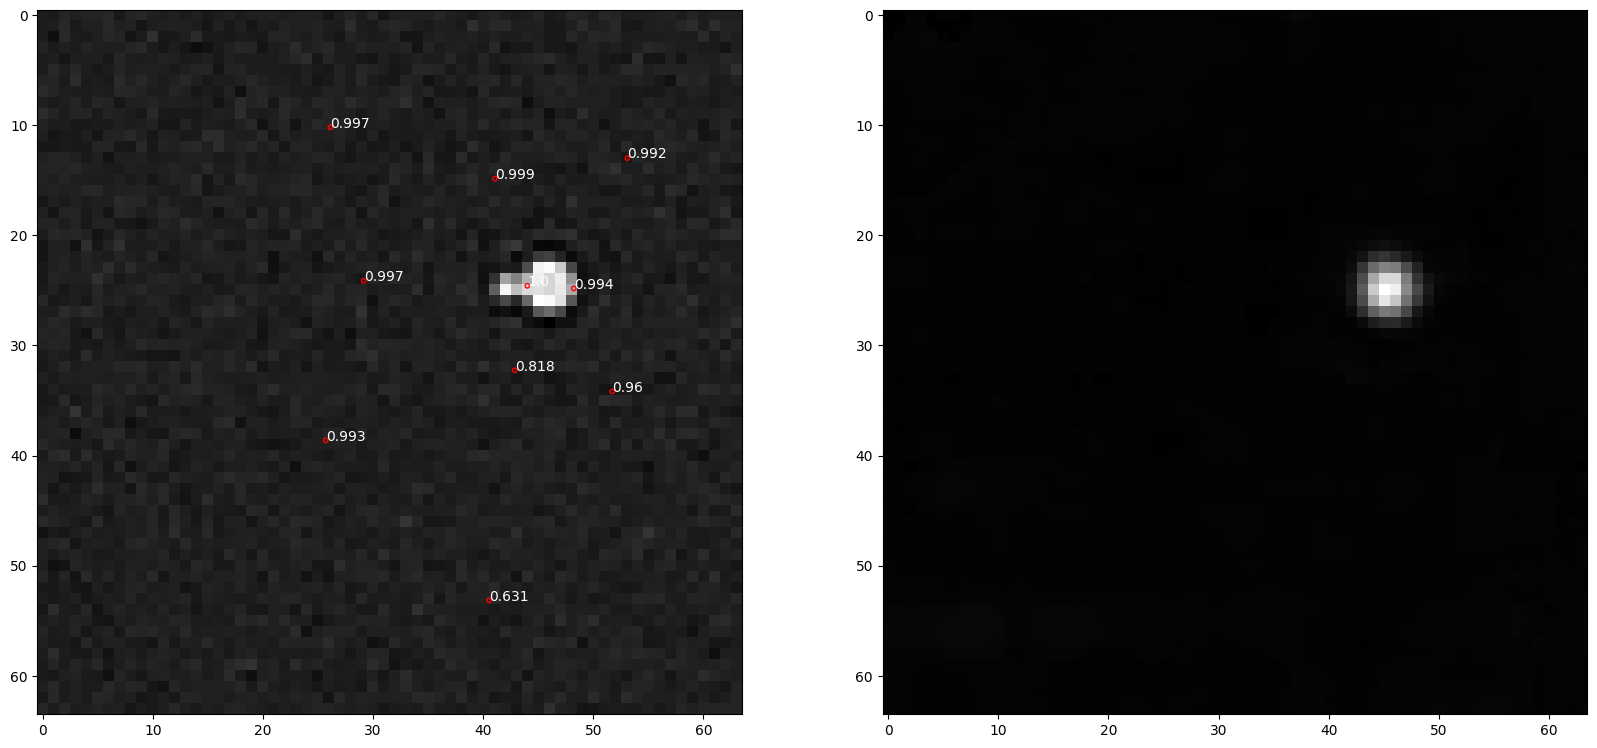

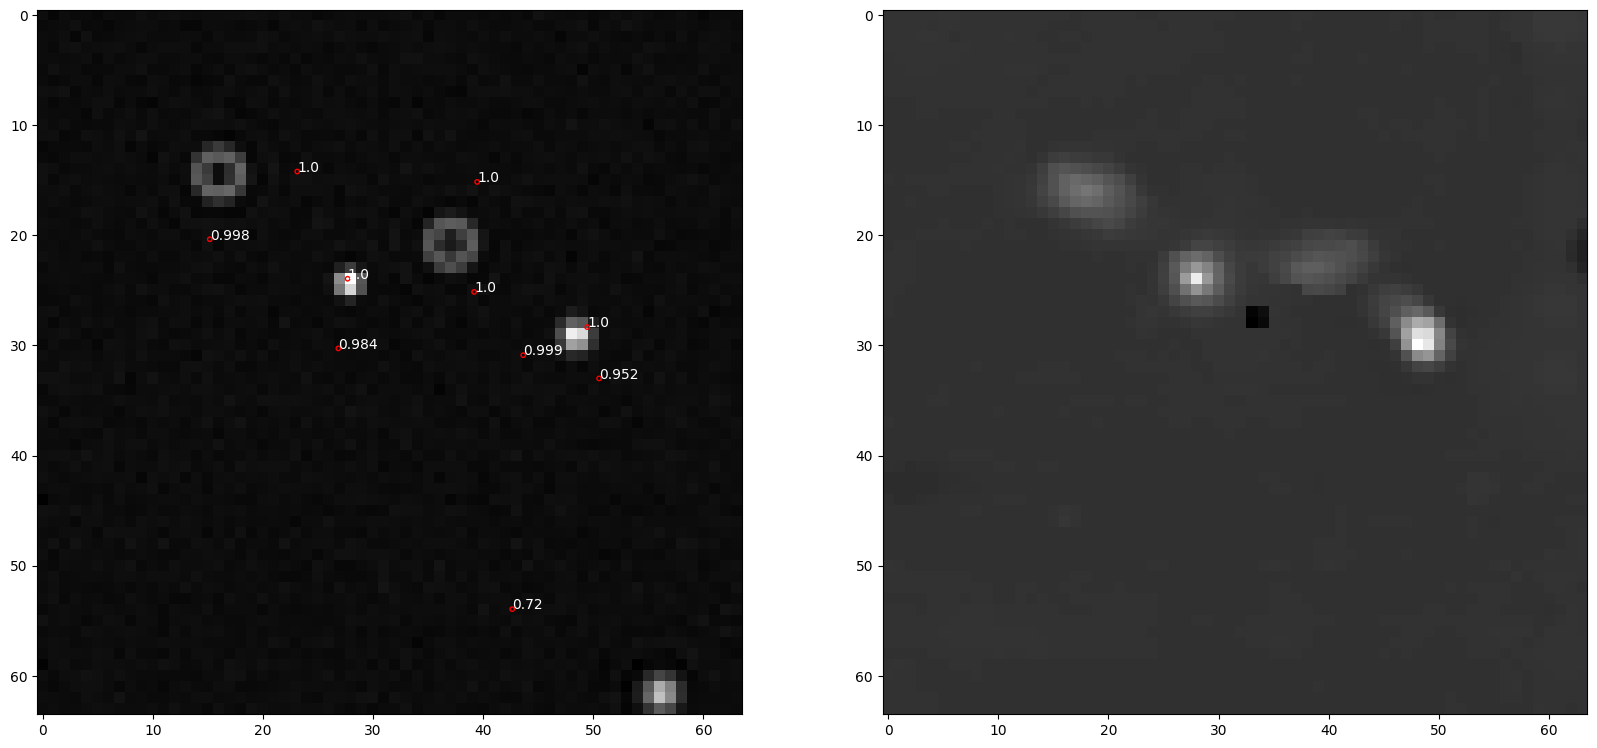

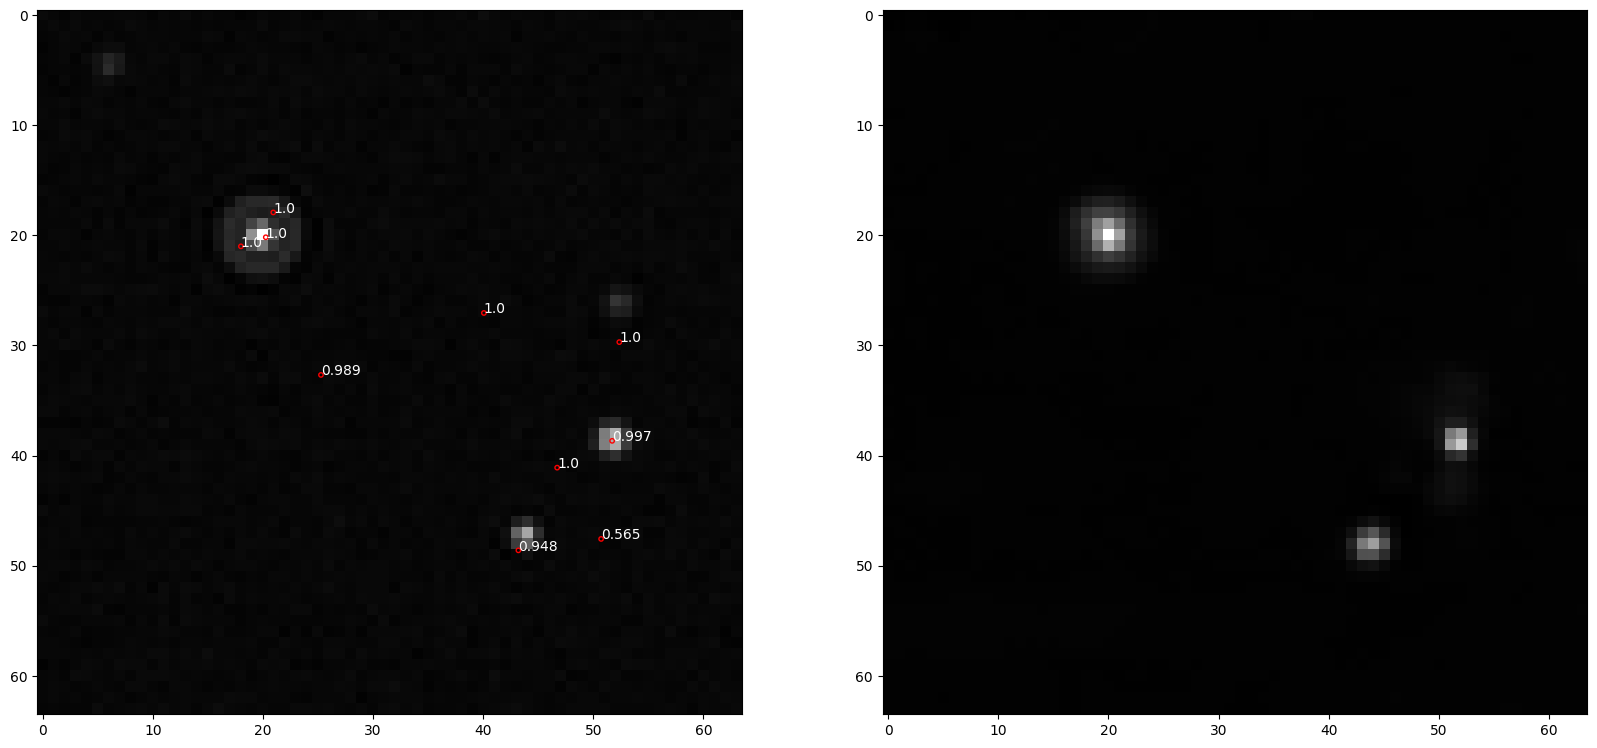

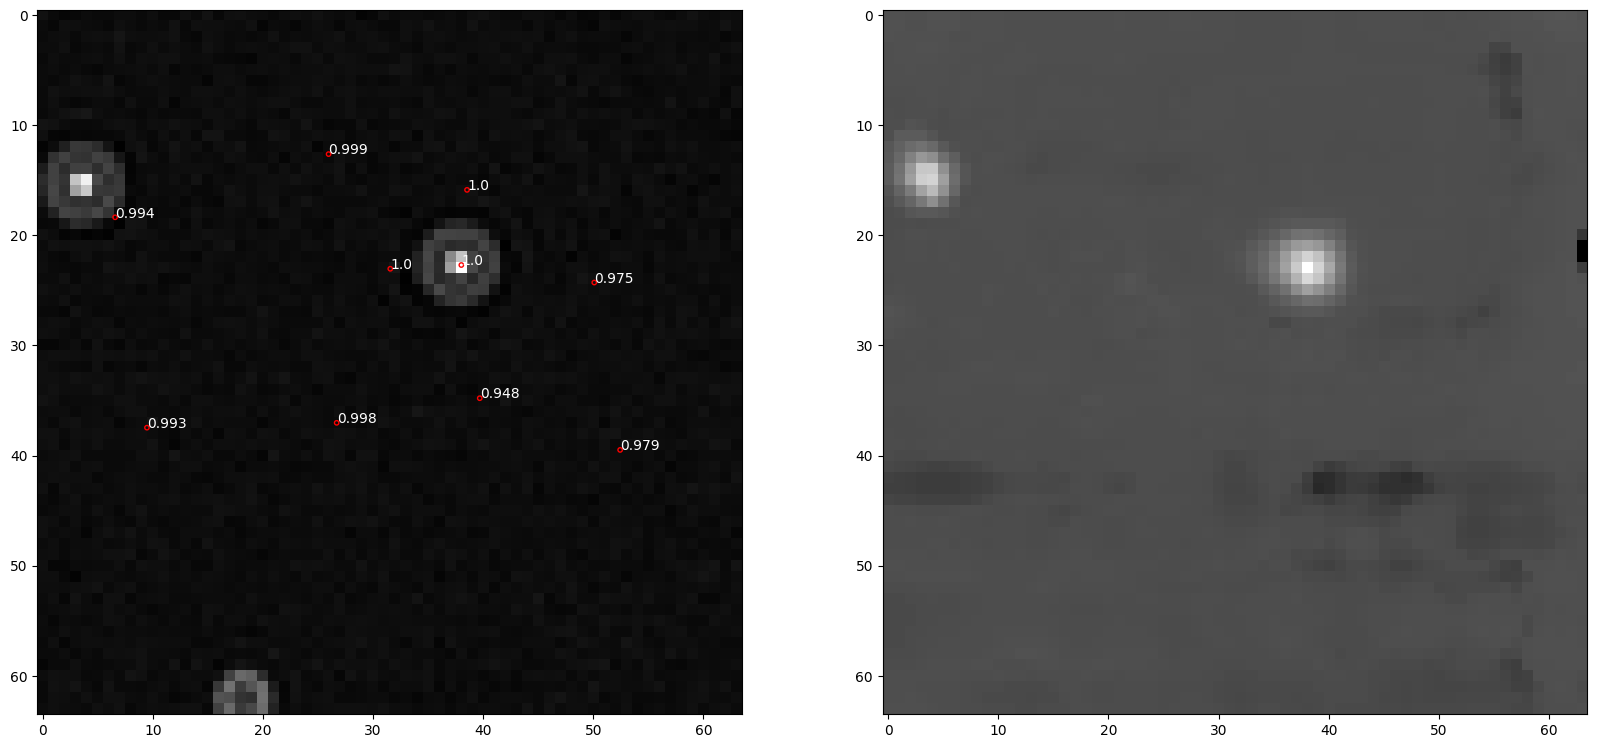

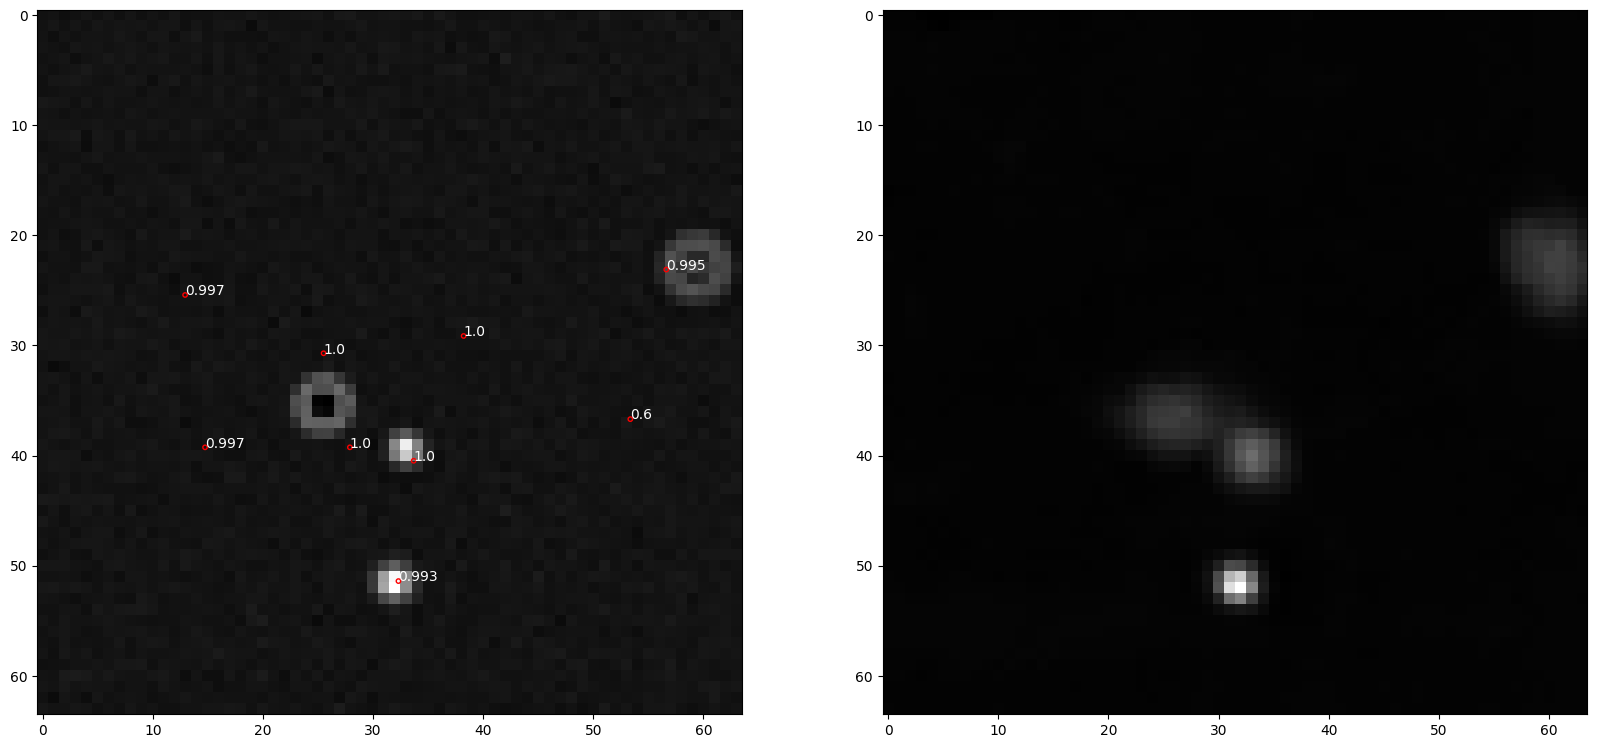

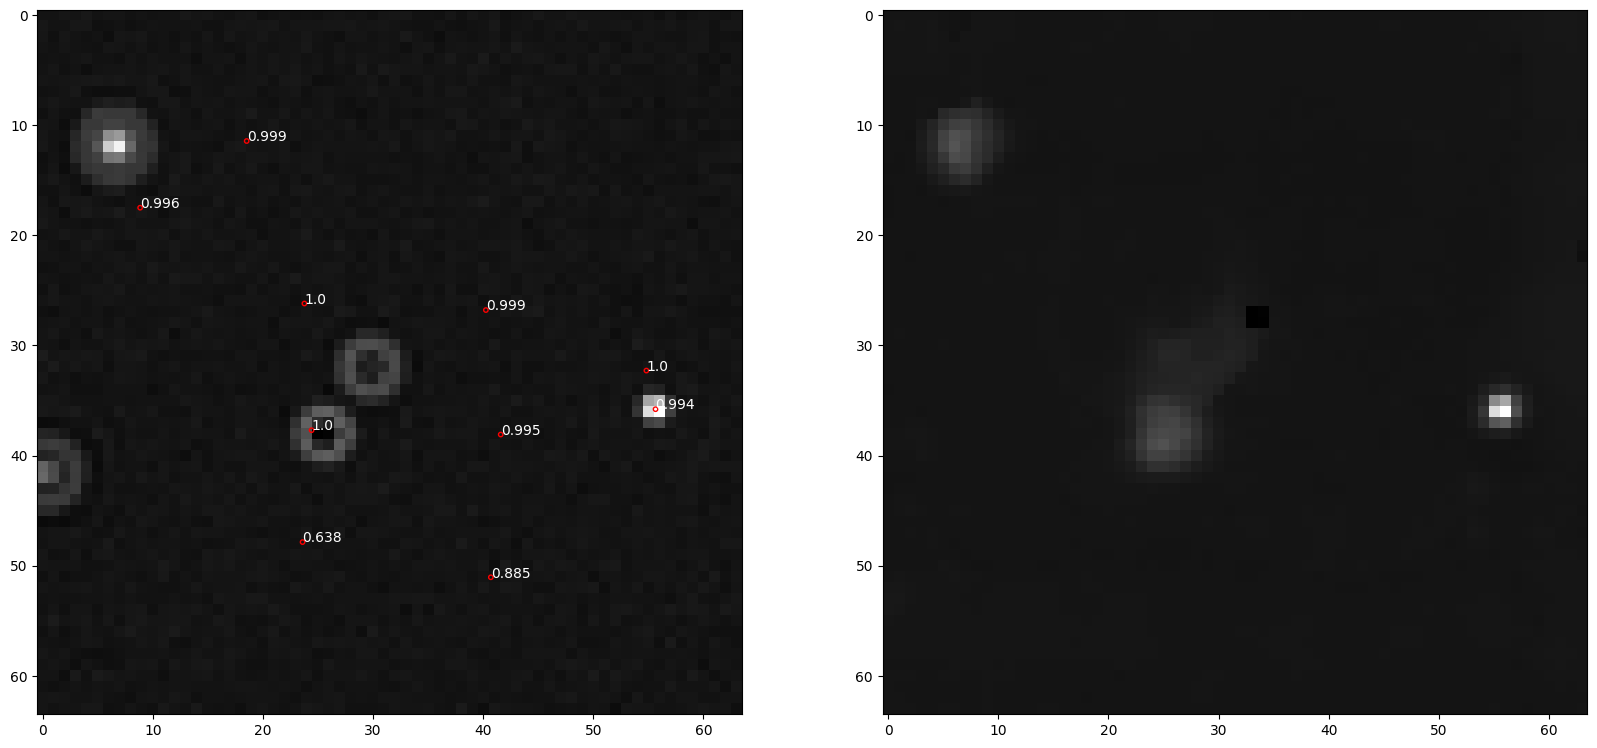

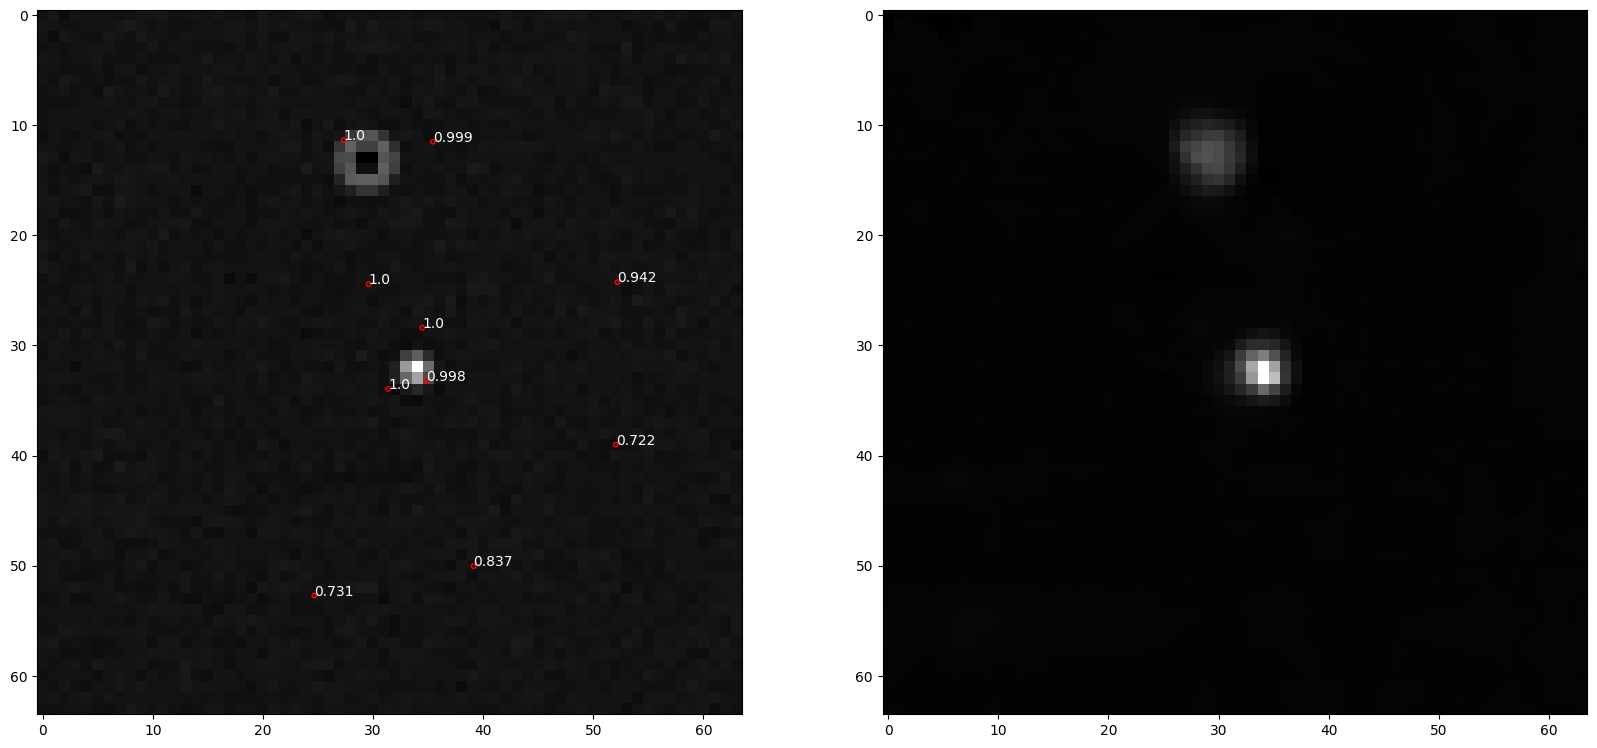

Error in callback <function flush_figures at 0x7fd29d1333a0> (for post_execute):


KeyboardInterrupt: 

In [44]:
importlib.reload(utils_single)

utils_single.run_test(
    test,
    model,
    combine_radius=2,
    plot_num=None,
    num_entities=10,
    pres_floor=0.25,
    )

### Save model

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-MP-firstworking.pth")